# 0.0. IMPORTS

In [1]:
import numpy      as np
import pandas     as pd
import statistics as st
import seaborn    as sns

import math
import inflection

import xgboost    as xgb
import pickle
import random
import time

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec # very interesting !!! Used in EDA.

from IPython.display       import Image
from IPython.core.display  import HTML

from tabulate              import tabulate
from scipy                 import stats
#from boruta                import BorutaPy # disabled to prevent new runs
from datetime              import datetime
from datetime              import timedelta

from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# general functions

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    %config InlineBackend.figure_format = 'retina'

    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.options.display.float_format = '{:,.4f}'.format
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


#### 1st Order Stats

In [3]:
# First Order Stats - Applied on 1.7.1 Numerical Attributes
def descriptive_stats_1st_order(df):
    # Central Tendency - mean, median, mode
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T
    ct3 = pd.DataFrame(df.apply(st.mode)).T

    # Dispersion
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .25))).T
    d6 = pd.DataFrame(df.apply(lambda x: np.quantile(x, .75))).T
    d7 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d8 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    ds = pd.concat([ct1, ct2, ct3, d1, d2, d3, d4,
                    d5, d6, d7, d8]).T.reset_index()
    ds.columns = ['attributes', 'mean', 'median', 'mode', 'std',
                  'min', 'max', 'range', 'Q1', 'Q3', 'skewness', 'kurtosis']
    return ds

#### Cramer V - chi²

In [4]:
# chi2 formula - Applied on 4.3.2. Categorical Attributes
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

#### MAPE Metric

In [5]:
# mean absolute percentage error formula - applied on ml_error function below
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y) )

#### ml_error

In [6]:
# Error summary function - applied on MACHINE LEARNING MODELLING
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE'  : mae,
                           'MAPE%': mape,
                           'RMSE' : rmse}, index=[0])

#### Cross Validation

In [7]:
# Cross-validation function - applied on STEP 07 - MACHINE LEARNING MODELLING
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    # errors lists to concatenate the values
    mae_list = []
    mape_list = []
    rmse_list = []

    # Cross-validation k-fold
    # k-fold range. reversed: range from max to min.
    for k in reversed( range( 1, kfold+1 ) ):
        k_init = time.time()
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        # subtract 6 weeks (6*7) from date max: first date of validation
        validation_start_date = x_training['date'].max() - timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - timedelta( days=(k-1)*6*7 )

        # filtering dataset for training and validation
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE%'] )
        rmse_list.append( m_result['RMSE'] )
    
    print(time.time() - k_init)
    
    # mean and standard deviation of errors after cross-validation  
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV':  np.round( np.mean(  mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std(  mae_list), 2 ).astype( str ),
                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list), 2 ).astype( str ),
                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list), 2 ).astype( str ) }, index=[0] )
    

#### MPE Metric

In [8]:
# Mean Percentage Error - applied on HYPERPARAMETER FINE TUNING
def mean_percentage_error(y, yhat):
    return np.mean( ( y - yhat ) / y)

## ---

In [9]:
rawdatapath = '../data/raw/'
intdatapath = '../data/interim/'
modelpath = '../models/'
seed = 17
rawdatafile = 'rossmann_sales.csv'

## ---

## 0.2. Loading Data

In [10]:
df_raw = pd.read_csv(rawdatapath+rawdatafile, low_memory=False)

In [11]:
df_raw.sample(5).T

997407      135204            996758           920581      645819
Store                             268         290               734              377        1020
DayOfWeek                           5           3                 6                4           6
Date                       2013-01-18  2015-04-01        2013-01-19       2013-03-28  2013-11-30
Sales                            4069       10554              4457            12765       13117
Customers                         553         868               387             1342        1576
Open                                1           1                 1                1           1
Promo                               0           1                 0                1           0
StateHoliday                        0           0                 0                0           0
SchoolHoliday                       0           1                 0                1           0
StoreType                           a           a                 a                a           a
Assortment                          a           a                 a                c           a
CompetitionDistance        4,520.0000  4,150.0000          220.0000         100.0000     40.0000
CompetitionOpenSinceMonth      2.0000      5.0000               NaN           6.0000      8.0000
CompetitionOpenSinceYear   2,014.0000  2,001.0000               NaN       2,010.0000  2,015.0000
Promo2                              0           0                 1                1           0
Promo2SinceWeek                   NaN         NaN           36.0000          18.0000         NaN
Promo2SinceYear                   NaN         NaN        2,013.0000       2,010.0000         NaN
PromoInterval                     NaN         NaN  Mar,Jun,Sept,Dec  Feb,May,Aug,Nov         NaN

# 1.0. DATA DESCRIPTION

In [12]:
# copy original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [14]:
df1.sample(10).T

43145            740858           287838      77232       457004      543117           937943      461792           520456      660496
store                                     776              169               39         298         640         898             1014         968              537          87
day_of_week                                 2                4                4           6           7           7                3           3                6           6
date                               2015-06-23       2013-09-05       2014-11-06  2015-05-23  2014-05-18  2014-03-02       2013-03-13  2014-05-14       2014-03-22  2013-11-16
sales                                    4063             5217             5640        9628           0           0            10505        6627             4807        3245
customers                                 466              652              679         815           0           0             1272         821              513         398
open                                        1                1                1           1           0           0                1           1                1           1
promo                                       0                0                1           0           0           0                0           0                0           0
state_holiday                               0                0                0           0           0           0                0           0                0           0
school_holiday                              0                0                0           0           0           0                0           0                0           0
store_type                                  c                d                a           d           d           a                a           c                a           a
assortment                                  a                a                a           a           c           a                c           a                a           a
competition_distance                 700.0000         980.0000         260.0000 19,840.0000  8,040.0000 18,540.0000         210.0000  1,190.0000         600.0000    560.0000
competition_open_since_month           4.0000           7.0000          10.0000      7.0000         NaN         NaN              NaN         NaN           5.0000     12.0000
competition_open_since_year        2,009.0000       2,014.0000       2,006.0000  2,009.0000         NaN         NaN              NaN         NaN       2,002.0000  2,010.0000
promo2                                      1                1                1           0           0           0                1           0                1           0
promo2_since_week                     14.0000          18.0000          31.0000         NaN         NaN         NaN          31.0000         NaN           1.0000         NaN
promo2_since_year                  2,011.0000       2,014.0000       2,013.0000         NaN         NaN         NaN       2,013.0000         NaN       2,012.0000         NaN
promo_interval                Jan,Apr,Jul,Oct  Feb,May,Aug,Nov  Feb,May,Aug,Nov         NaN         NaN         NaN  Jan,Apr,Jul,Oct         NaN  Jan,Apr,Jul,Oct         NaN

## 1.2. Data Dimensions

In [15]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


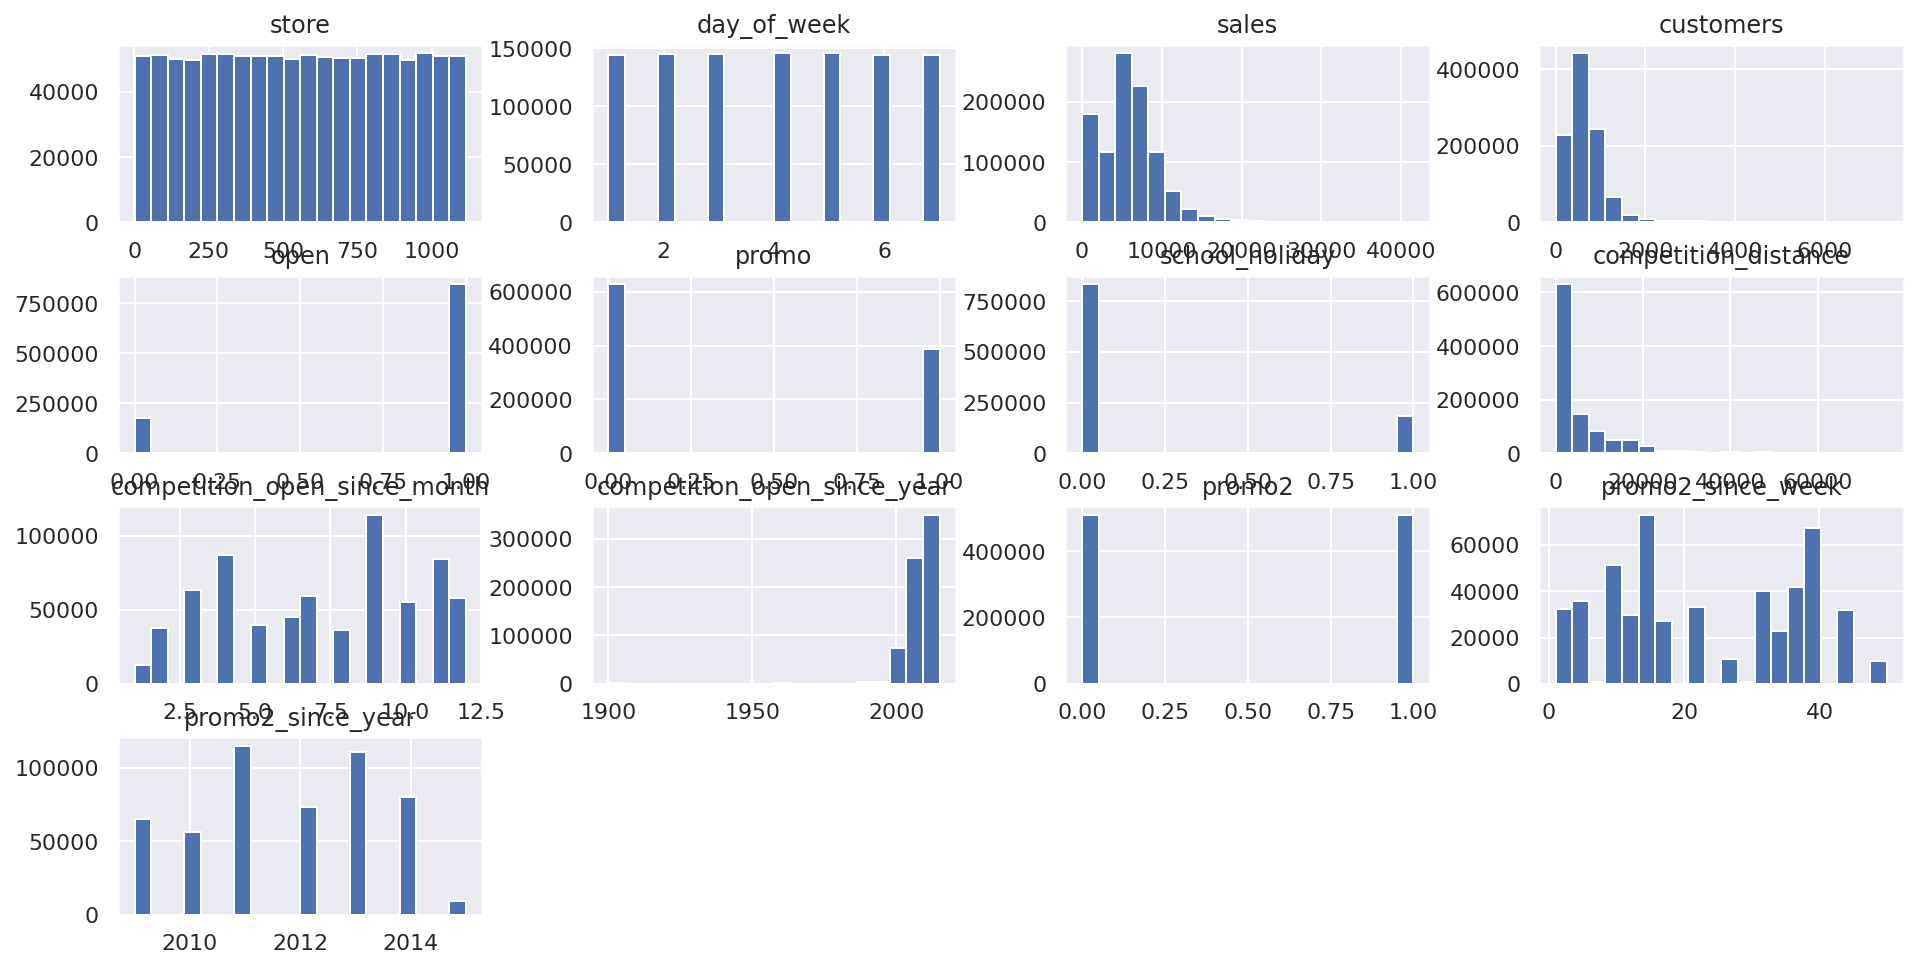

In [16]:
df1.hist(bins=20);

## 1.3. Data Types

In [17]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [19]:
df1.sample(5).T

651682               732093               477911               192364               123262
store                                         193                  324                  362                  585                  613
day_of_week                                     7                    5                    2                    1                    7
date                          2013-11-24 00:00:00  2013-09-13 00:00:00  2014-04-29 00:00:00  2015-02-09 00:00:00  2015-04-12 00:00:00
sales                                           0                 5866                10643                 4371                    0
customers                                       0                  792                 1284                  790                    0
open                                            0                    1                    1                    1                    0
promo                                           0                    1                    1                    0                    0
state_holiday                                   0                    0                    0                    0                    0
school_holiday                                  0                    0                    0                    0                    0
store_type                                      a                    a                    c                    d                    c
assortment                                      a                    a                    c                    c                    a
competition_distance                     520.0000          13,140.0000             340.0000             440.0000             250.0000
competition_open_since_month                  NaN                  NaN                  NaN               4.0000               6.0000
competition_open_since_year                   NaN                  NaN                  NaN           2,014.0000           2,007.0000
promo2                                          0                    1                    0                    0                    1
promo2_since_week                             NaN              14.0000                  NaN                  NaN              14.0000
promo2_since_year                             NaN           2,011.0000                  NaN                  NaN           2,011.0000
promo_interval                                NaN      Jan,Apr,Jul,Oct                  NaN                  NaN      Jan,Apr,Jul,Oct

In [20]:
df1['competition_distance'].max()

75860.0

In [21]:
# competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 100000.0 if math.isnan(x) else x)

In [22]:
# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [23]:
#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [24]:
#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [25]:
#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [26]:
# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

In [27]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6. Change Types

In [28]:
# Some operations may have changed the data types
# Check the data types again and change them (if necessary)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [29]:
# change competition_open_since_month type to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# change competition_open_since_year type to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# change promo2_since_week type to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# change promo2_since_year type to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [30]:
# Check data type
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.7. Descriptive Statistics

Descriptive Statistics is important for two main reasons:
1. Obtain business know-how;
2. Detect some errors.

Within the Descriptive Statistics there are two main metrics:
1. Dispersion metrics (standard deviation, min, max, skew, kurtosis);
2. Central Tendency metrics (for example mean and median)

In [31]:
# Select numerical variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# Select categorical variables
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [32]:
df_1st_order_stats = descriptive_stats_1st_order(num_attributes)
df_1st_order_stats

attributes       mean     median       mode        std        min          max       range         Q1         Q3  skewness  kurtosis
0                          store   558.4297   558.0000     1.0000   321.9085     1.0000   1,115.0000  1,114.0000   280.0000   838.0000   -0.0010   -1.2005
1                    day_of_week     3.9983     4.0000     5.0000     1.9974     1.0000       7.0000      6.0000     2.0000     6.0000    0.0016   -1.2469
2                          sales 5,773.8190 5,744.0000     0.0000 3,849.9243     0.0000  41,551.0000 41,551.0000 3,727.0000 7,856.0000    0.6415    1.7784
3                      customers   633.1459   609.0000     0.0000   464.4115     0.0000   7,388.0000  7,388.0000   405.0000   837.0000    1.5987    7.0918
4                           open     0.8301     1.0000     1.0000     0.3755     0.0000       1.0000      1.0000     1.0000     1.0000   -1.7580    1.0907
5                          promo     0.3815     0.0000     0.0000     0.4858     0.0000       1.0000      1.0000     0.0000     1.0000    0.4878   -1.7620
6                 school_holiday     0.1786     0.0000     0.0000     0.3831     0.0000       1.0000      1.0000     0.0000     0.0000    1.6778    0.8152
7           competition_distance 5,675.7124 2,330.0000   250.0000 9,085.1593    20.0000 100,000.0000 99,980.0000   710.0000 6,910.0000    4.6372   35.2875
8   competition_open_since_month     6.7868     7.0000     9.0000     3.3111     1.0000      12.0000     11.0000     4.0000    10.0000   -0.0421   -1.2326
9    competition_open_since_year 2,010.3248 2,012.0000 2,013.0000     5.5156 1,900.0000   2,015.0000    115.0000 2,008.0000 2,014.0000   -7.2357  124.0713
10                        promo2     0.5006     1.0000     1.0000     0.5000     0.0000       1.0000      1.0000     0.0000     1.0000   -0.0023   -2.0000
11             promo2_since_week    23.6190    22.0000    14.0000    14.3101     1.0000      52.0000     51.0000    12.0000    37.0000    0.1787   -1.1840
12             promo2_since_year 2,012.7933 2,013.0000 2,013.0000     1.6627 2,009.0000   2,015.0000      6.0000 2,012.0000 2,014.0000   -0.7844   -0.2101

### 1.7.2. Categorical Attributes

In [33]:
# Check unique entries of categorical attributes
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

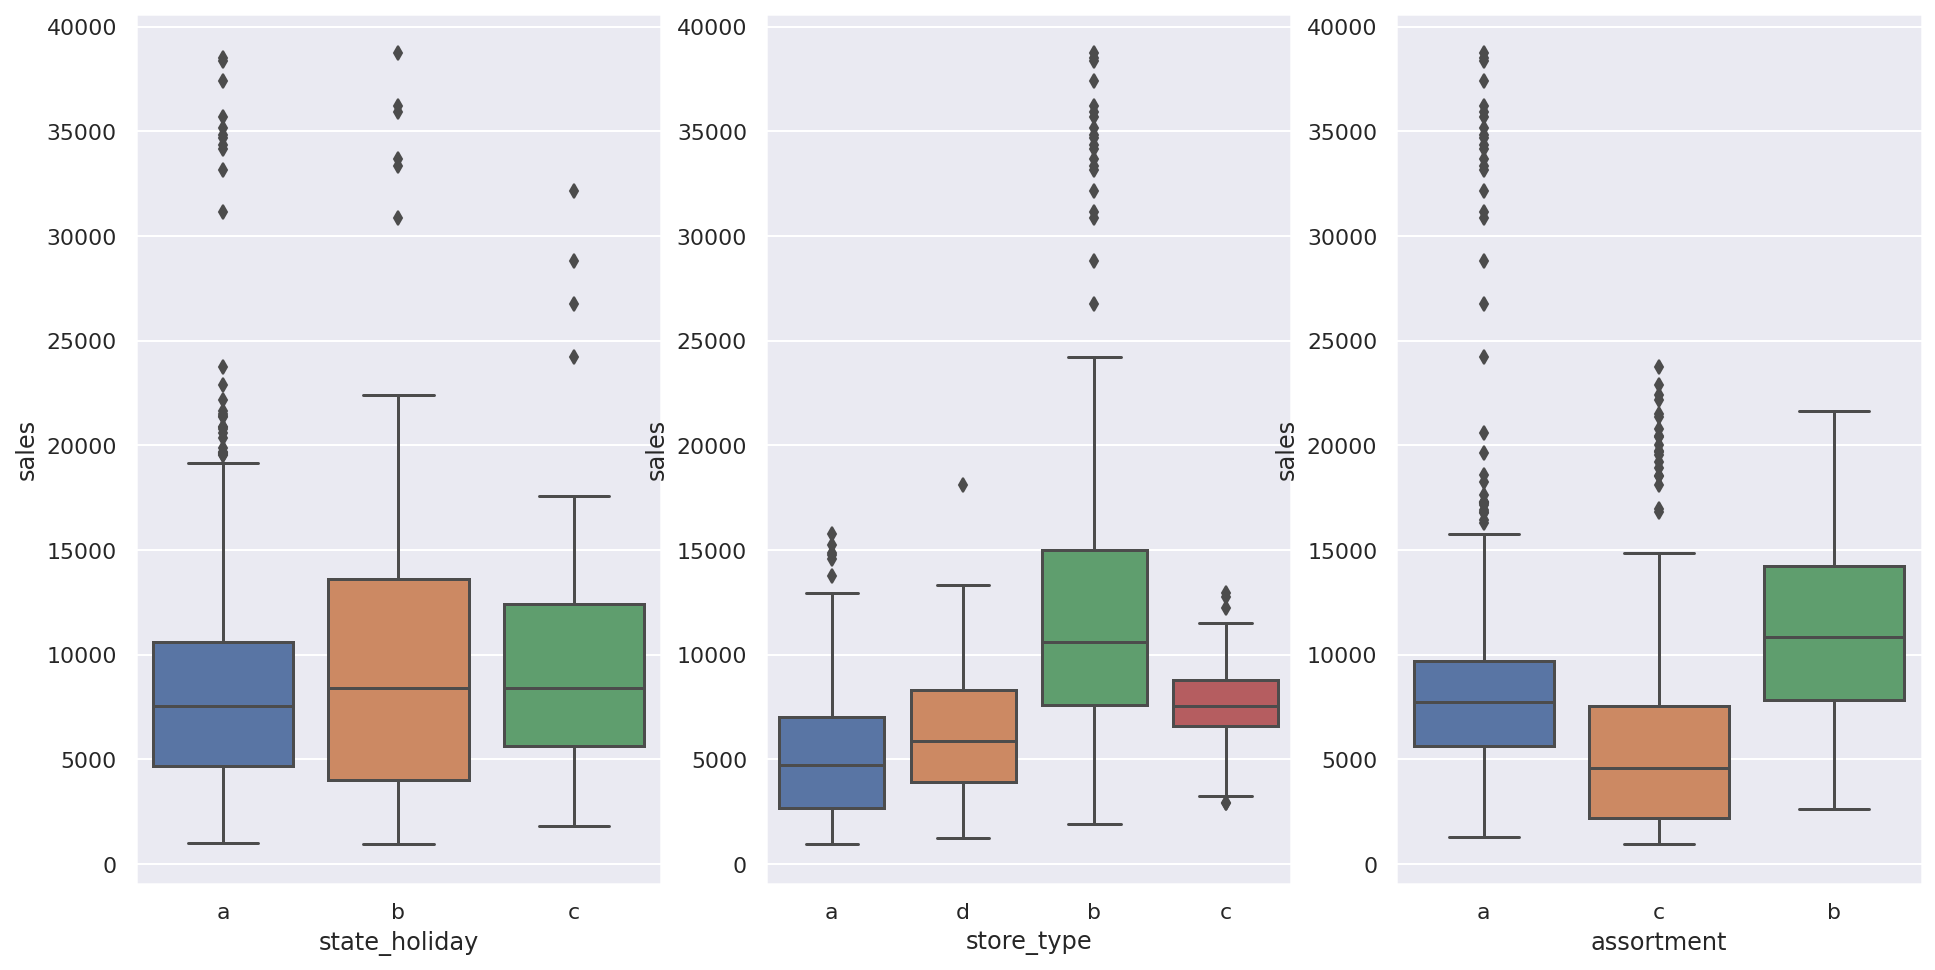

In [34]:
# Filter only holiday (regular day == 0) and sales higher than 0 (stores open)
# The filter is needed to better off boxplot visualization.
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

# boxplot state_holiday (without regular days) with respect to sales
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

# boxplot store_type
plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

# boxplot assortment
plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1);

### saving data

In [35]:
pickle.dump( df1, open( intdatapath+'df1.pkl', 'wb' ) )

# 2.0. FEATURE ENGINEERING

In [36]:
df2 = pickle.load( open( intdatapath+'df1.pkl', 'rb' ) )

## 2.1. Mind Map Hypothesis

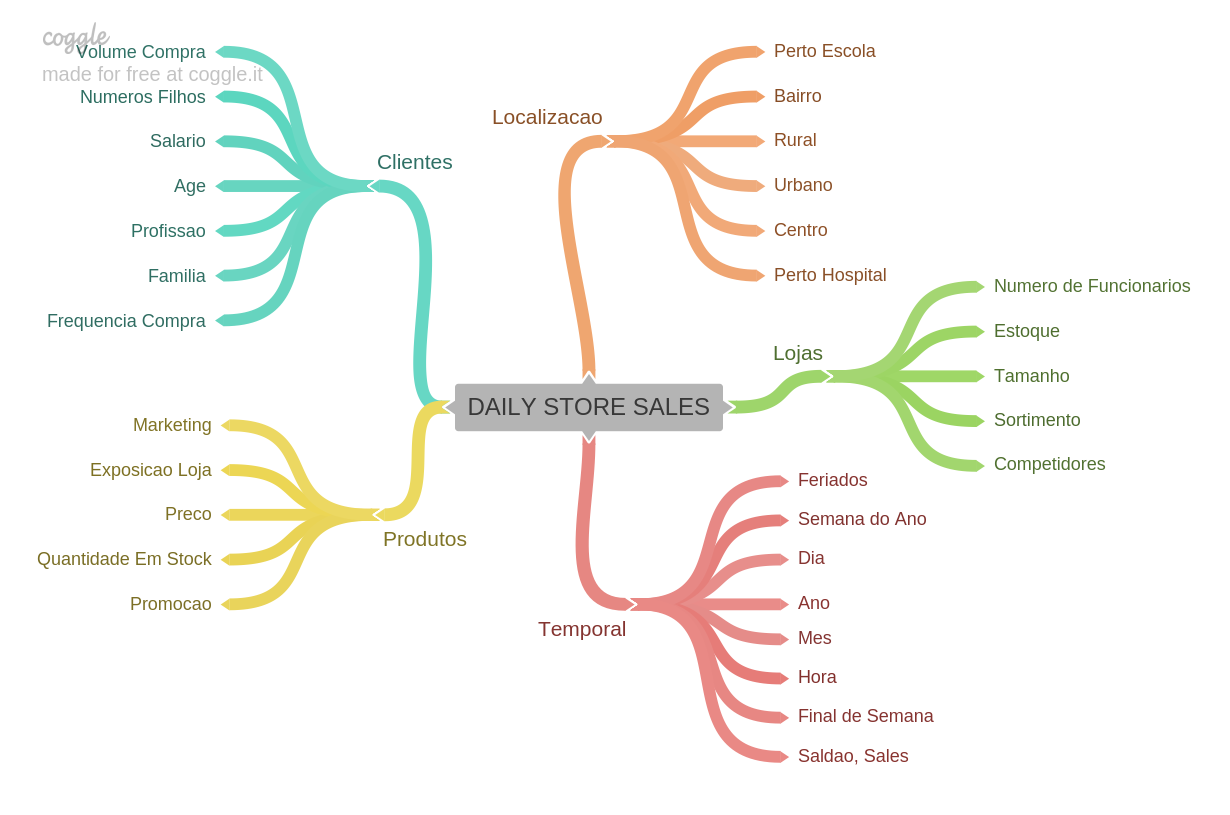

In [37]:
Image('../images/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with bigger staff (employees) should sell more.

**2.** Stores with bigger Stock should sell more.

**3.** Stores with bigger size should sell more.

**4.** Stores with bigger Assortment should sell more.

**5.** Stores with competition closer should sell less.

**6.** Stores with longer time competition should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more on Marketing should sell more.

**2.** Stores that expose more the products (Store Placement) should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores with more agressive Sale (bigger discount) should sell more.

**5.** Stores with longer Sale (promo) should sell more.

**6.** Stores with more Sale (promo) days should sell more.

**7.** Stores with more consecutive Sale (promo) should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas time should sell more.

**2.** Stores should sell more throughout the years.

**3.** Stores should sell more on second semester.

**4.** Stores should sell more after the 10th months day.

**5.** Stores should sell less on weekend.

**6.** Stores should sell less while school vacation.

### 2.2.4. Customers Hypothesis

**1.** Stores with more customers should sell more.

## 2.3. Final Hypothesis List (Based on the data available in the original dataset)

**1.** Stores with bigger Assortment should sell more.

**2.** Stores with competition closer should sell less.

**3.** Stores with longer time competition should sell more.

**4.** Stores with longer Sale (promo) should sell more.

**5.** Stores with more Sale (promo) days should sell more.

**6.** Stores with more consecutive Sale (promo) should sell more.

**7.** Stores open on Christmas time should sell more.

**8.** Stores should sell more throughout the years.

**9.** Stores should sell more on second semester.

**10.** Stores should sell more after the 10th months day.

**11.** Stores should sell less on weekend.

**12.** Stores should sell less while school vacation.

**13.** Stores with more customers should sell more.

## 2.4. Feature Engineering

In [38]:
# year
df2['year'] = df2['date'].dt.year

In [39]:
# month
df2['month'] = df2['date'].dt.month

In [40]:
# day
df2['day'] = df2['date'].dt.day

In [41]:
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

In [42]:
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [43]:
# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.

df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)


In [44]:
# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )


In [45]:
# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

In [46]:
# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

In [47]:
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [48]:
df2.head().T

0                    1                    2                    3                    4
store                                           1                    2                    3                    4                    5
day_of_week                                     5                    5                    5                    5                    5
date                          2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                        5263                 6064                 8314                13995                 4822
customers                                     555                  625                  821                 1498                  559
open                                            1                    1                    1                    1                    1
promo                                           1                    1                    1                    1                    1
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  1                    1                    1                    1                    1
store_type                                      c                    a                    a                    c                    a
assortment                                  basic                basic                basic             extended                basic
competition_distance                   1,270.0000             570.0000          14,130.0000             620.0000          29,910.0000
competition_open_since_month                    9                   11                   12                    9                    4
competition_open_since_year                  2008                 2007                 2006                 2009                 2015
promo2                                          0                    1                    1                    0                    0
promo2_since_week                              31                   13                   14                   31                   31
promo2_since_year                            2015                 2010                 2011                 2015                 2015
promo_interval                                  0      Jan,Apr,Jul,Oct      Jan,Apr,Jul,Oct                    0                    0
year                                         2015                 2015                 2015                 2015                 2015
month                                           7                    7                    7                    7                    7
day                                            31                   31                   31                   31                   31
week_of_year                                   31                   31                   31                   31                   31
year_week                                 2015-30              2015-30              2015-30              2015-30              2015-30
competition_since             2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         84                   94                  105                   71                    4
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                 0                  279                  226                    0                    0

### saving data

In [49]:
pickle.dump( df2, open( intdatapath+'df2.pkl', 'wb' ) )

# 3.0. VARIABLES FILTERING

In [50]:
df3 = pickle.load( open( intdatapath+'df2.pkl', 'rb' ) )

In [51]:
df3.head().T

0                    1                    2                    3                    4
store                                           1                    2                    3                    4                    5
day_of_week                                     5                    5                    5                    5                    5
date                          2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                        5263                 6064                 8314                13995                 4822
customers                                     555                  625                  821                 1498                  559
open                                            1                    1                    1                    1                    1
promo                                           1                    1                    1                    1                    1
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  1                    1                    1                    1                    1
store_type                                      c                    a                    a                    c                    a
assortment                                  basic                basic                basic             extended                basic
competition_distance                   1,270.0000             570.0000          14,130.0000             620.0000          29,910.0000
competition_open_since_month                    9                   11                   12                    9                    4
competition_open_since_year                  2008                 2007                 2006                 2009                 2015
promo2                                          0                    1                    1                    0                    0
promo2_since_week                              31                   13                   14                   31                   31
promo2_since_year                            2015                 2010                 2011                 2015                 2015
promo_interval                                  0      Jan,Apr,Jul,Oct      Jan,Apr,Jul,Oct                    0                    0
year                                         2015                 2015                 2015                 2015                 2015
month                                           7                    7                    7                    7                    7
day                                            31                   31                   31                   31                   31
week_of_year                                   31                   31                   31                   31                   31
year_week                                 2015-30              2015-30              2015-30              2015-30              2015-30
competition_since             2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         84                   94                  105                   71                    4
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                 0                  279                  226                    0                    0

## 3.1. Line Filtering

In [52]:
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
# sales = 0 will also be removed.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [53]:
# Remove outliers - 0,1% from highest sales values - ????
q = df3['sales'].quantile(0.999)
df3 = df3[df3['sales'] < q]

## 3.2. Columns Selection

In [54]:
# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
# month_map is an auxiliary column and hence will be removed.
cols_drop = ['open', 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

In [55]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'year', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

In [56]:
df3.head().T

0                    1                    2                    3                    4
store                                           1                    2                    3                    4                    5
day_of_week                                     5                    5                    5                    5                    5
date                          2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                        5263                 6064                 8314                13995                 4822
customers                                     555                  625                  821                 1498                  559
promo                                           1                    1                    1                    1                    1
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  1                    1                    1                    1                    1
store_type                                      c                    a                    a                    c                    a
assortment                                  basic                basic                basic             extended                basic
competition_distance                   1,270.0000             570.0000          14,130.0000             620.0000          29,910.0000
competition_open_since_month                    9                   11                   12                    9                    4
competition_open_since_year                  2008                 2007                 2006                 2009                 2015
promo2                                          0                    1                    1                    0                    0
promo2_since_week                              31                   13                   14                   31                   31
promo2_since_year                            2015                 2010                 2011                 2015                 2015
year                                         2015                 2015                 2015                 2015                 2015
month                                           7                    7                    7                    7                    7
day                                            31                   31                   31                   31                   31
week_of_year                                   31                   31                   31                   31                   31
year_week                                 2015-30              2015-30              2015-30              2015-30              2015-30
competition_since             2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         84                   94                  105                   71                    4
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                 0                  279                  226                    0                    0

### saving data

In [57]:
pickle.dump( df3, open( intdatapath+'df3.pkl', 'wb' ) )

# 4.0. EXPLORATORY DATA ANALYSIS

In [58]:
df4 = pickle.load( open( intdatapath+'df3.pkl', 'rb' ) )

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

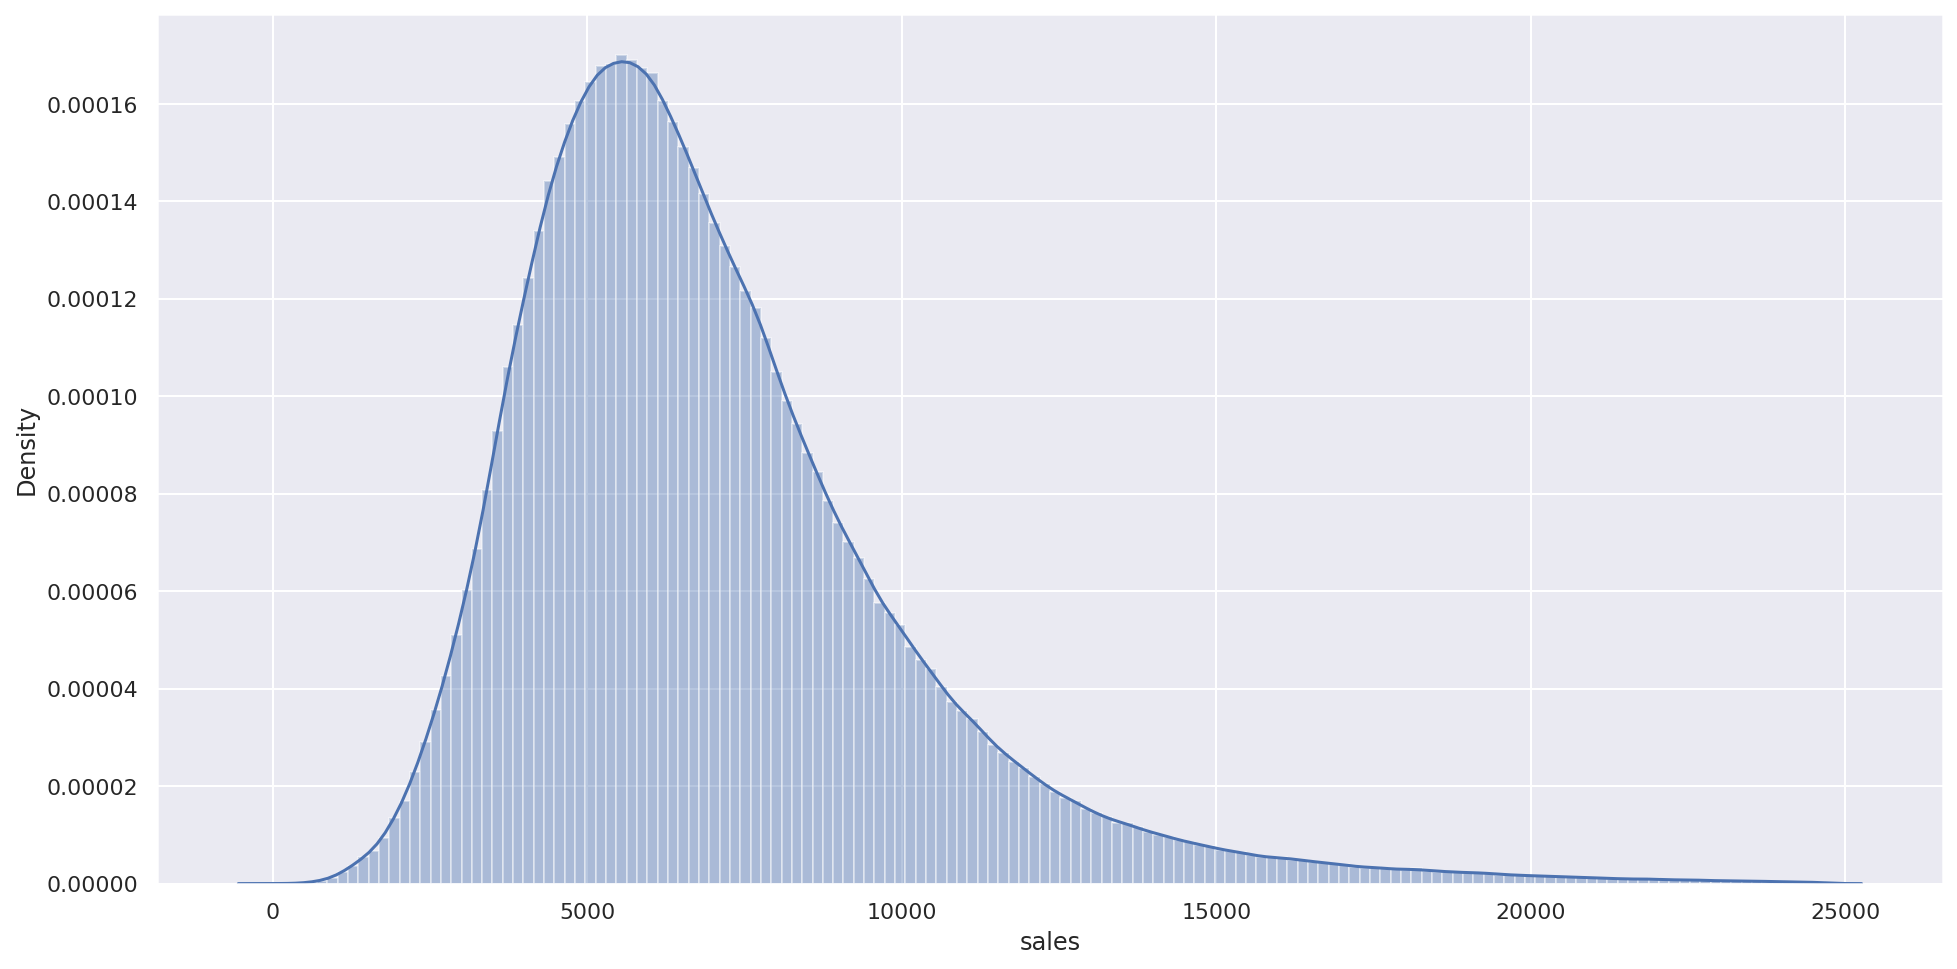

In [59]:
sns.distplot( df4['sales'], bins=150 );

### 4.1.2. Numerical Variable

In [60]:
# select numerical columns - fast method
numeric_cols = [cname for cname in df4.columns if df4[cname].dtype in ['int64', 'float64']]
num_attributes = df4[numeric_cols]

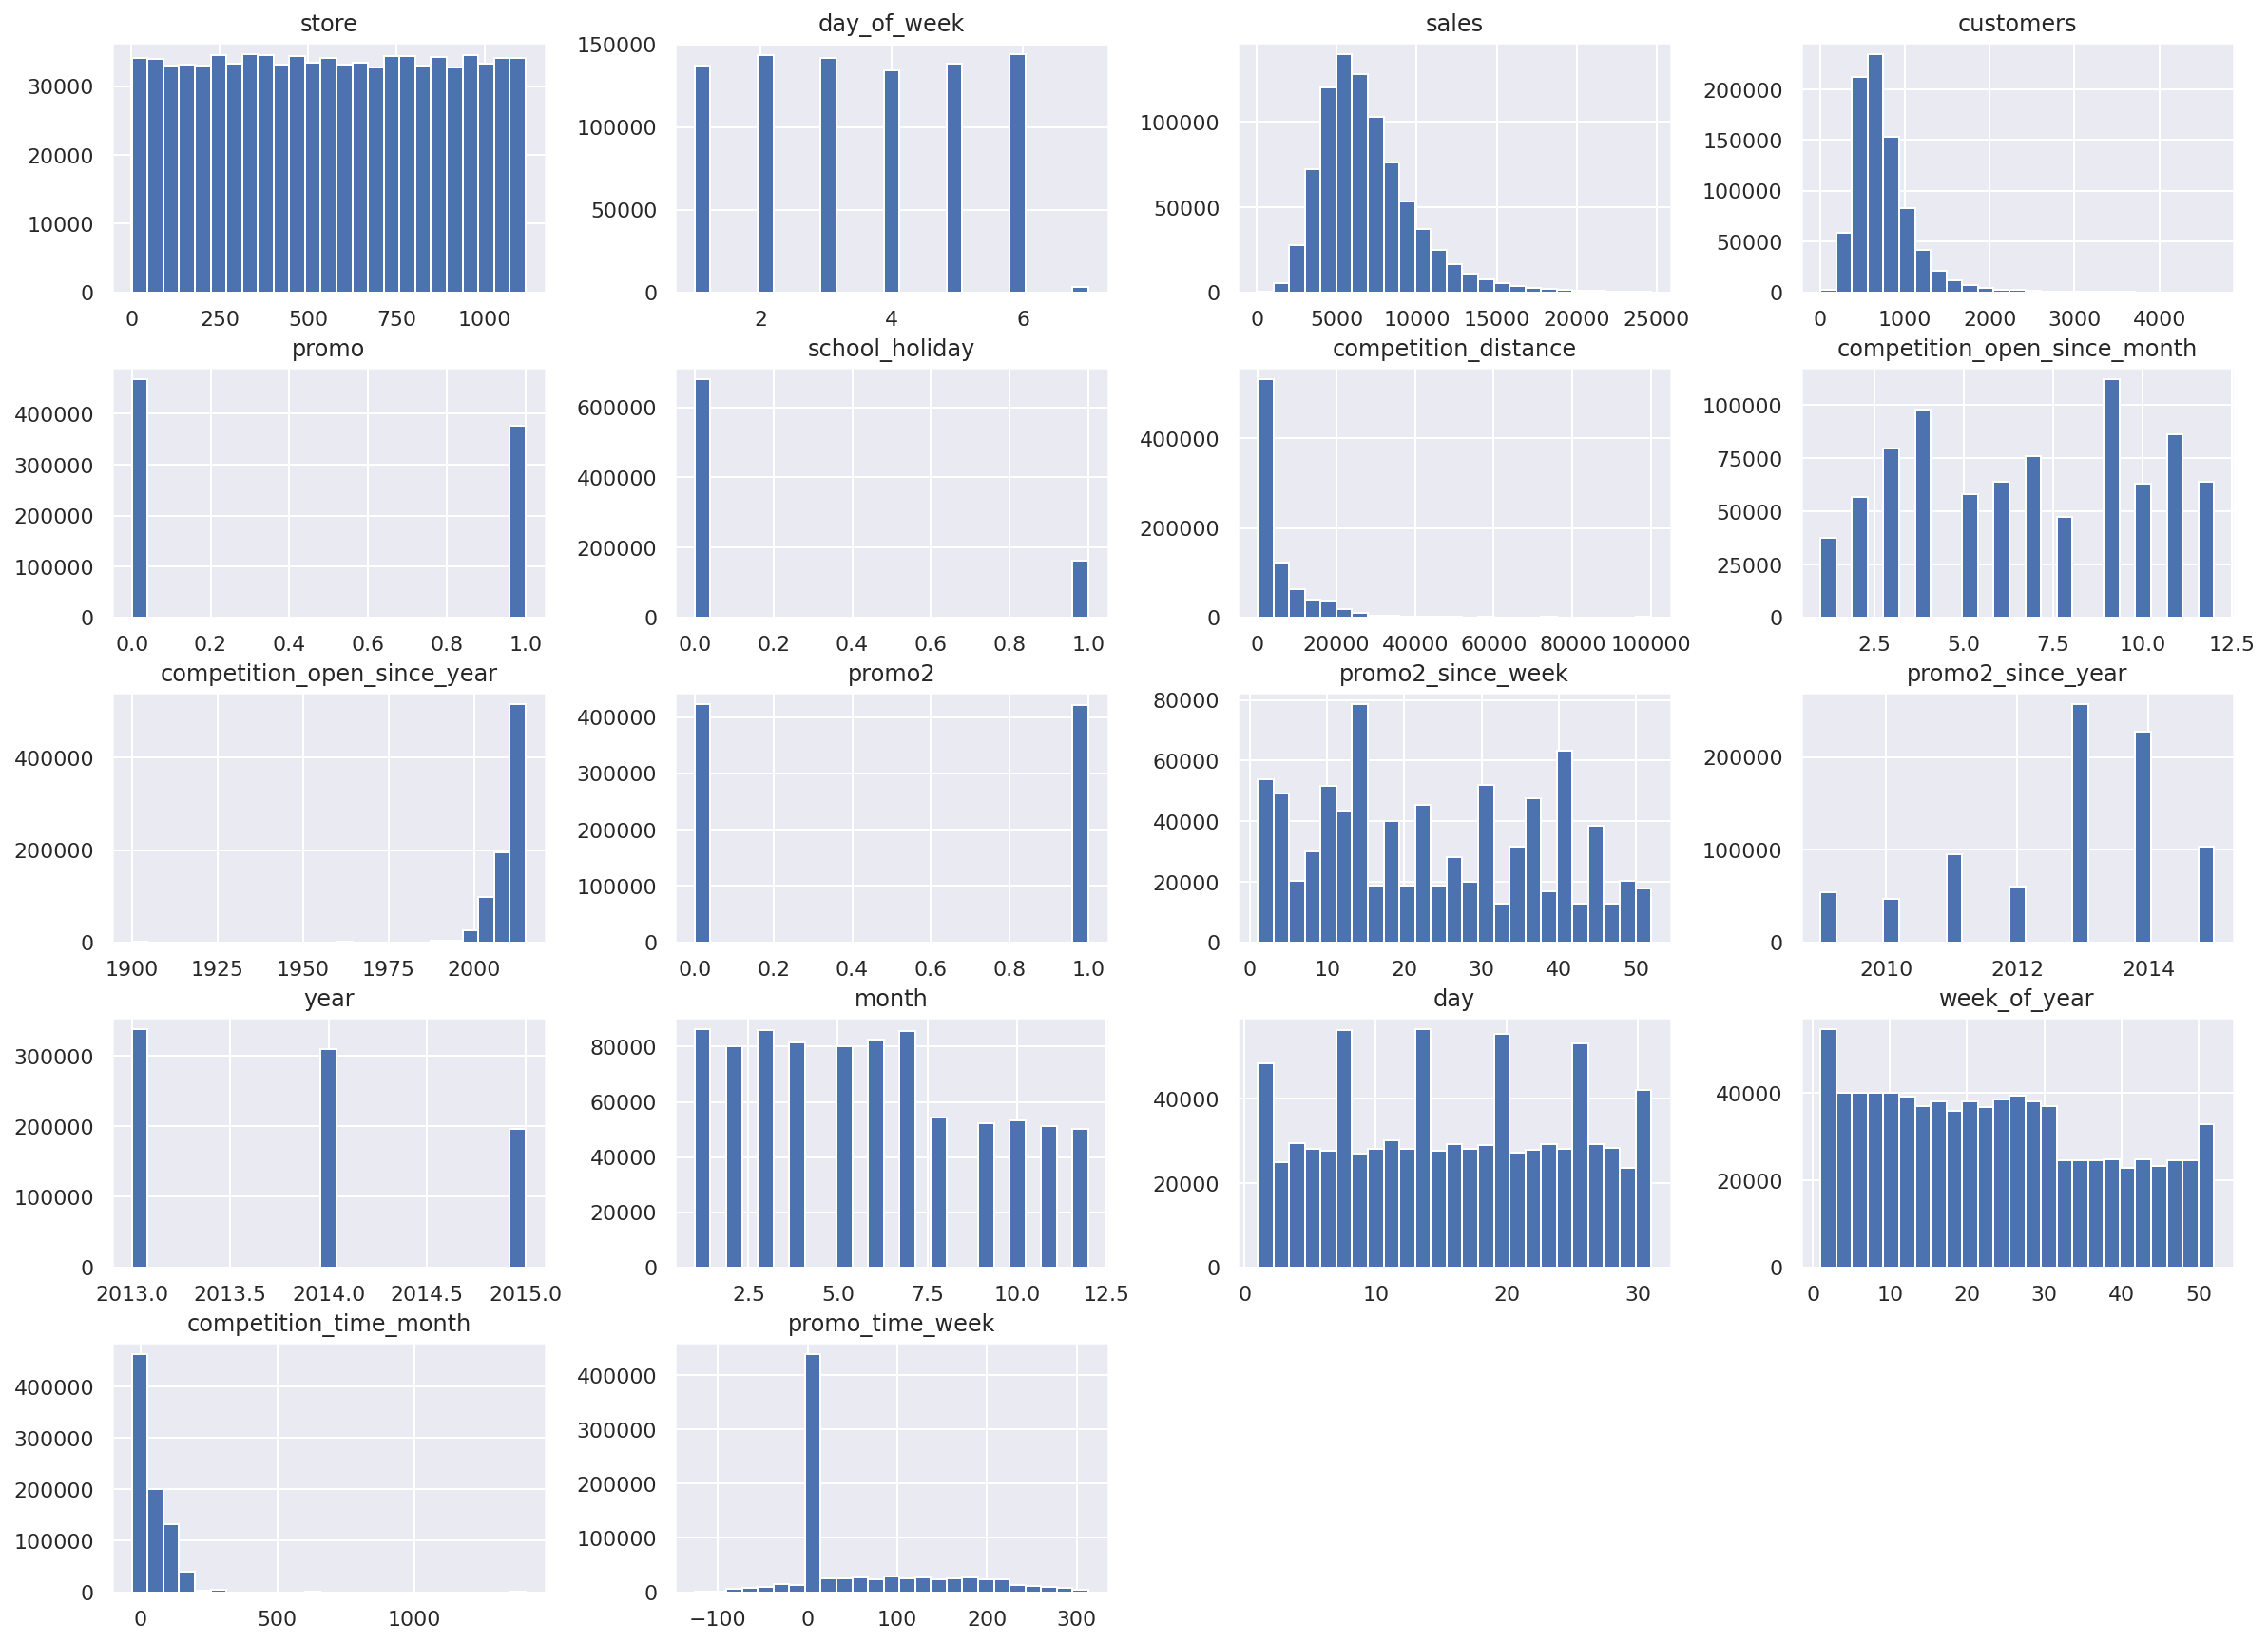

In [61]:
# generate histogram for all numerical variables
num_attributes.hist( bins=25, figsize=(20,15) );

### 4.1.3. Categorical Variable

In [62]:
# select categorial columns - fast method
categorical_cols = [cname for cname in df4.columns if df4[cname].dtype == "object"]
cat_attributes = df4[categorical_cols]

In [63]:
cat_attributes.head()

state_holiday store_type assortment year_week
0   regular_day          c      basic   2015-30
1   regular_day          a      basic   2015-30
2   regular_day          a      basic   2015-30
3   regular_day          c   extended   2015-30
4   regular_day          a      basic   2015-30

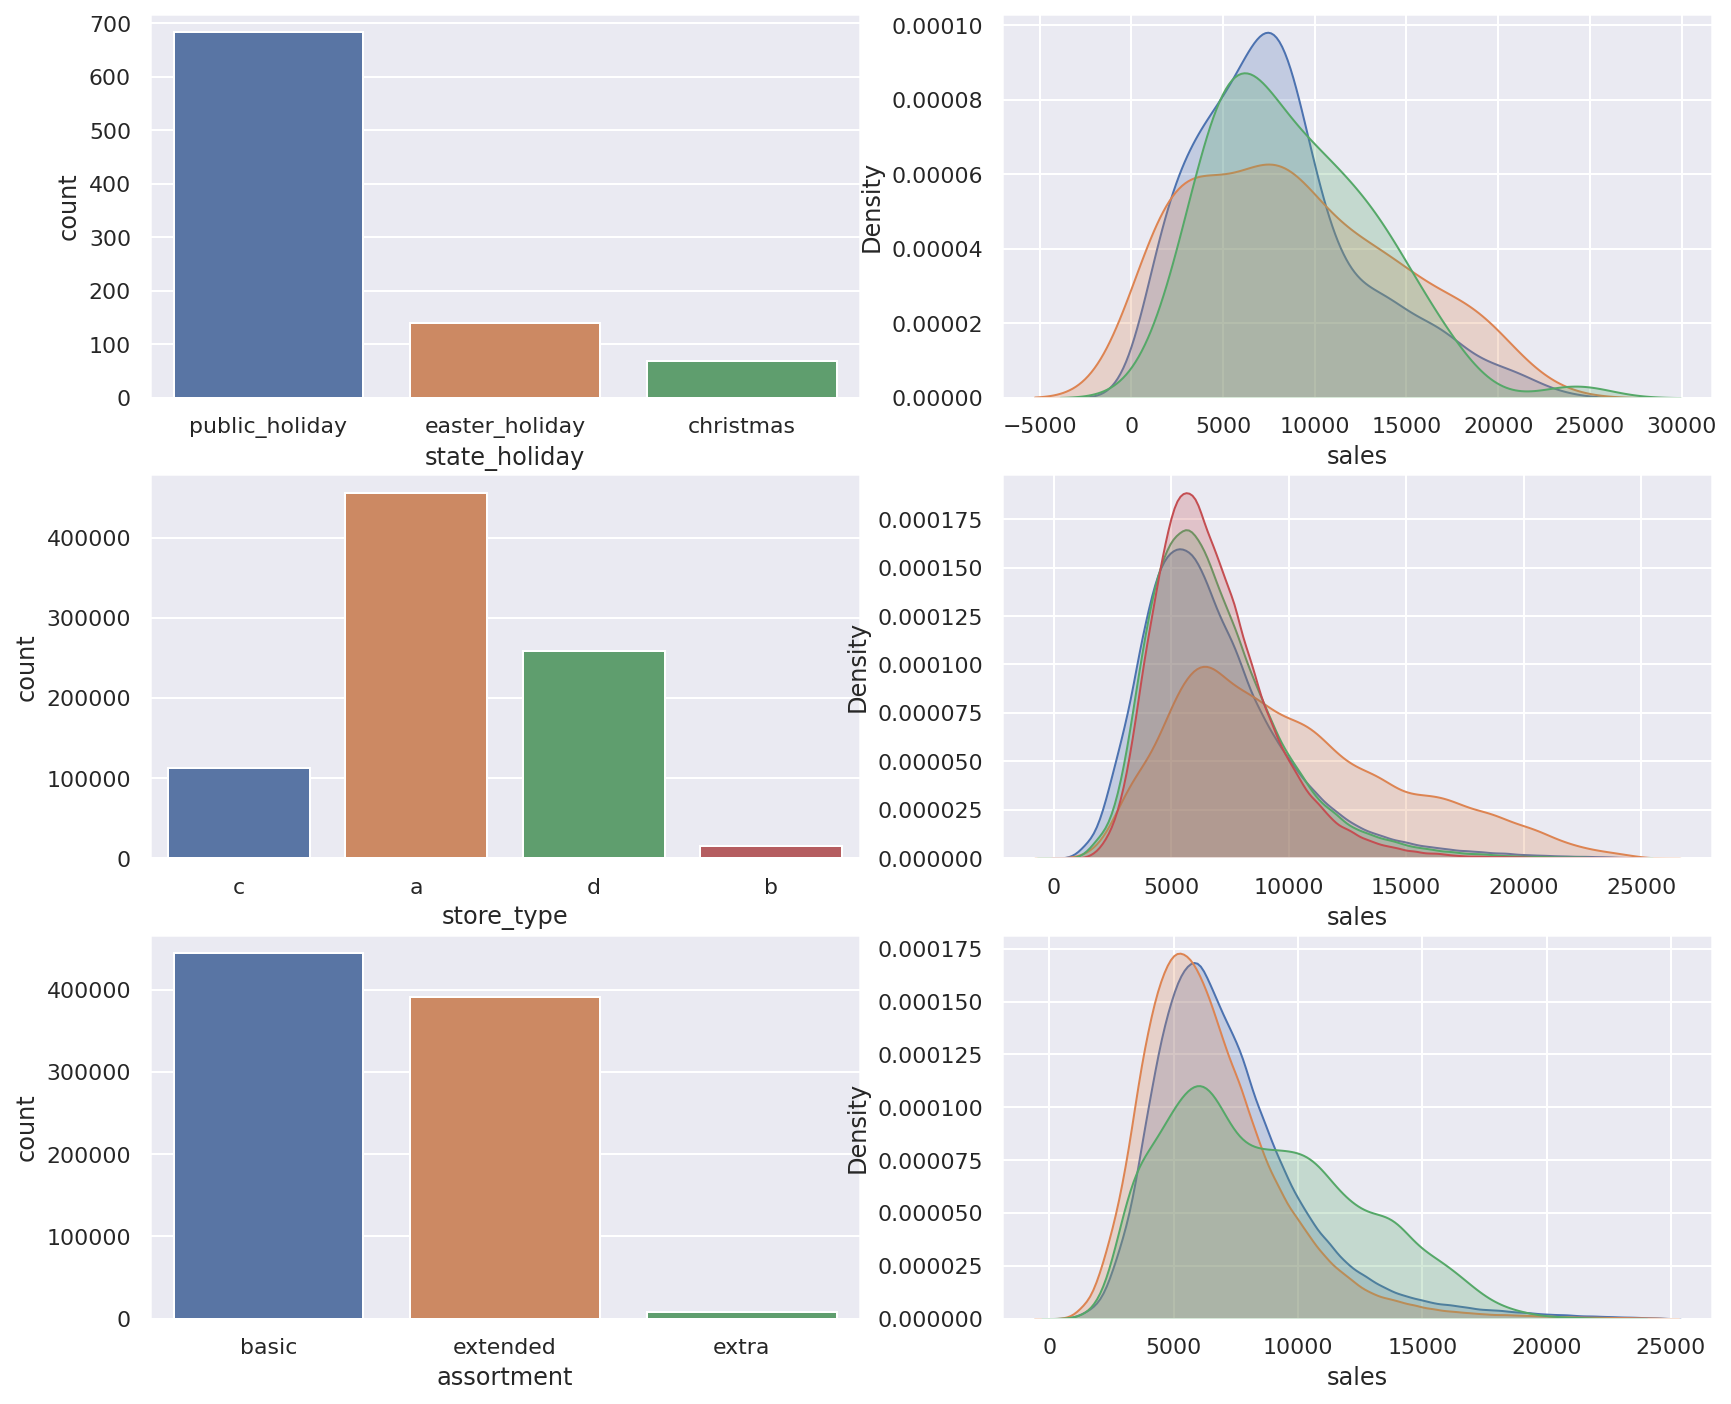

In [64]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(14, 12))

# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analysis

### H1. Stores with bigger Assortment should sell more.
**FALSE** Stores with BIGGER ASSORTMENT sell LESS.

Comentários:
O resultado da análise é um insight pois as lojas com maior sortimento vendem menos, ou seja, é contraintuitivo.

A variável assortment explica dois tipos de comportamento, portanto pode ser relevante para o modelo. Relevância baixa.

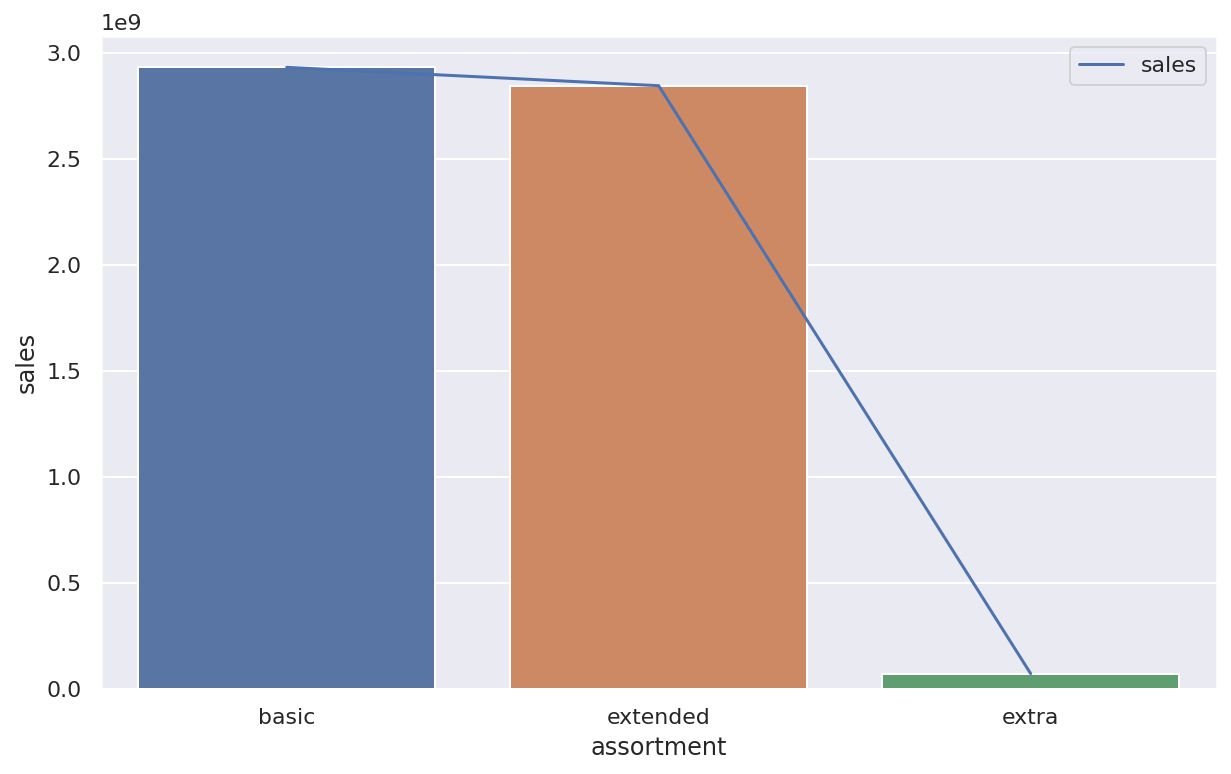

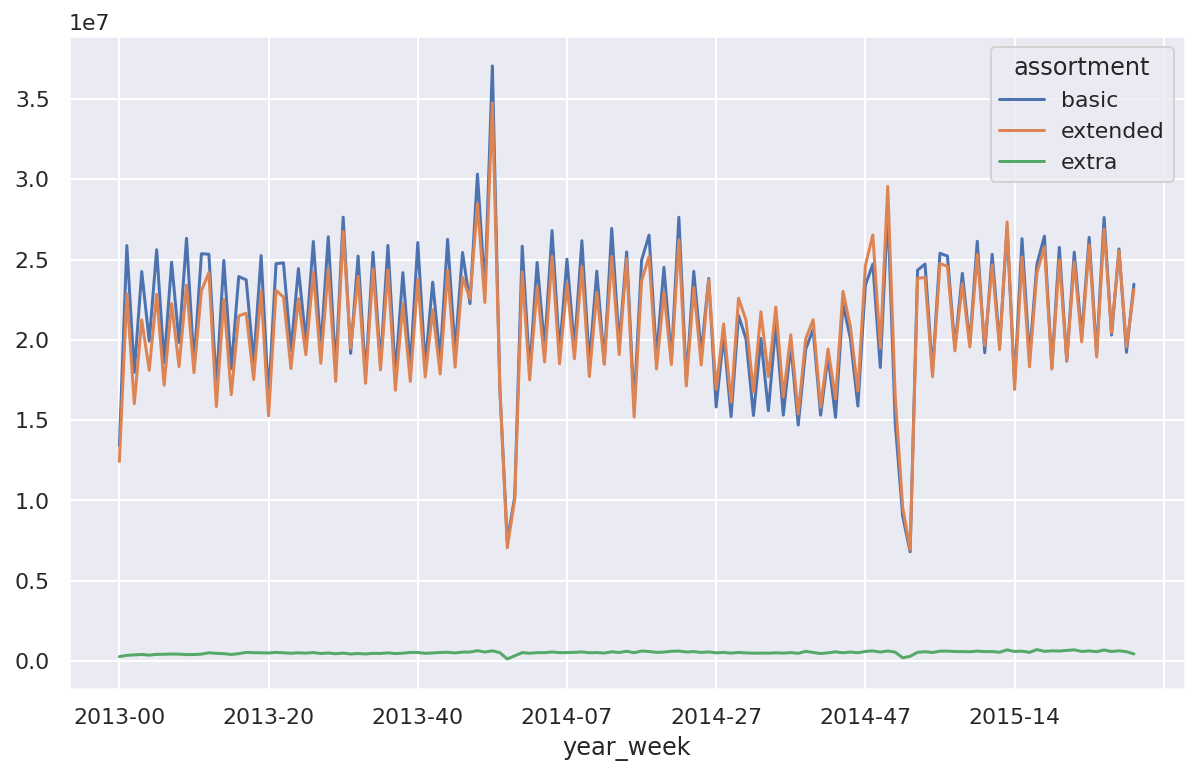

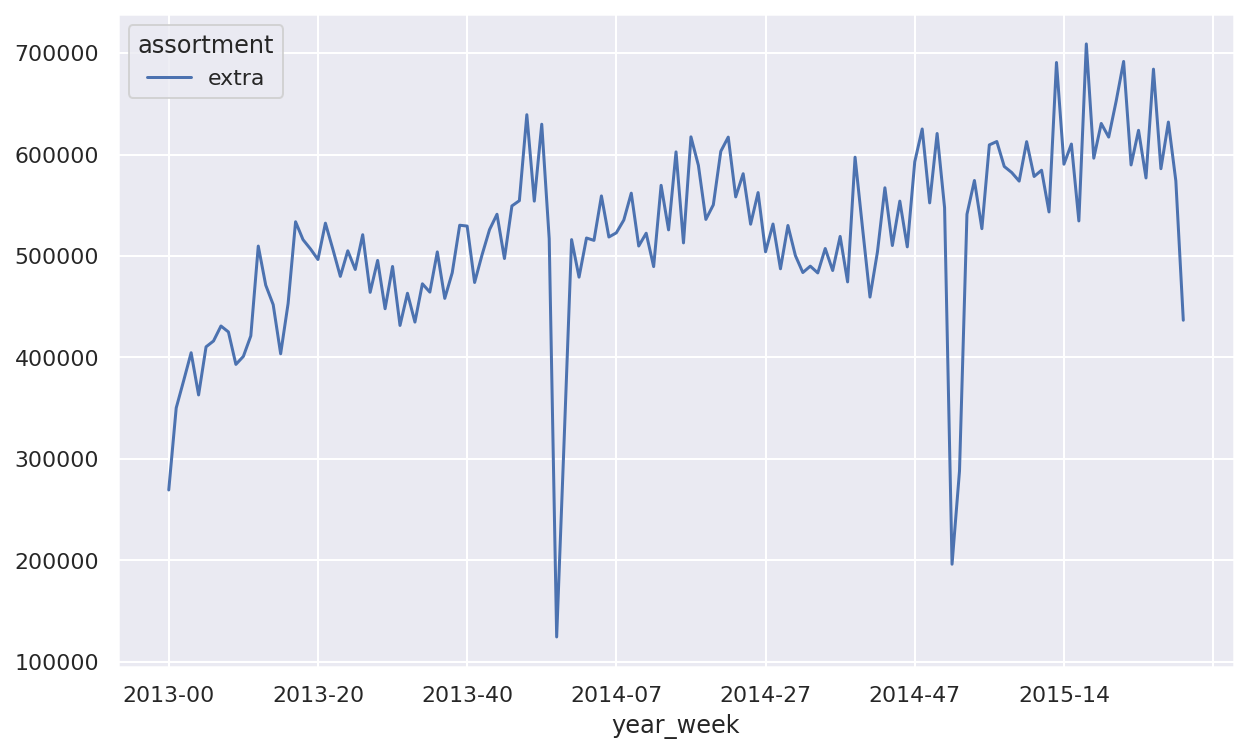

In [65]:
# plot the sum of sales by assortment.
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
aux1.plot( figsize=(10,6) )
sns.barplot( x='assortment', y='sales', data=aux1);

# sum of all sales by assortment and by year_week.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()

# pivot for year_week as line (index), assortment types as columns and sales as values.
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()
aux3.plot( figsize=(10,6) )

# plot the assortment type 'extra' in order to check its behaviour.
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales').plot( figsize=(10,6) );

# Assumption based on the available data description: big assortment = 'extra'.
# After the graphs analysis we can conclude that big assortment (extra) does not sell more than the other ones.
# Therefore we can claim that the Hypothesis H1 is not valid (false).

In [66]:
# sum of all sales by assortment and by year_week.
# remember: aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.head()

year_week assortment     sales
0   2013-00      basic  13408905
1   2013-00   extended  12425669
2   2013-00      extra    269404
3   2013-01      basic  25870719
4   2013-01   extended  22866520

In [67]:
# aux3 contains the pivot made above for year_week as line (index), assortment types as columns and sales as values.
# remember: aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()

assortment     basic  extended   extra
year_week                             
2013-00     13408905  12425669  269404
2013-01     25870719  22866520  350279
2013-02     17970974  16029584  377207
2013-03     24255494  21243431  404662
2013-04     19918809  18104936  363061

### H2. Stores with competition closer should sell less.
**FALSE** Stores with COMPETITION CLOSE sell MORE.

Comentários:
O resultado da análise é um insight pois as lojas com a concorrência mais próxima vendem mais, ou seja, é totalmente contra o senso comum.

A correlação do método de pearson varia de -1 a 1, sendo que em 1 as variáveis são perfeitamente correlacionadas positivamente e -1 elas tem uma correlação negativa.
O valor de -0,23 indica uma correlação fraca. Pode ser relevante para o modelo, mas de uma maneira mais fraca. Relevância média.

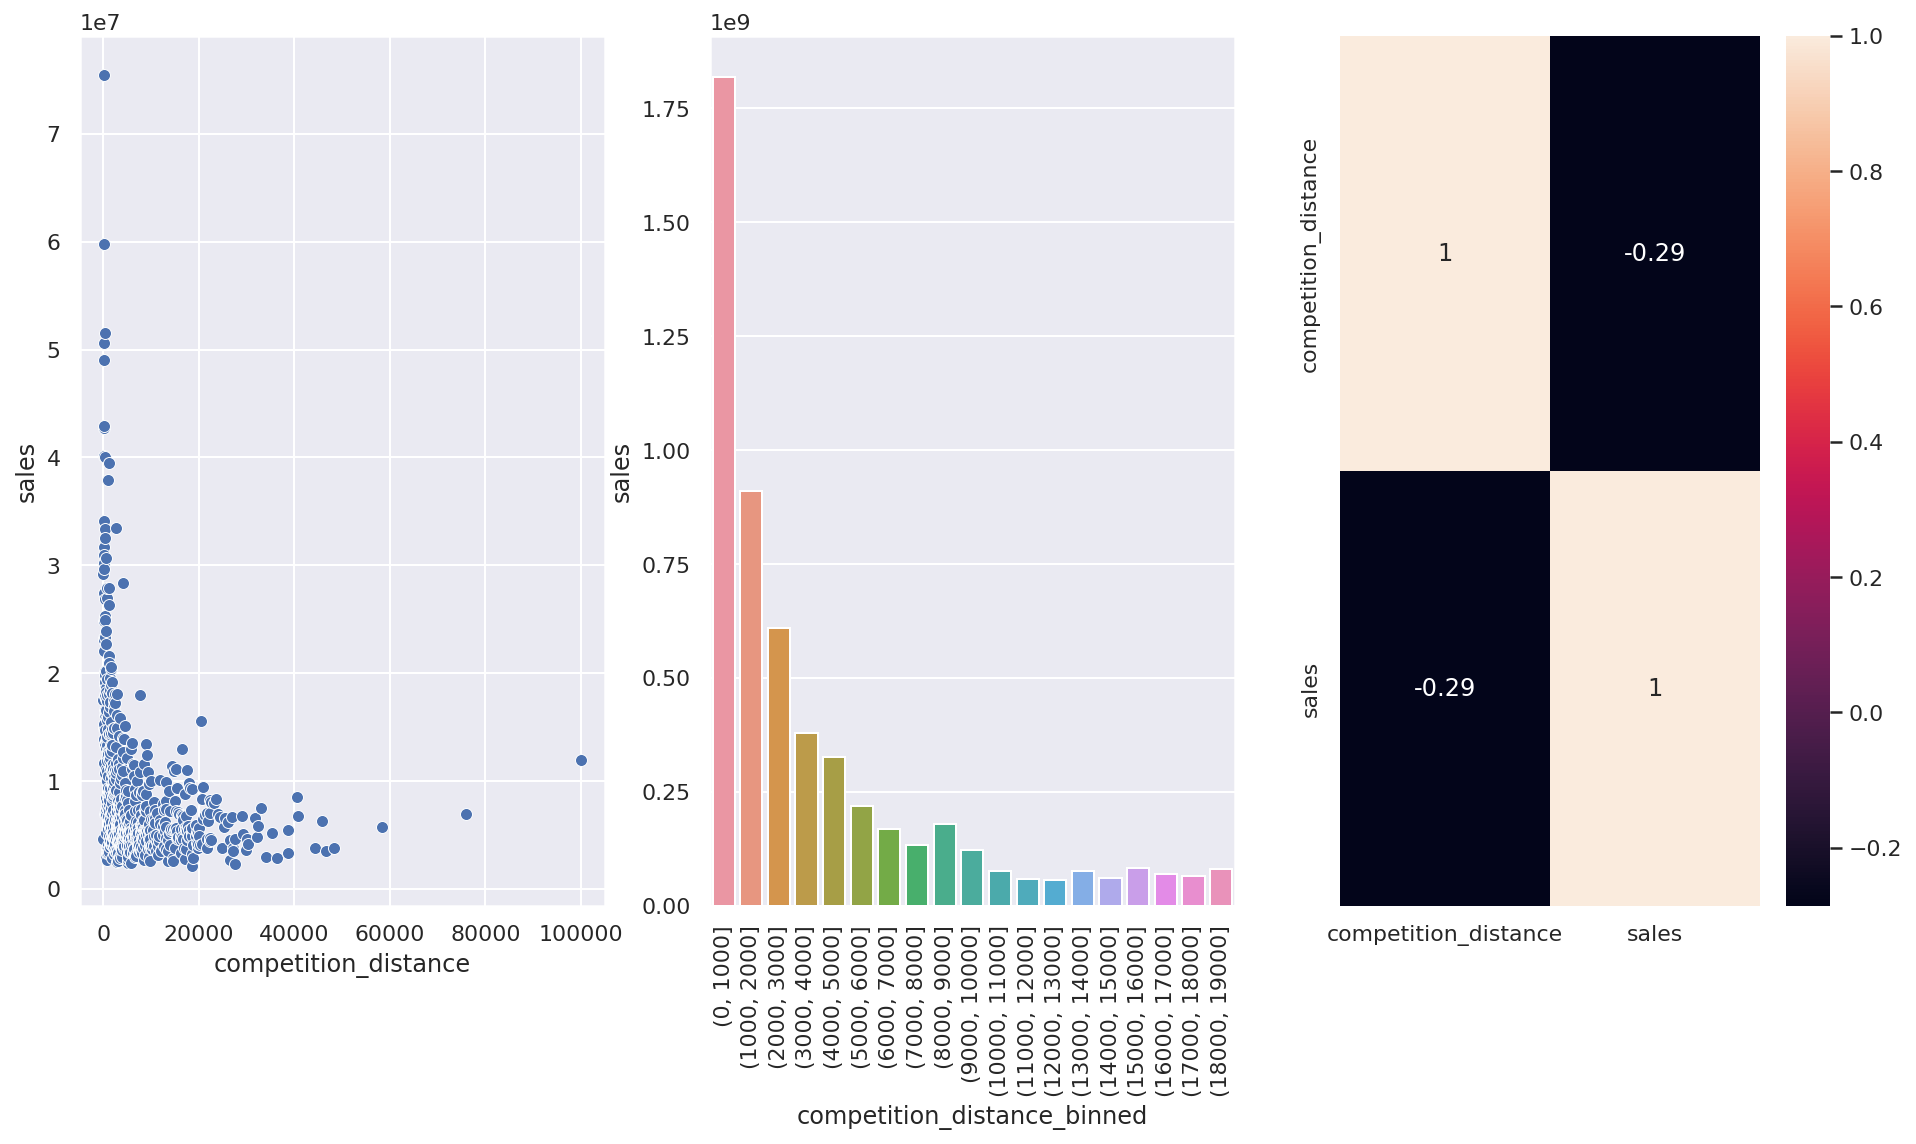

In [68]:
# sum of sales by competition_distance
aux2_1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1 )
# scatter plot competition_distance and sales (aux2_1)
sns.scatterplot( x='competition_distance', y='sales', data=aux2_1)

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2 )
# create bins to group the values for better plot visualization
bins = list( np.arange( 0, 20000, 1000 ) )
# arrange the values to each corresponding group (bins) 
# and store it in the new column 'competition_distance_binned'.
aux2_1['competition_distance_binned'] = pd.cut( aux2_1['competition_distance'], bins=bins )
# sum of sales by competition_distance_binned
aux2_2 = aux2_1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
# plot sum of sales by competition_distance_binned
sns.barplot( x='competition_distance_binned', y='sales', data=aux2_2 );
# axis rotation
plt.xticks( rotation=90 )

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3 )
# correlation weight between competition_distance and sales
sns.heatmap( aux2_1.corr( method='pearson' ), annot=True );

In [69]:
aux2_1.sample(4)

competition_distance     sales competition_distance_binned
568           17,280.0000   5756322              (17000, 18000]
534           14,160.0000   5533037              (14000, 15000]
47               490.0000  22724642                   (0, 1000]
312            4,210.0000   5367788                (4000, 5000]

### H3. Stores with longer time competition should sell more.
**FALSE** Stores with LONGER TIME COMPETITION sell LESS.

Comentários:
O resultado da análise é um insight pois lojas com mais tempo de concorrência vendem menos, ou seja, é contraintuitivo.

Correlação entre o tempo que os competidores começaram e as vendas. Relação de pearson de 0,1. Relevância média.

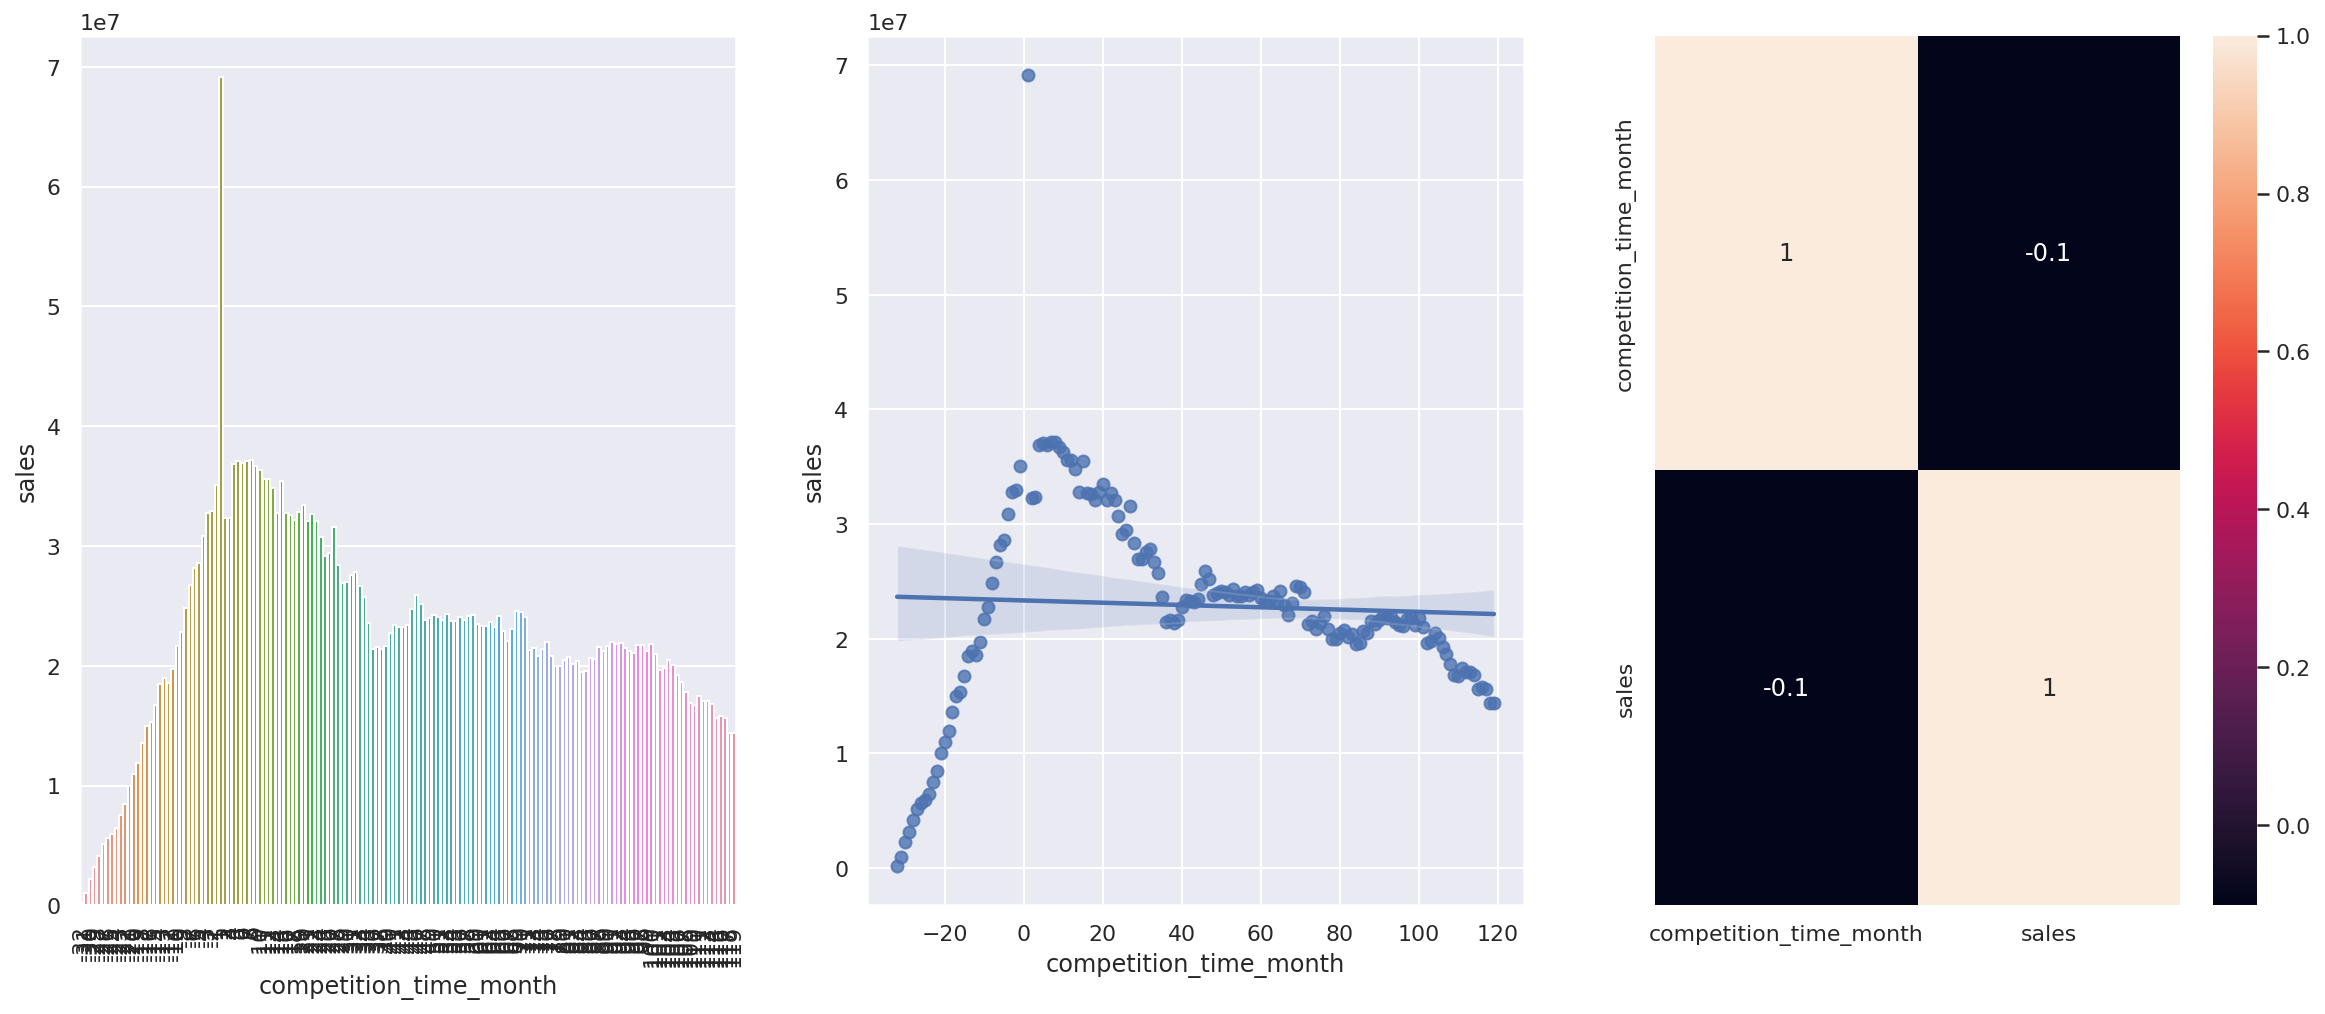

In [70]:
# sum of sales by competition_time_month
aux3_1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()

# Filter values lower than 120 in order to check the first 120 months of competition
# Filter competition time == 0 (competition open in the same month of the sale)
aux3_2 = aux3_1[(aux3_1['competition_time_month'] < 120) & ( aux3_1['competition_time_month'] != 0 )]

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1)
# bar plot
sns.barplot( x='competition_time_month', y='sales', data=aux3_2);
# rotate x axis labels
plt.xticks( rotation=90 );

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2)
# plot regplot
sns.regplot( x='competition_time_month', y='sales', data=aux3_2);

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3)
sns.heatmap( aux3_1.corr(method='pearson'), annot=True);

# competition time month negative values mean that the competition will open a new store soon in the future.
# the bar plot shows that competition time month values near to zero represents more sales than bigger competition time month.

### **H4.** Stores with longer Sale (promo) should sell more.
**FALSE** Stores with longer Sale (promo) sell less after some promo period.

Comentários:
O resultado da análise pode ser um insight pois as lojas com mais tempo de promoção vendem menos, ou seja, é contrário ao que normalmente se acredita.

Relação de pearson: 0,029. Provavelmente será uma variável não relevante para o modelo. Relevância baixa.

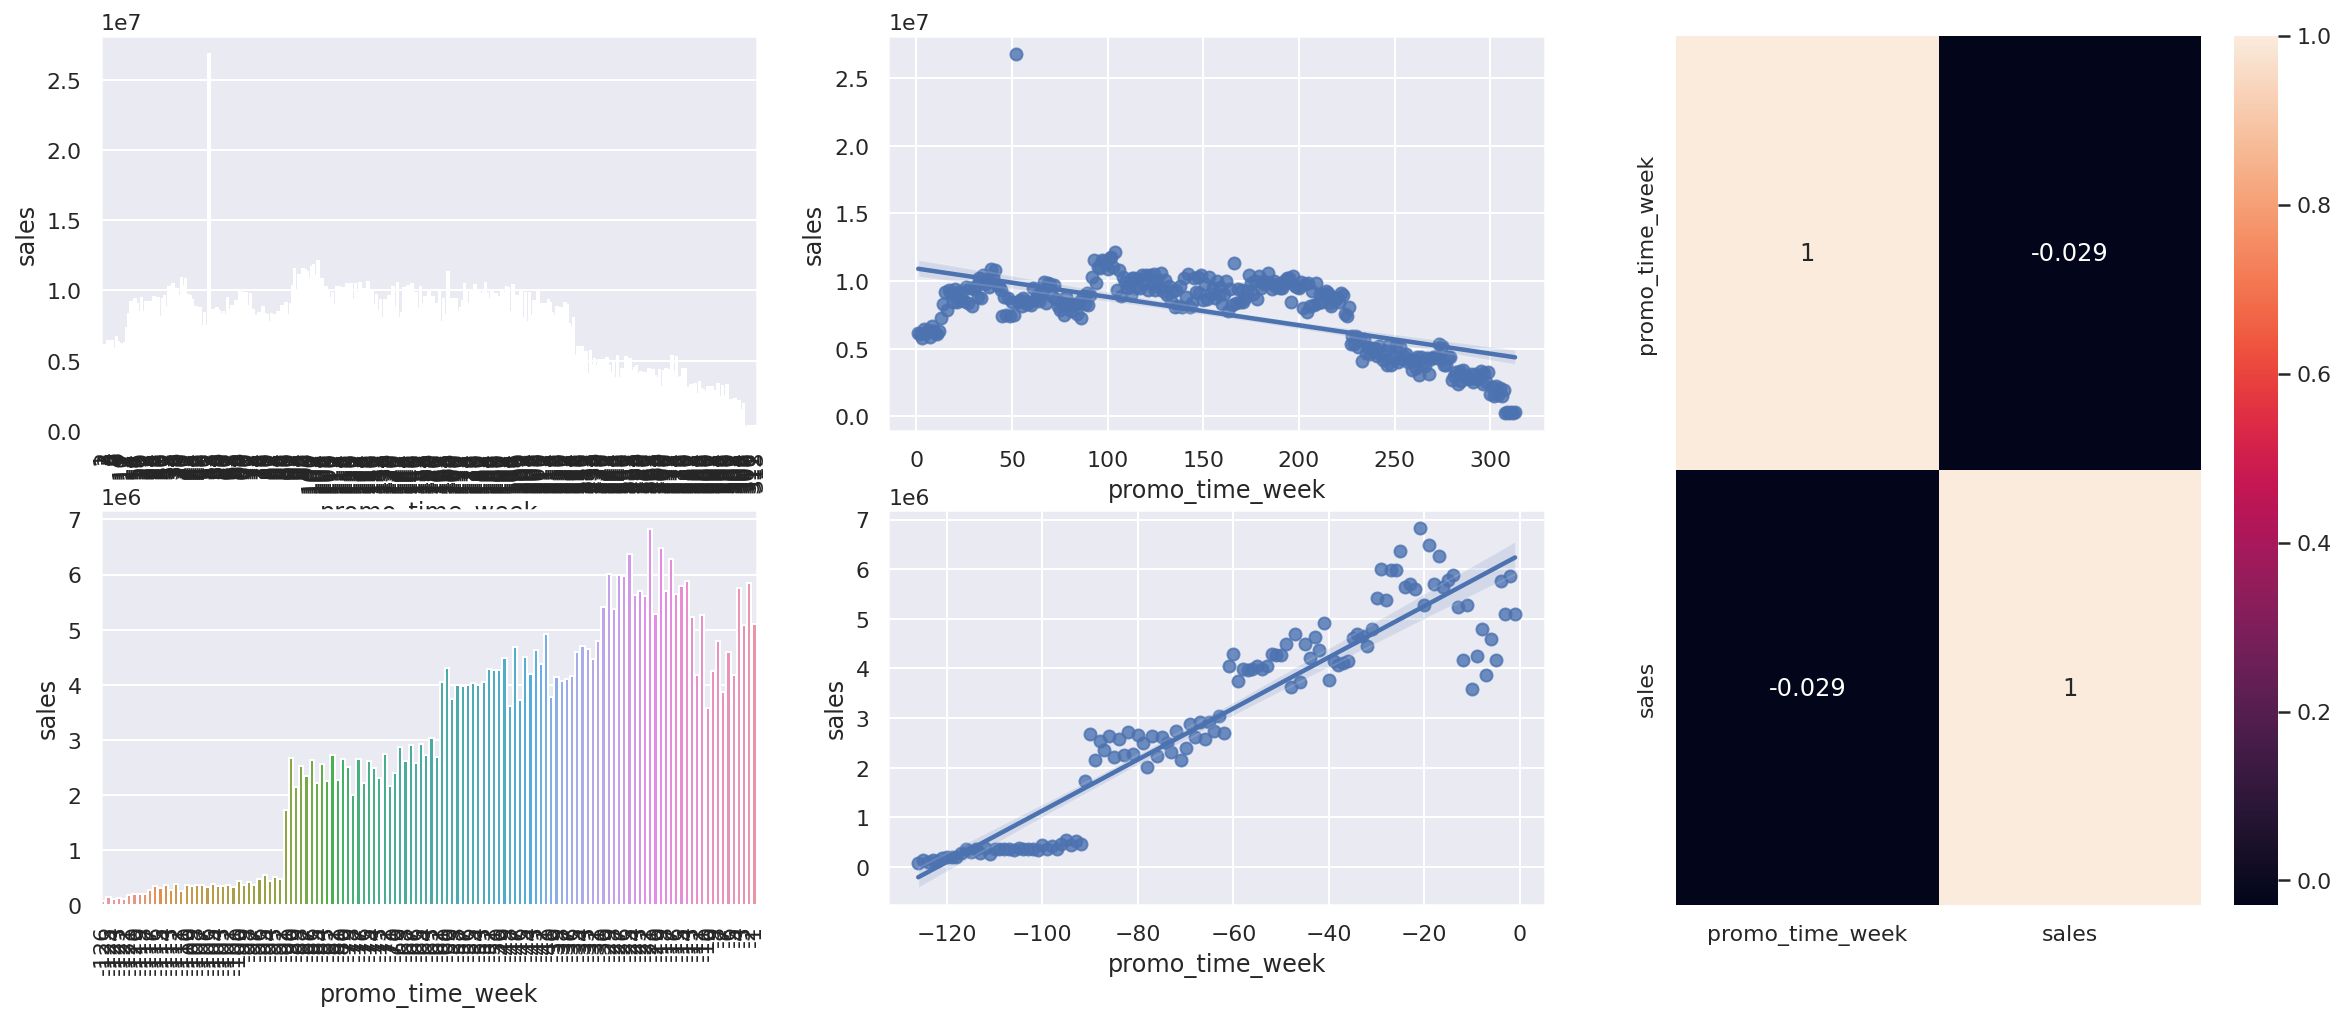

In [71]:
# two periods of promo: the standard (promo) and the extended (promo 2).
# promo_time_week > 0 means the sale at that date was done in the promo 2 period (extended).
# promo_time_week < 0 means the sale at that date was done in the standard promo period.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# Grid spec - plot
grid = gridspec.GridSpec( 2, 3)

# sum of sales by promo_time_week
aux4_1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# sort the data into extended promo period (promo2).
plt.subplot( grid[0,0] )
aux4_2 = aux4_1[aux4_1['promo_time_week'] > 0] # promo extended (promo 2)
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_2 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_2 );

# sort the data into standard promo period.
plt.subplot( grid[1,0] )
aux4_3 = aux4_1[aux4_1['promo_time_week'] < 0] # promo standard
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_3 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_3 );

# Correlation strength - heatmap
plt.subplot( grid[:,2] )
sns.heatmap( aux4_1.corr( method='pearson'), annot=True );

### **H5.** Stores with more Sale (promo) days should sell more.

**TRUE** Stores with more Sale (promo) days sell more.

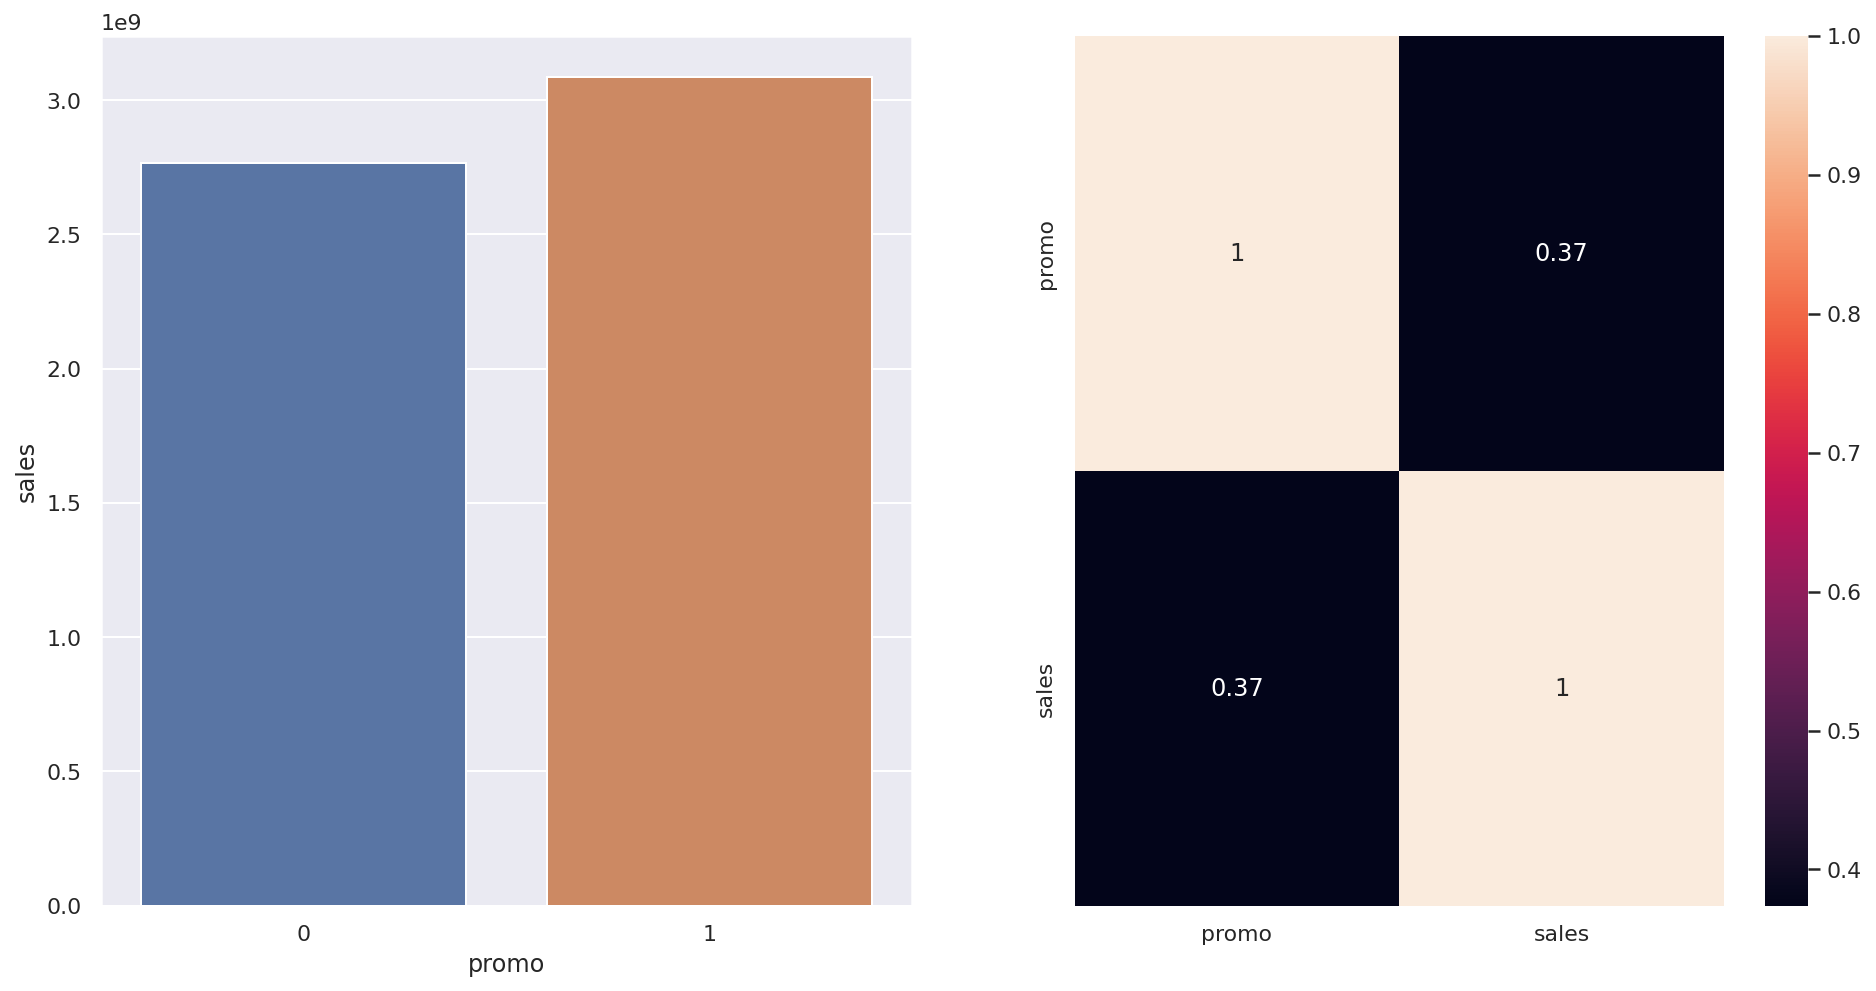

In [72]:
# promo, sales
# set up plot
plt.subplots(1, 2, figsize=(16,8))

# barplot
aux5_1 = df4[['promo', 'sales']].groupby( 'promo' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='promo', y='sales', data=aux5_1);

# heatmap
plt.subplot(1,2,2)
aux5_4 = df4[['promo', 'sales']]
sns.heatmap(aux5_4.corr(method='pearson'), annot=True);

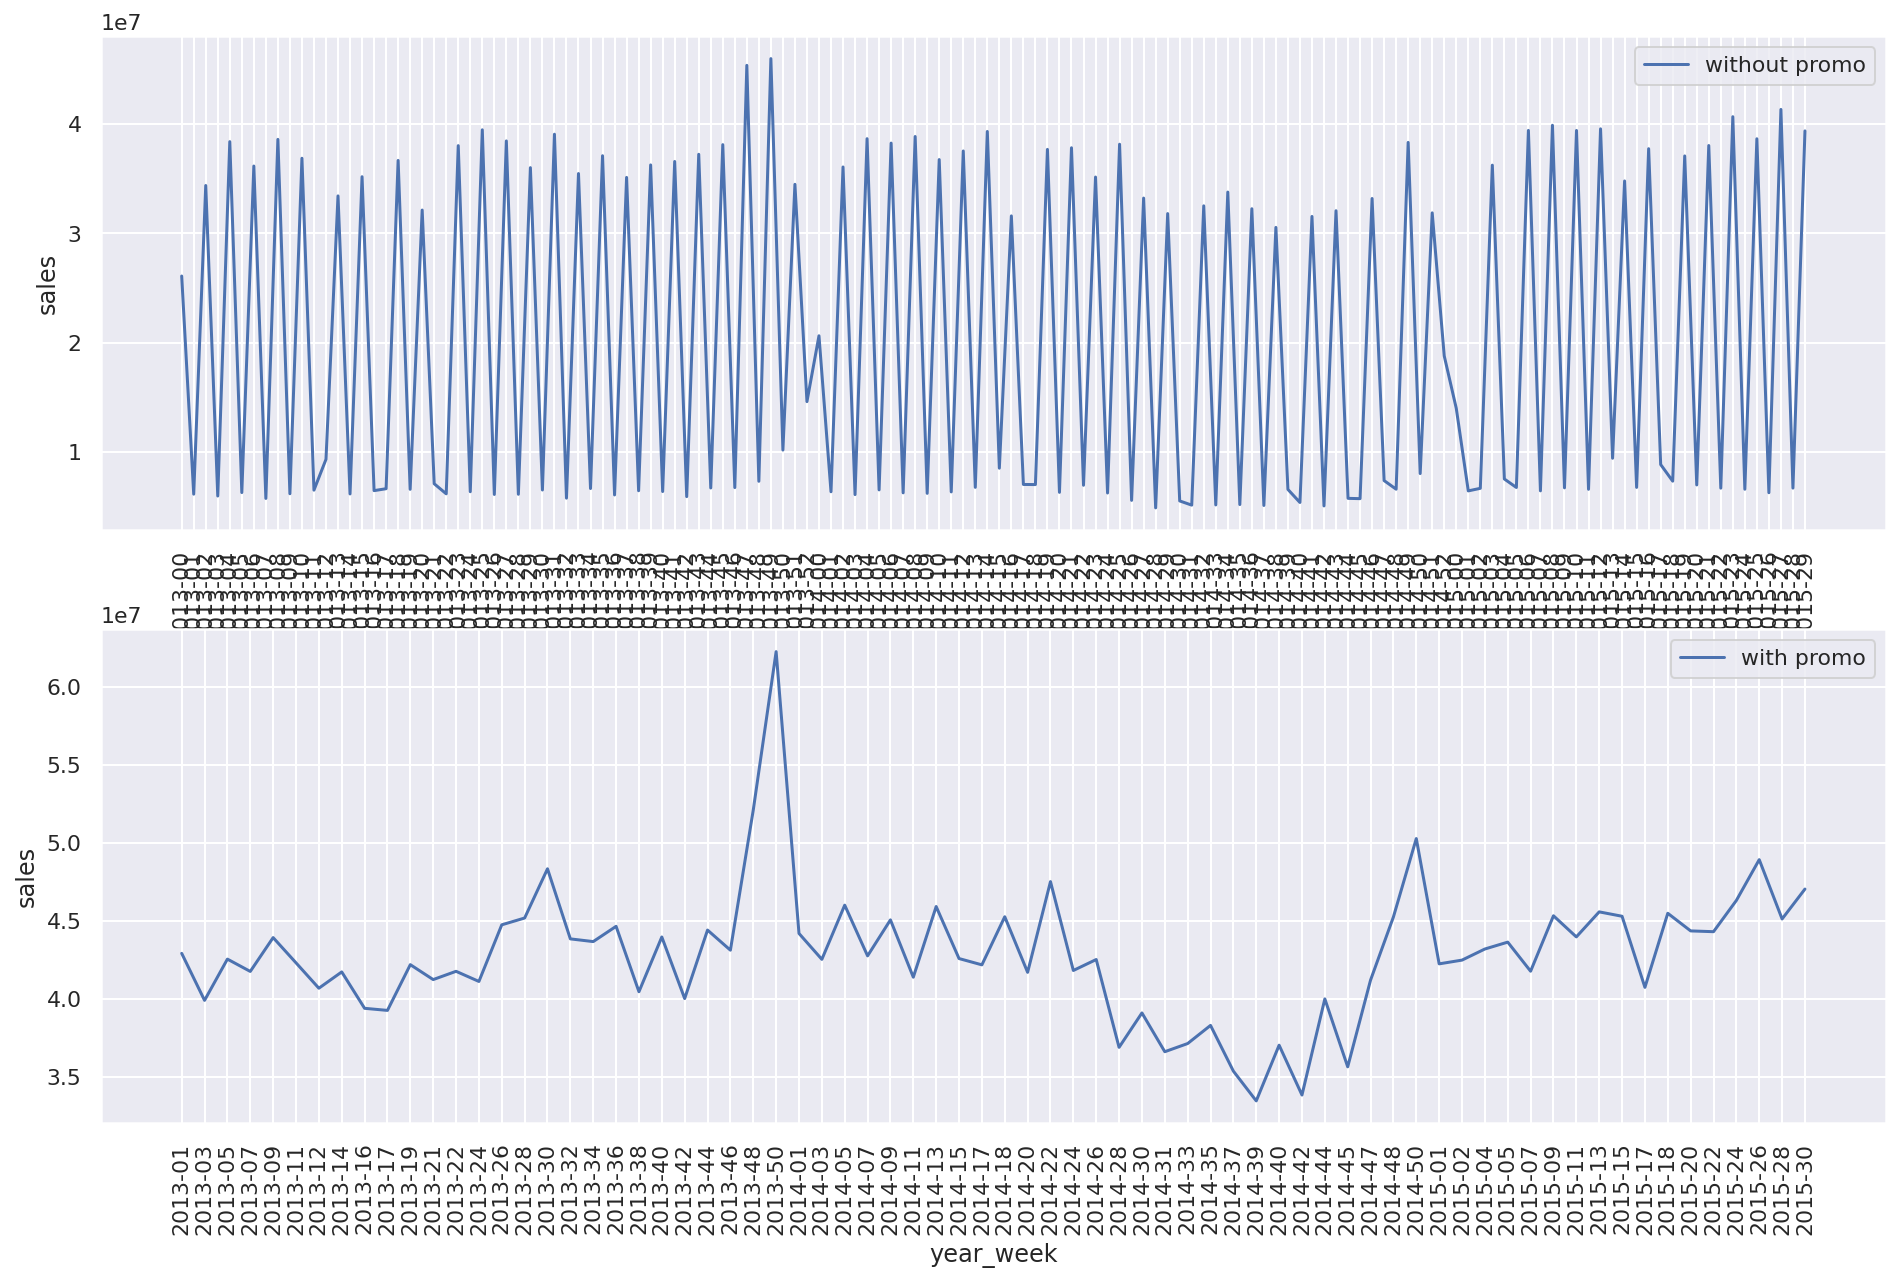

In [73]:
# time series promo, year_week and sales
# without promo
aux5_2 = df4[df4['promo'] == 0][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux5_2 = aux5_2.set_index('year_week')
# set up plot
plt.subplots(2, 1, figsize=(16,10))
# lineplot promo == 0 - 1st plot
plt.subplot(2, 1, 1)
sns.lineplot(data=aux5_2['sales'], label='without promo');
plt.xticks(rotation=90);

# with promo
aux5_3 = df4[df4['promo'] == 1][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux5_3 = aux5_3.set_index('year_week')
# lineplot promo == 1 - 2nd plot
plt.subplot(2, 1, 2)
sns.lineplot(data=aux5_3['sales'], label='with promo');
plt.xticks(rotation=90);

### **H6.** Stores with more consecutive Sale (promo) should sell more.
**FALSE** Stores with more consecutive Sale sell less.

Comentários:
O resultado da análise pode ser um insight pois a análise demonstra que lojas com mais promoções consecutivas vendem menos, ou seja, contrário ao senso comum de que mais promoções representam mais vendas.

Comportamento similar das vendas durante ambos os períodos de promoção tradicional e de promoção tradicional e extendida (promo2), exceto pelo período da semana 26 de 2014 até aproximadamente as últimas semanas de 2014. Relevância baixa.

In [74]:
# sum of sales by promo and promo2.
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

promo  promo2       sales
0      0       0  1475691454
1      0       1  1288667258
2      1       0  1615720284
3      1       1  1469680185

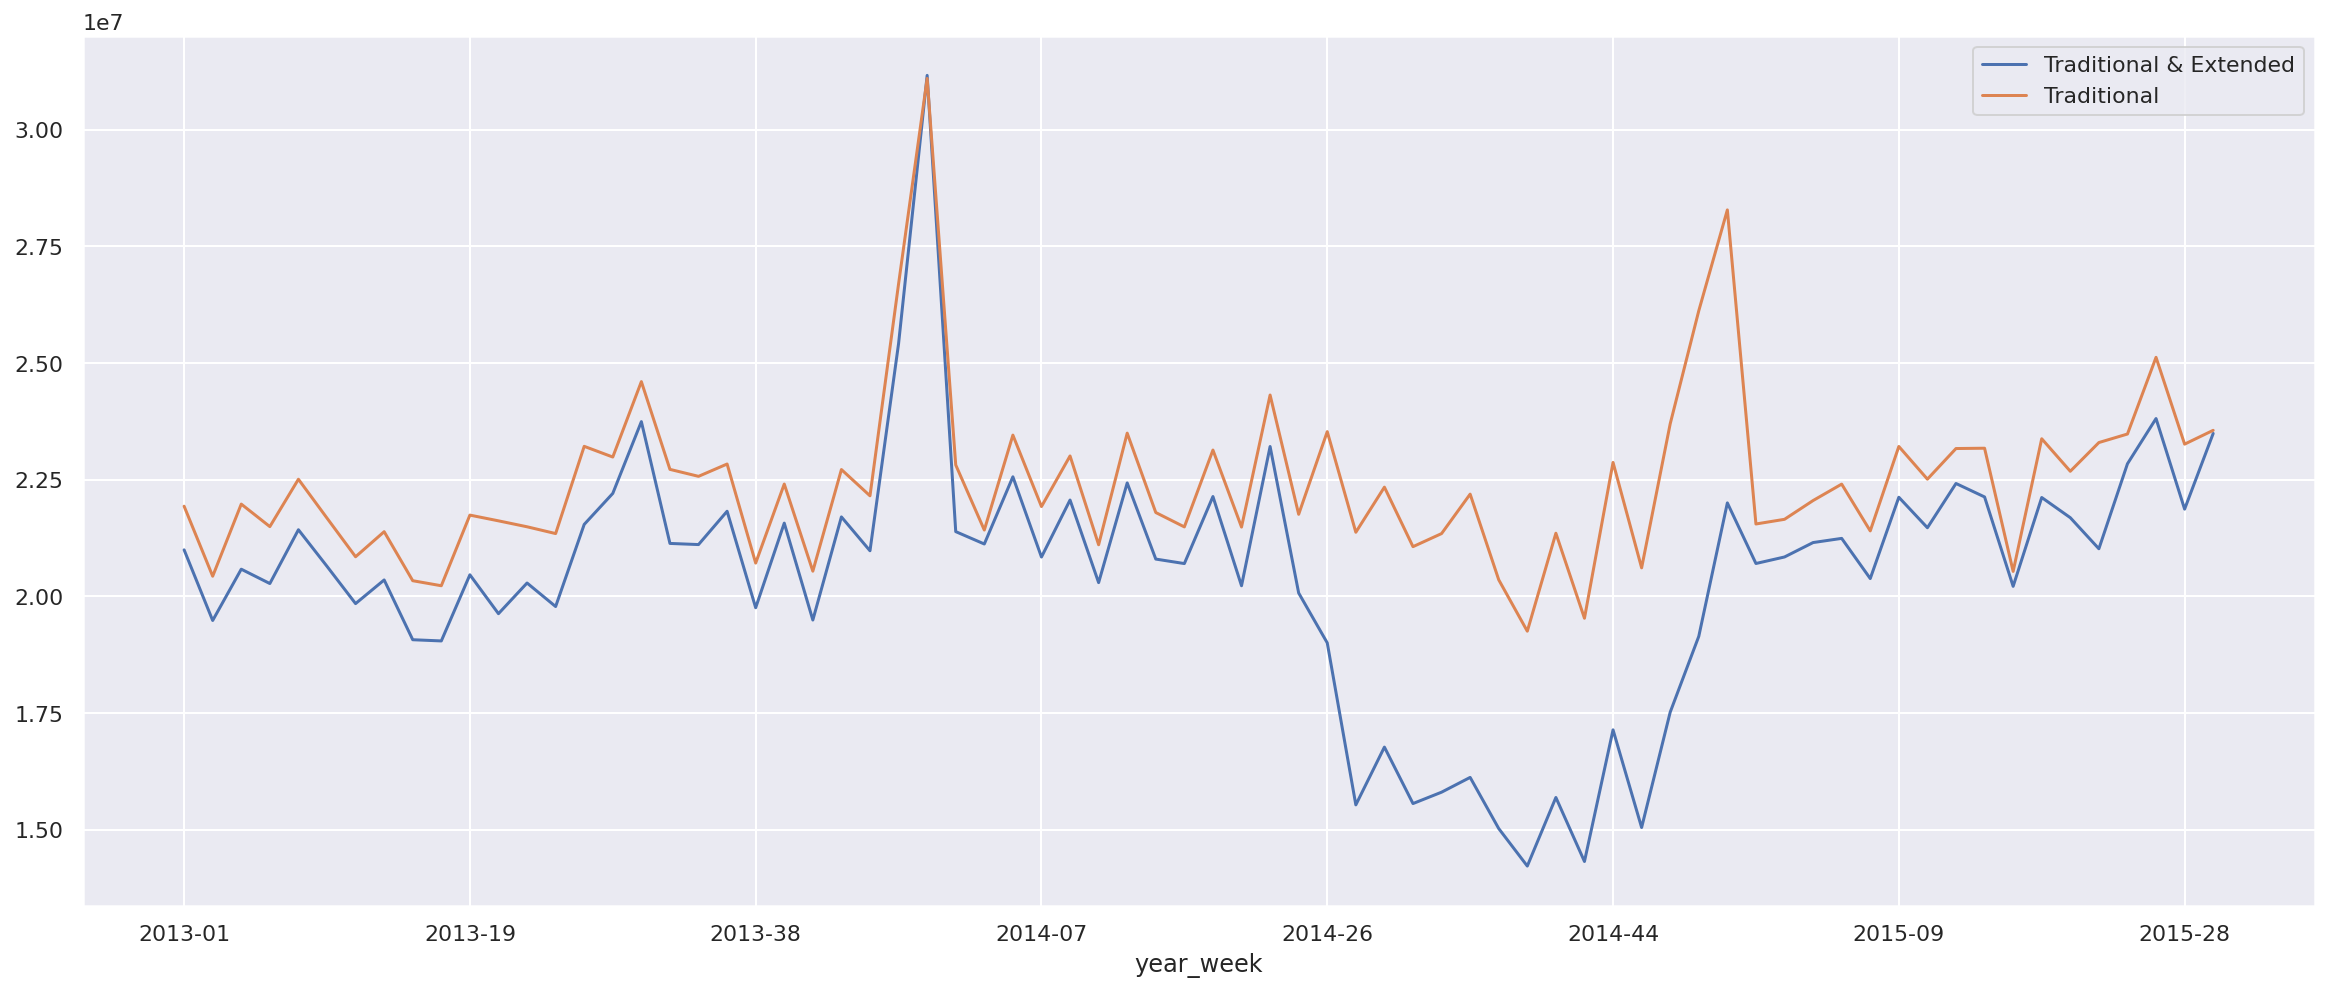

In [75]:
# Check stores sales by year_week (sales in time) with respect to promo and promo2
aux6_1 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux6_1 = aux6_1.set_index('year_week')
ax = aux6_1.plot( figsize=(20,8))

# Only stores with promo
aux6_2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()

aux6_2.plot( ax=ax)

ax.legend( labels=['Traditional & Extended', 'Traditional'])

In [76]:
aux6_1.head()

sales
year_week          
2013-01    20995409
2013-03    19481514
2013-05    20580811
2013-07    20273185
2013-09    21426145

### **H7.** Stores open on Christmas time should sell more.
**False** Stores open on Christmas sell less.

Comentários:
Esta análise não representa um insight pois a informação de que as vendas no período do natal são menores já são normalmente de conhecimento do time de negócios.

Será uma variável relevante para o modelo, pois as vendas nos feriados cresceram de 2013 para 2014 e diminuiram de 2014 para 2015. Relevância média.

<AxesSubplot:xlabel='year', ylabel='sales'>

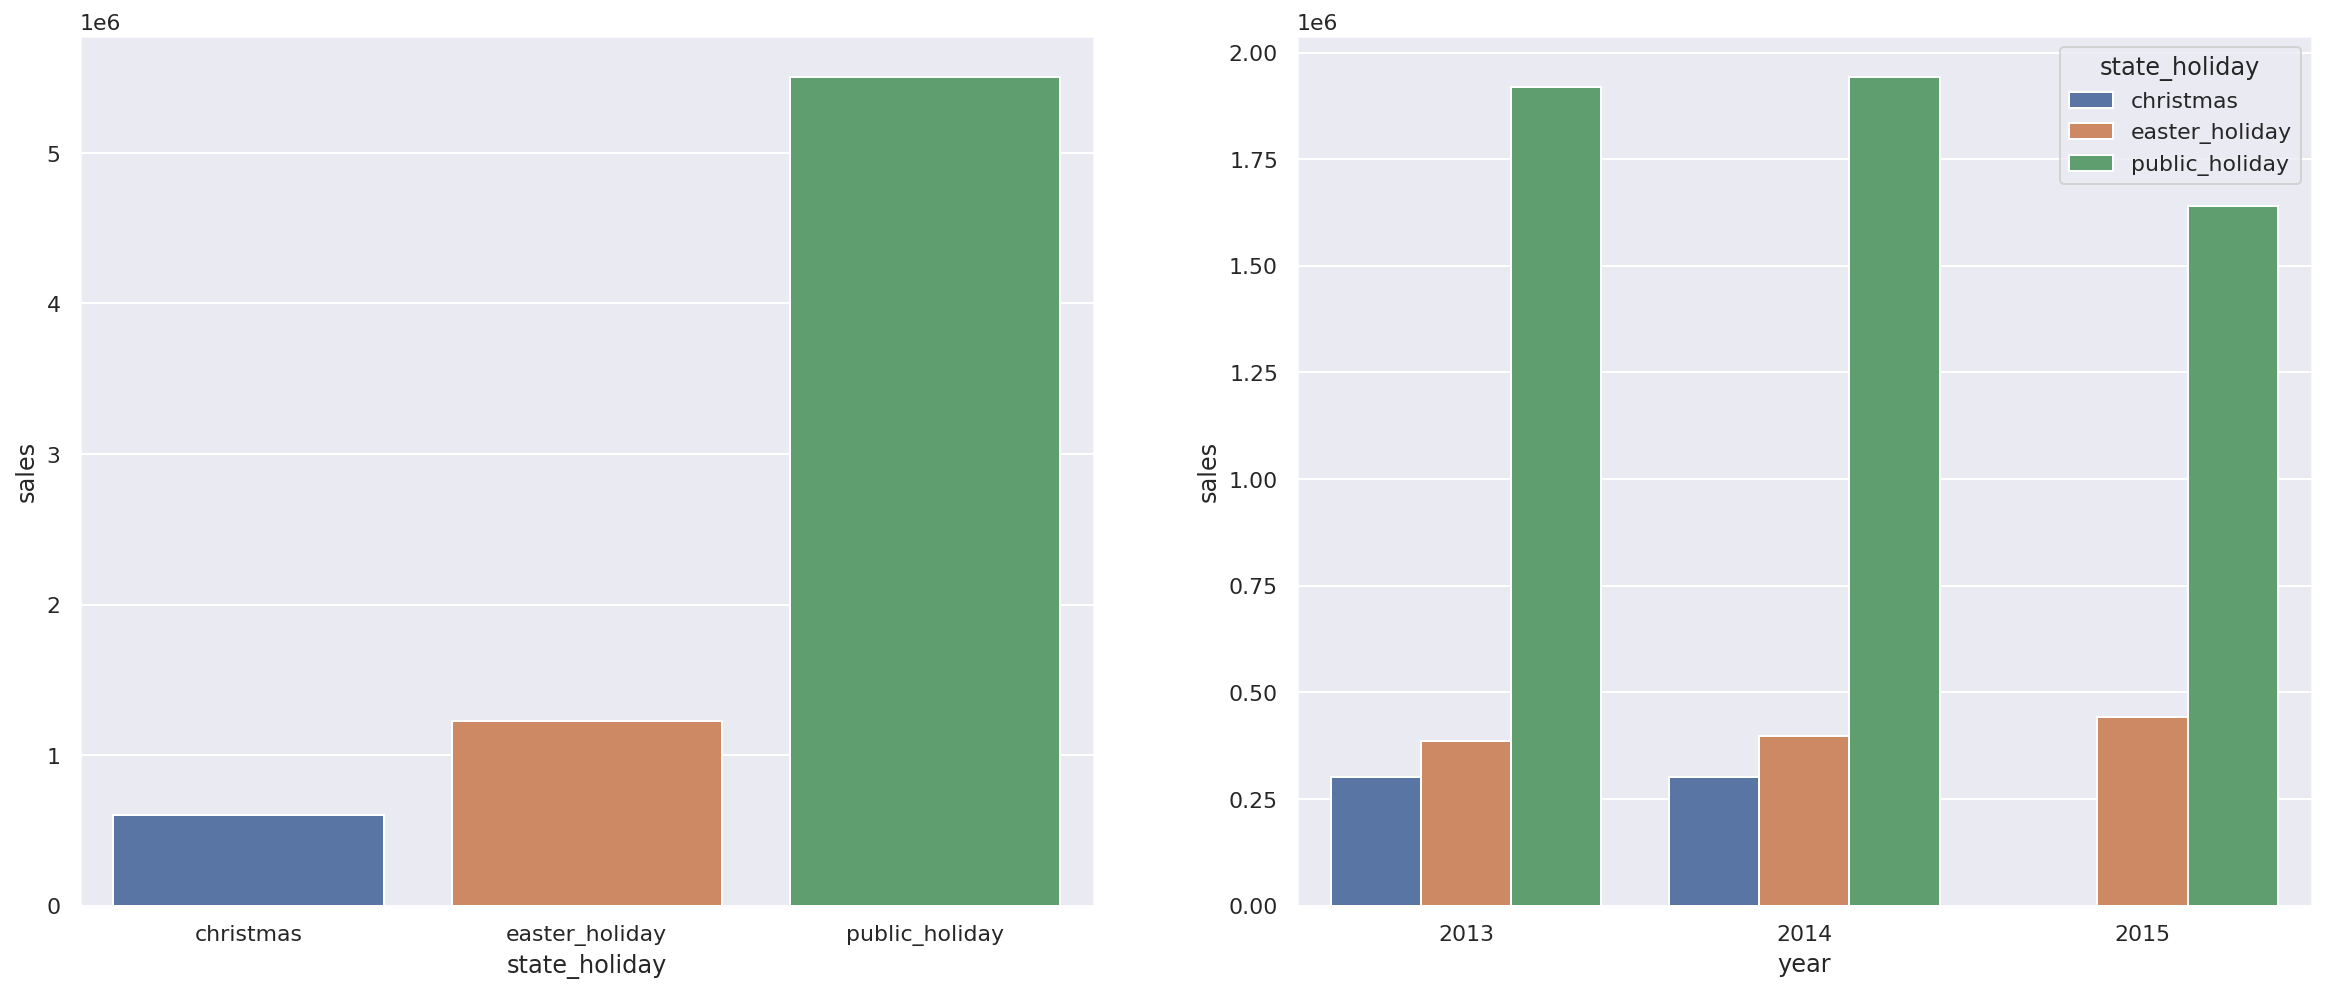

In [77]:
# filter state_holiday without 'regular_day'
aux = df4[df4['state_holiday'] != 'regular_day']

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 2, 1)
# sum of sales by state_holiday
aux7_1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux7_1);


# set up subplot
plt.subplot( 1, 2, 2)
# sum of sales by state_holiday and year
aux7_2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux7_2)

### **H8.** Stores should sell more throughout the years.
**FALSE** Stores sell less throughout the years.

Comentários:
Esta análise não representa um insight pois os analistas de negócios acompanham a métrica de vendas por ano. A análise mostra uma queda nas vendas de 2013 a 2015, o que pode ser um sinal de alerta para o negócio. Obs: o ano de 2015 ainda não está fechado no dataset, ou seja, é um valor que tende a crescer até o final daquele ano.

Correlação de pearson alto, relevante para o modelo. Relevância alta.

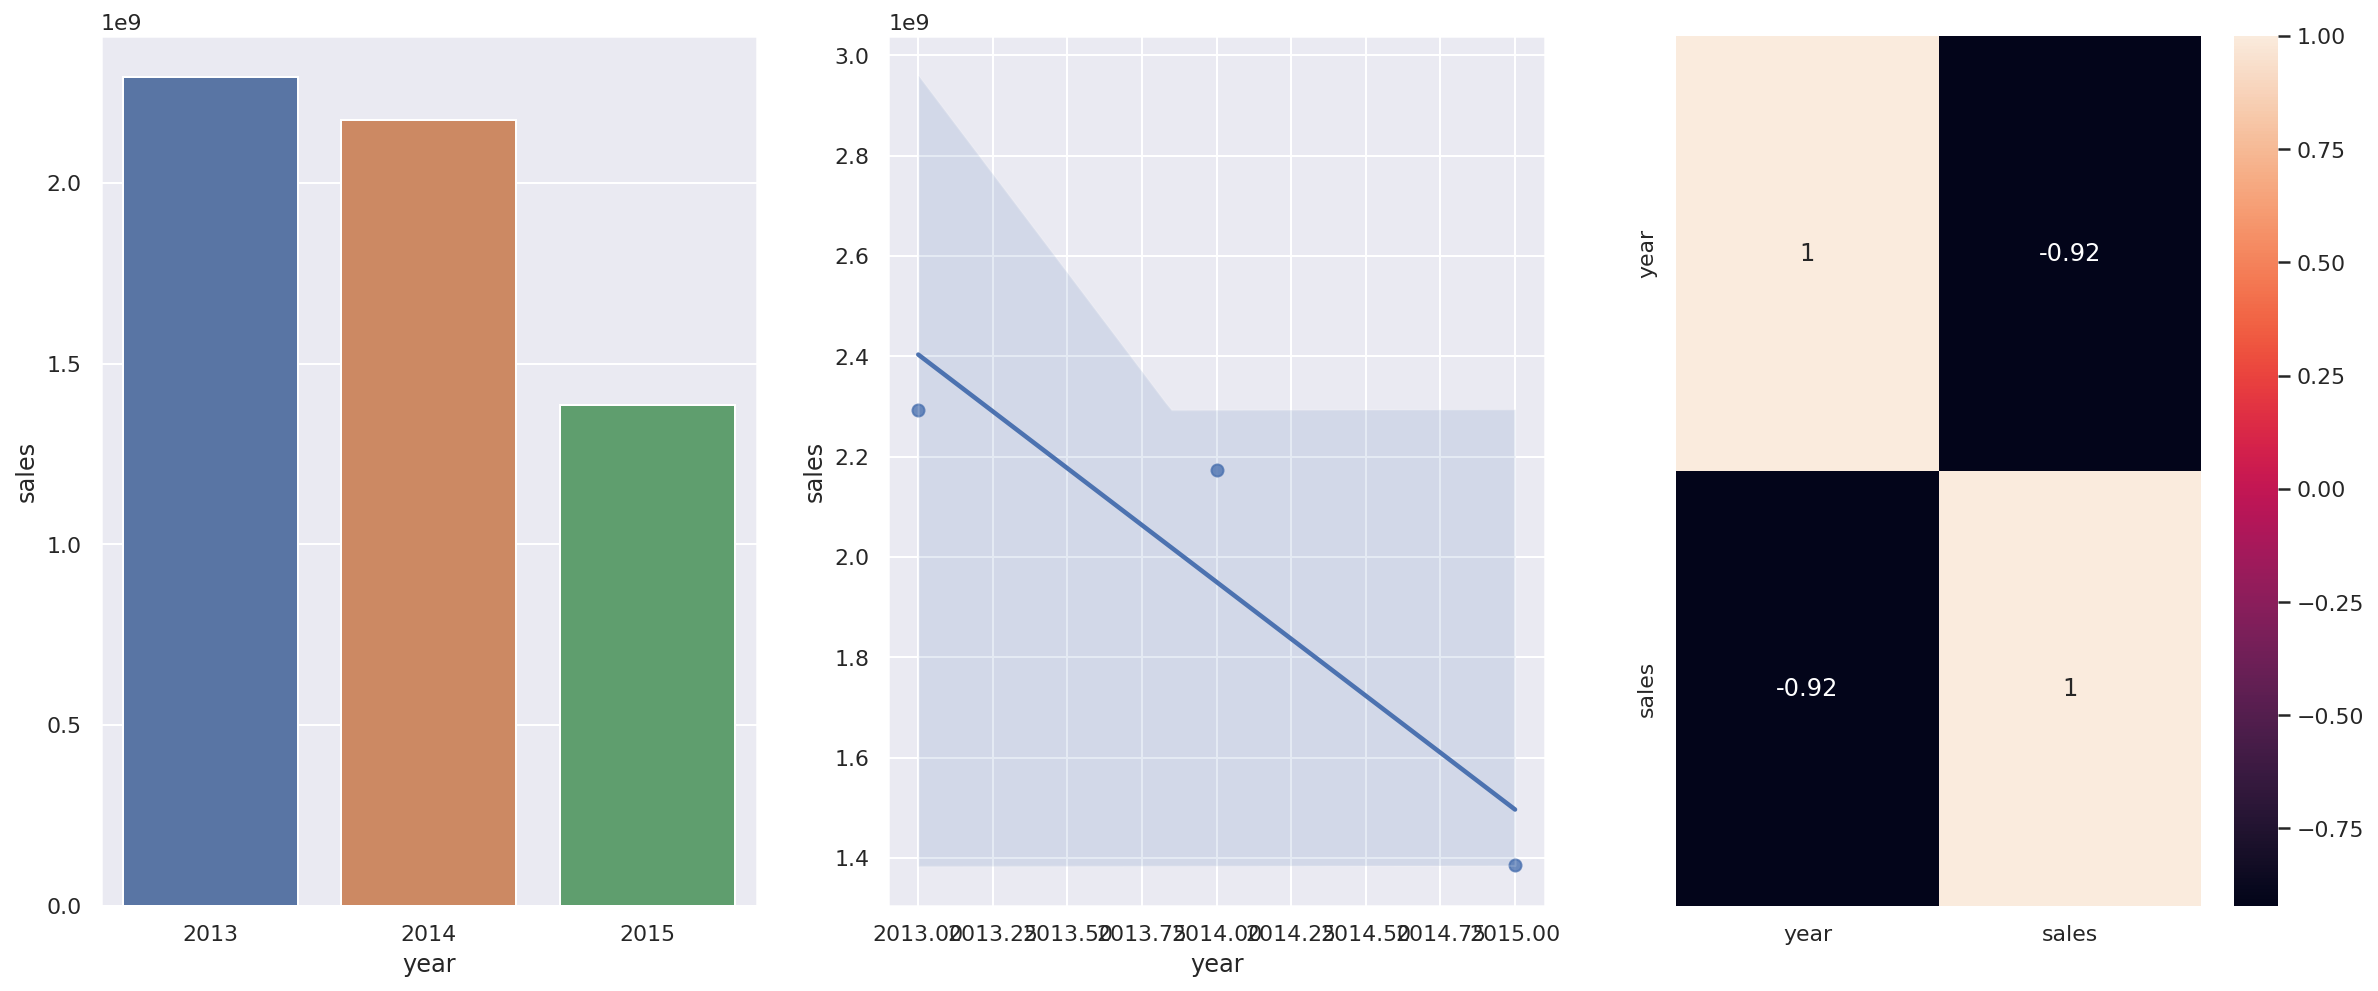

In [78]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by year
aux8_1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux8_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='year', y='sales', data=aux8_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux8_1.corr( method='pearson'), annot=True);

### **H9.** Stores should sell more on second semester.
**FALSE** Stores sell less on second semester.

Comentários:
Esta análise não gera um insight pois depende muito do negócio.

Correlação de pearson relevante: -0,75 (enquanto o número do mês sobe, as vendas descem). Relevância alta.

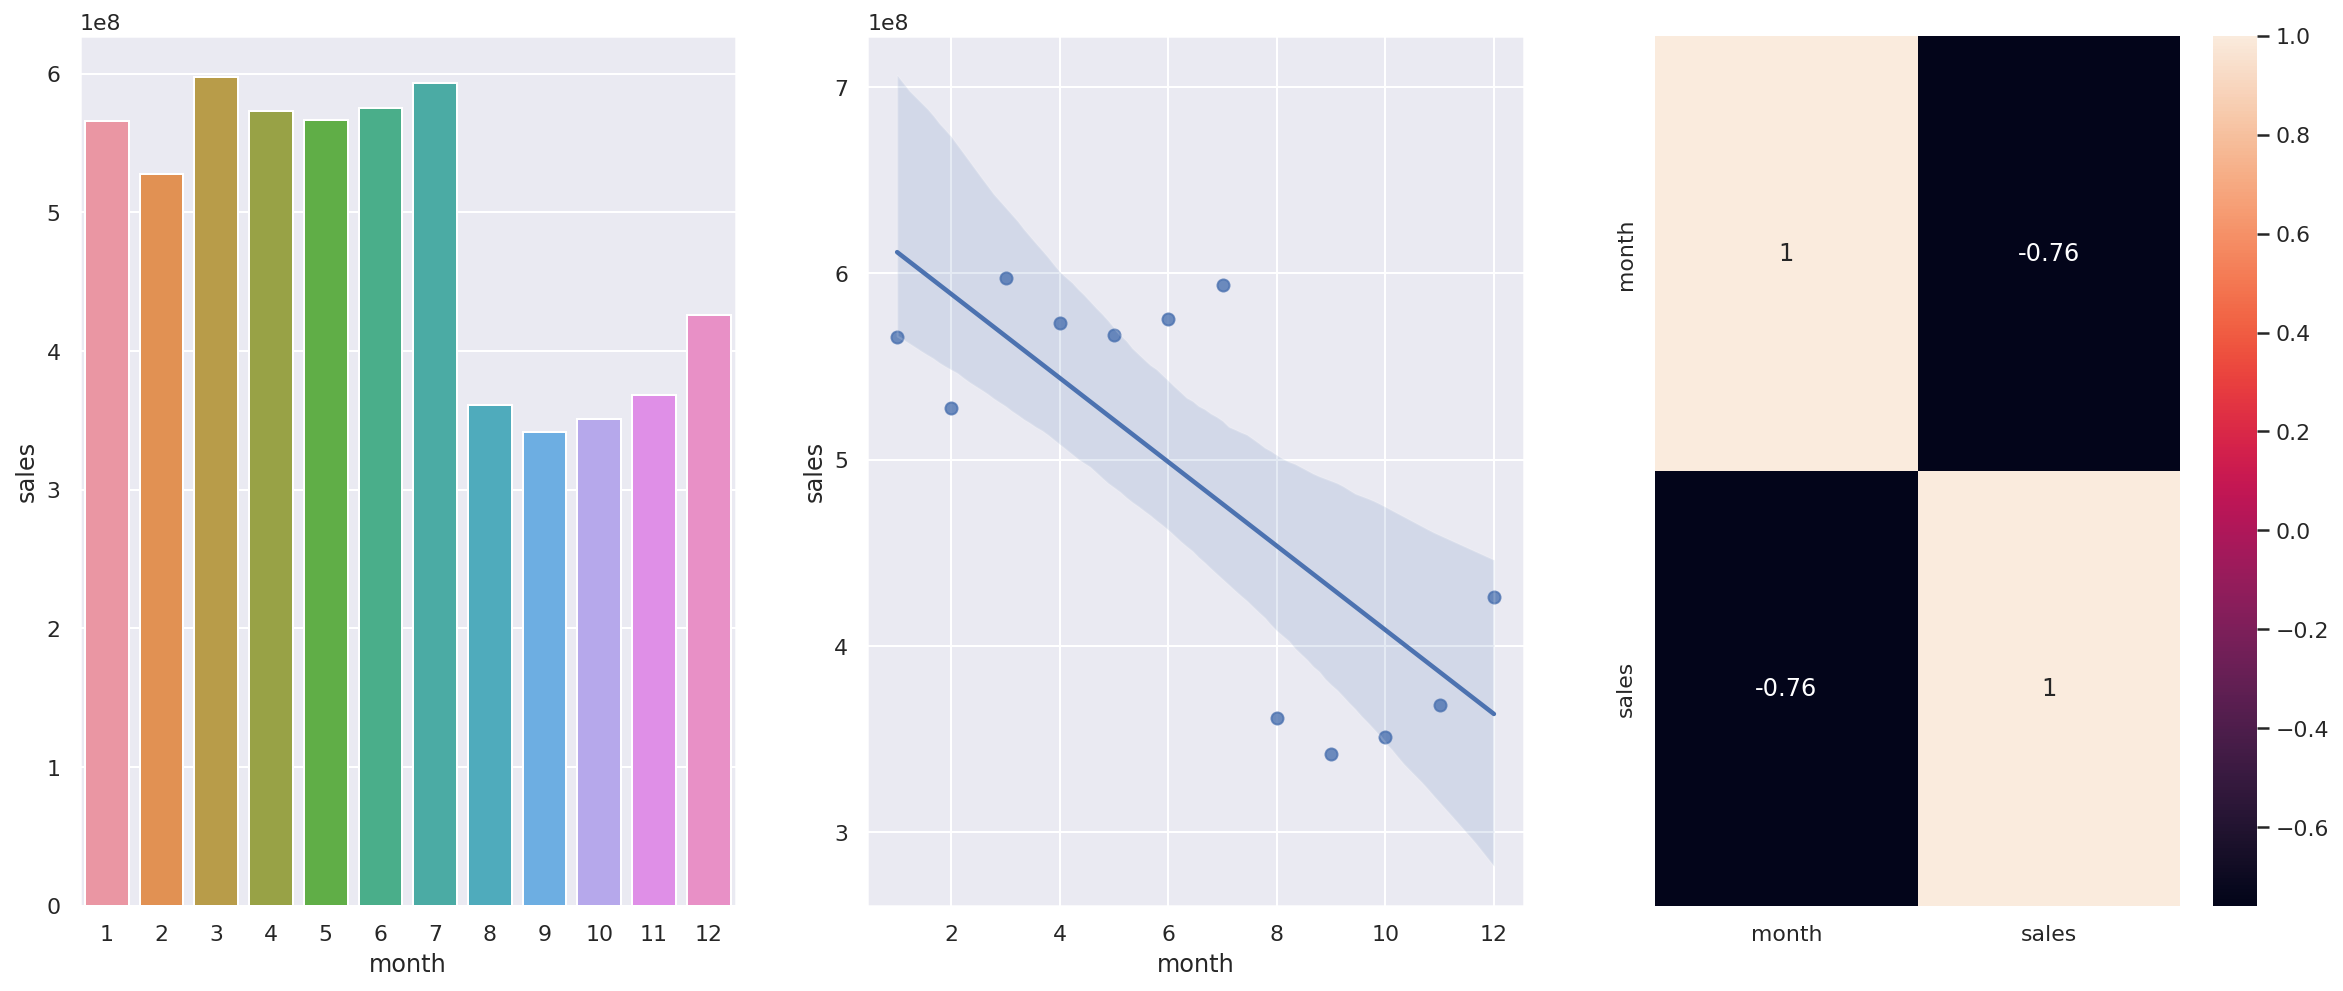

In [79]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by month
aux9_1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux9_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='month', y='sales', data=aux9_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux9_1.corr( method='pearson'), annot=True);

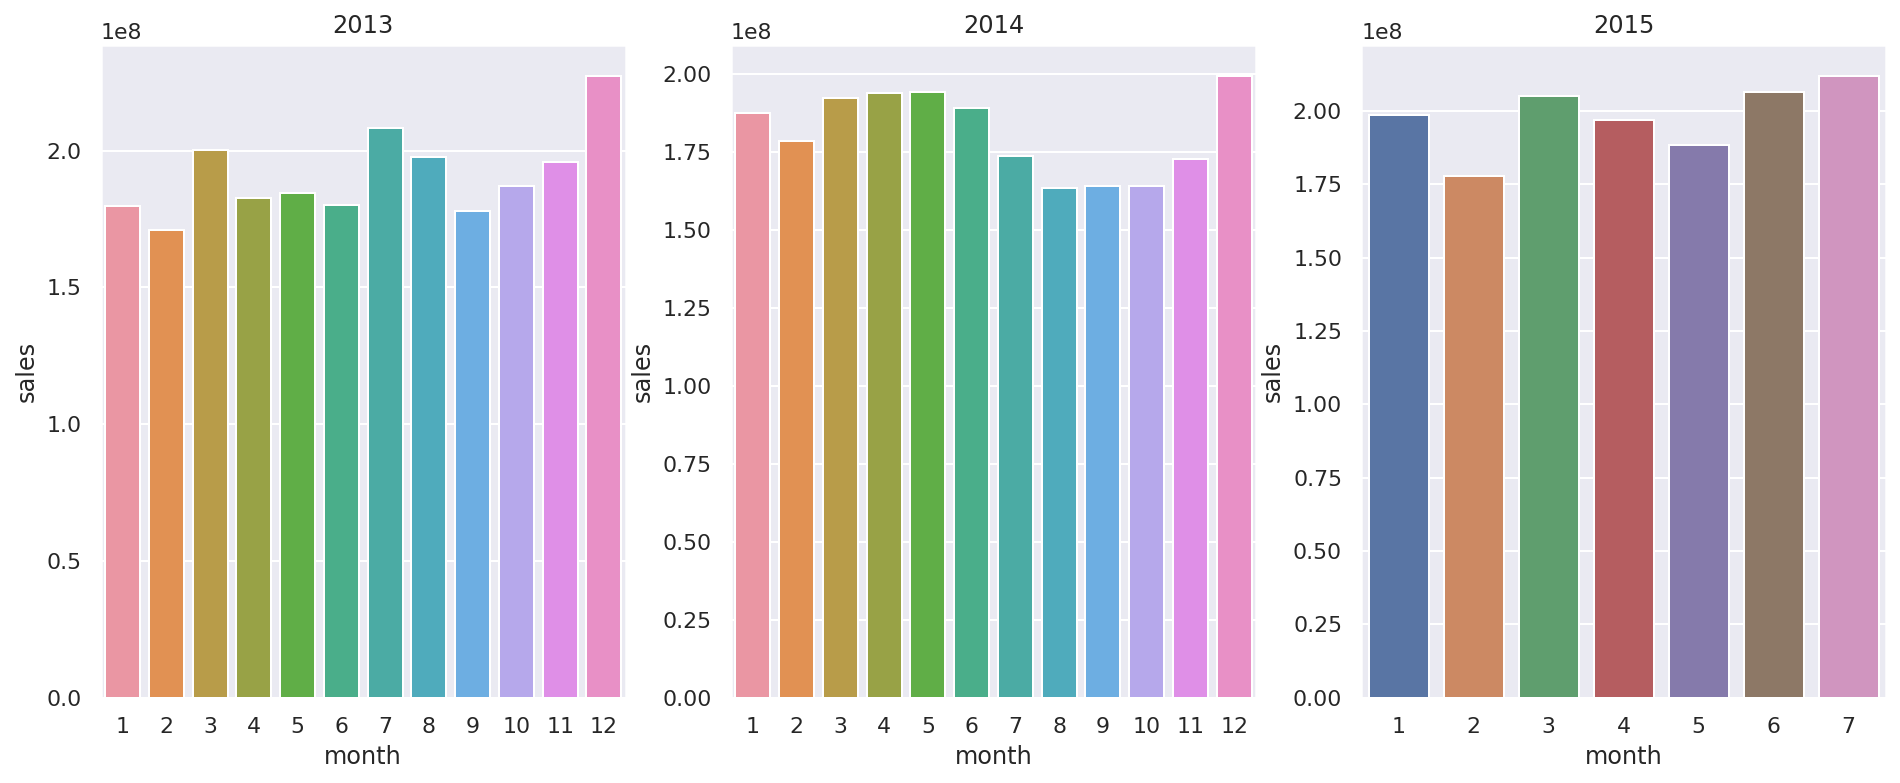

In [80]:
# month, year
# year 2013
aux9_1 = df4[df4['year'] == 2013][['month', 'sales']].groupby('month').sum().reset_index()
# plots
plt.subplots(1, 3, figsize=(16,6))
# 2013 - 1st plot
plt.subplot(1, 3, 1)
plt.title('2013')
sns.barplot(x='month', y='sales', data=aux9_1);

# year 2014
aux9_2 = df4[df4['year'] == 2014][['month', 'sales']].groupby('month').sum().reset_index()
# 2014 - 2nd plot
plt.subplot(1, 3, 2)
plt.title('2014')
sns.barplot(x='month', y='sales', data=aux9_2);

# year 2015
aux9_3 = df4[df4['year'] == 2015][['month', 'sales']].groupby('month').sum().reset_index()
# 2015 - 3rd plot
plt.subplot(1, 3, 3)
plt.title('2015')
sns.barplot(x='month', y='sales', data=aux9_3);

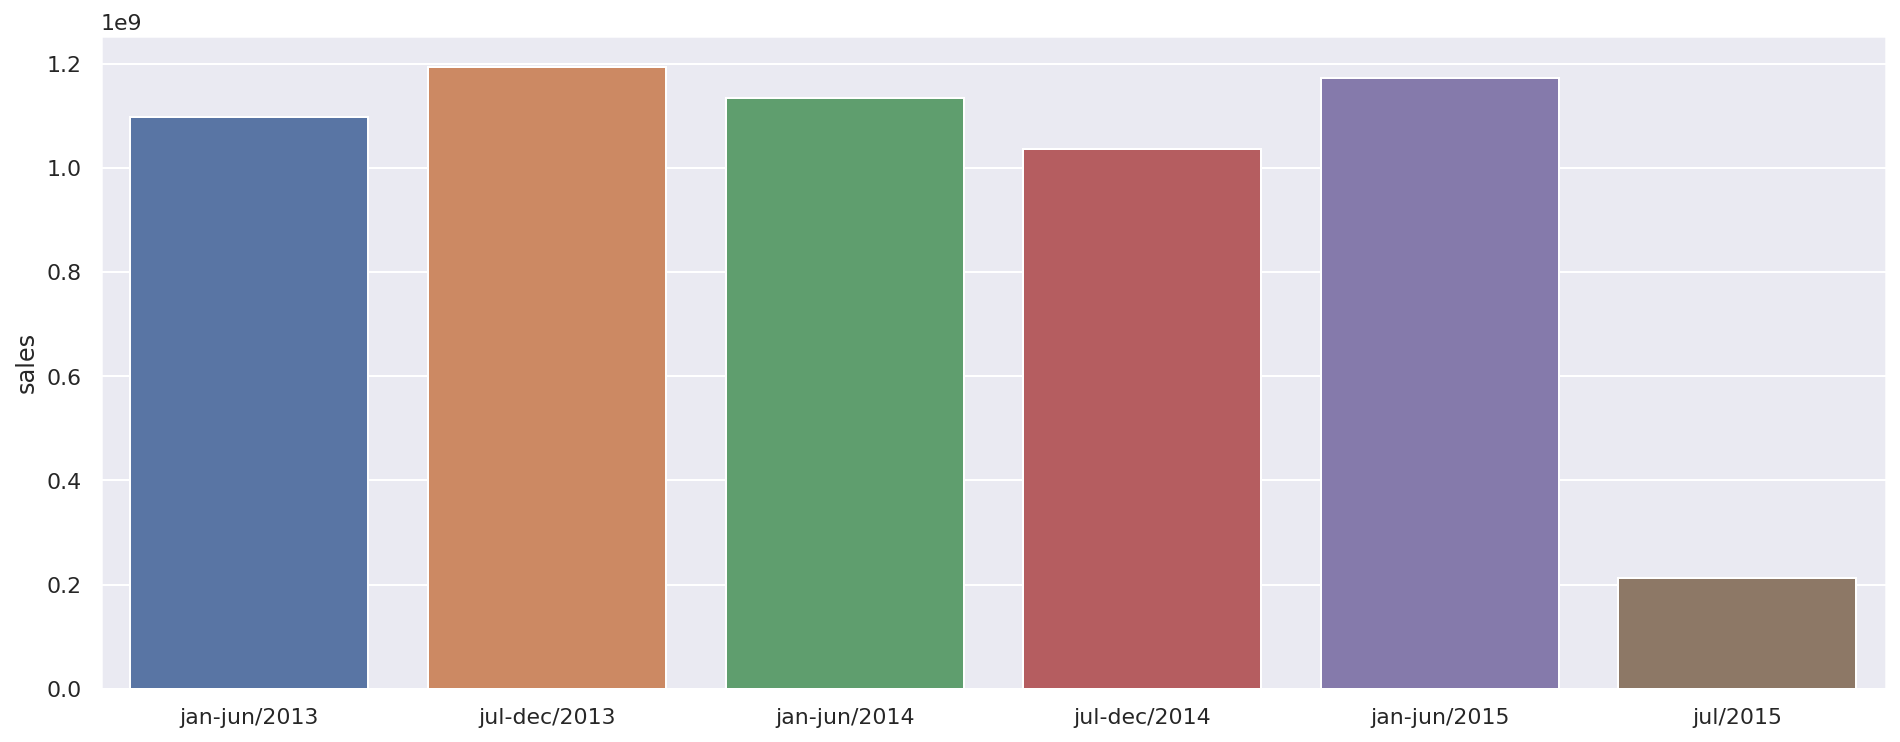

In [81]:
# sum of sales between january and june 2013
aux9_1_1 = aux9_1[(aux9_1['month'] >= 1) & (aux9_1['month'] <= 6)]['sales'].sum()
# sum of sales between january and june 2014
aux9_1_2 = aux9_2[(aux9_2['month'] >= 1) & (aux9_2['month'] <= 6)]['sales'].sum()
# sum of sales between january and june 2015
aux9_1_3 = aux9_3[(aux9_3['month'] >= 1) & (aux9_2['month'] <= 6)]['sales'].sum()

# sum of sales between july and december 2013
aux9_1_4 = aux9_1[(aux9_1['month'] >= 7) & (aux9_1['month'] <= 12)]['sales'].sum()
# sum of sales between july and december 2014
aux9_1_5 = aux9_2[(aux9_2['month'] >= 7) & (aux9_2['month'] <= 12)]['sales'].sum()
# sum of sales july 2015
aux9_1_6 = aux9_3[(aux9_3['month'] >= 7)]['sales'].sum()

df9_1 = pd.DataFrame({'sales':[aux9_1_1, aux9_1_4, aux9_1_2, aux9_1_5, aux9_1_3, aux9_1_6]}, 
                     index=['jan-jun/2013', 'jul-dec/2013','jan-jun/2014','jul-dec/2014',
                           'jan-jun/2015', 'jul/2015'])

plt.subplots(figsize=(16,6))
sns.barplot(x=df9_1.index, y='sales', data=df9_1);

### **H10.** Stores should sell more after the 10th day of the month.
**FALSE** Stores sell less after the 10th day of the month.

Comentários:
Esta análise não é uym insight pois os analistas de negócios acompanham este tipo de métrica.

A variável pode ser relevante para o modelo. Relevância alta.

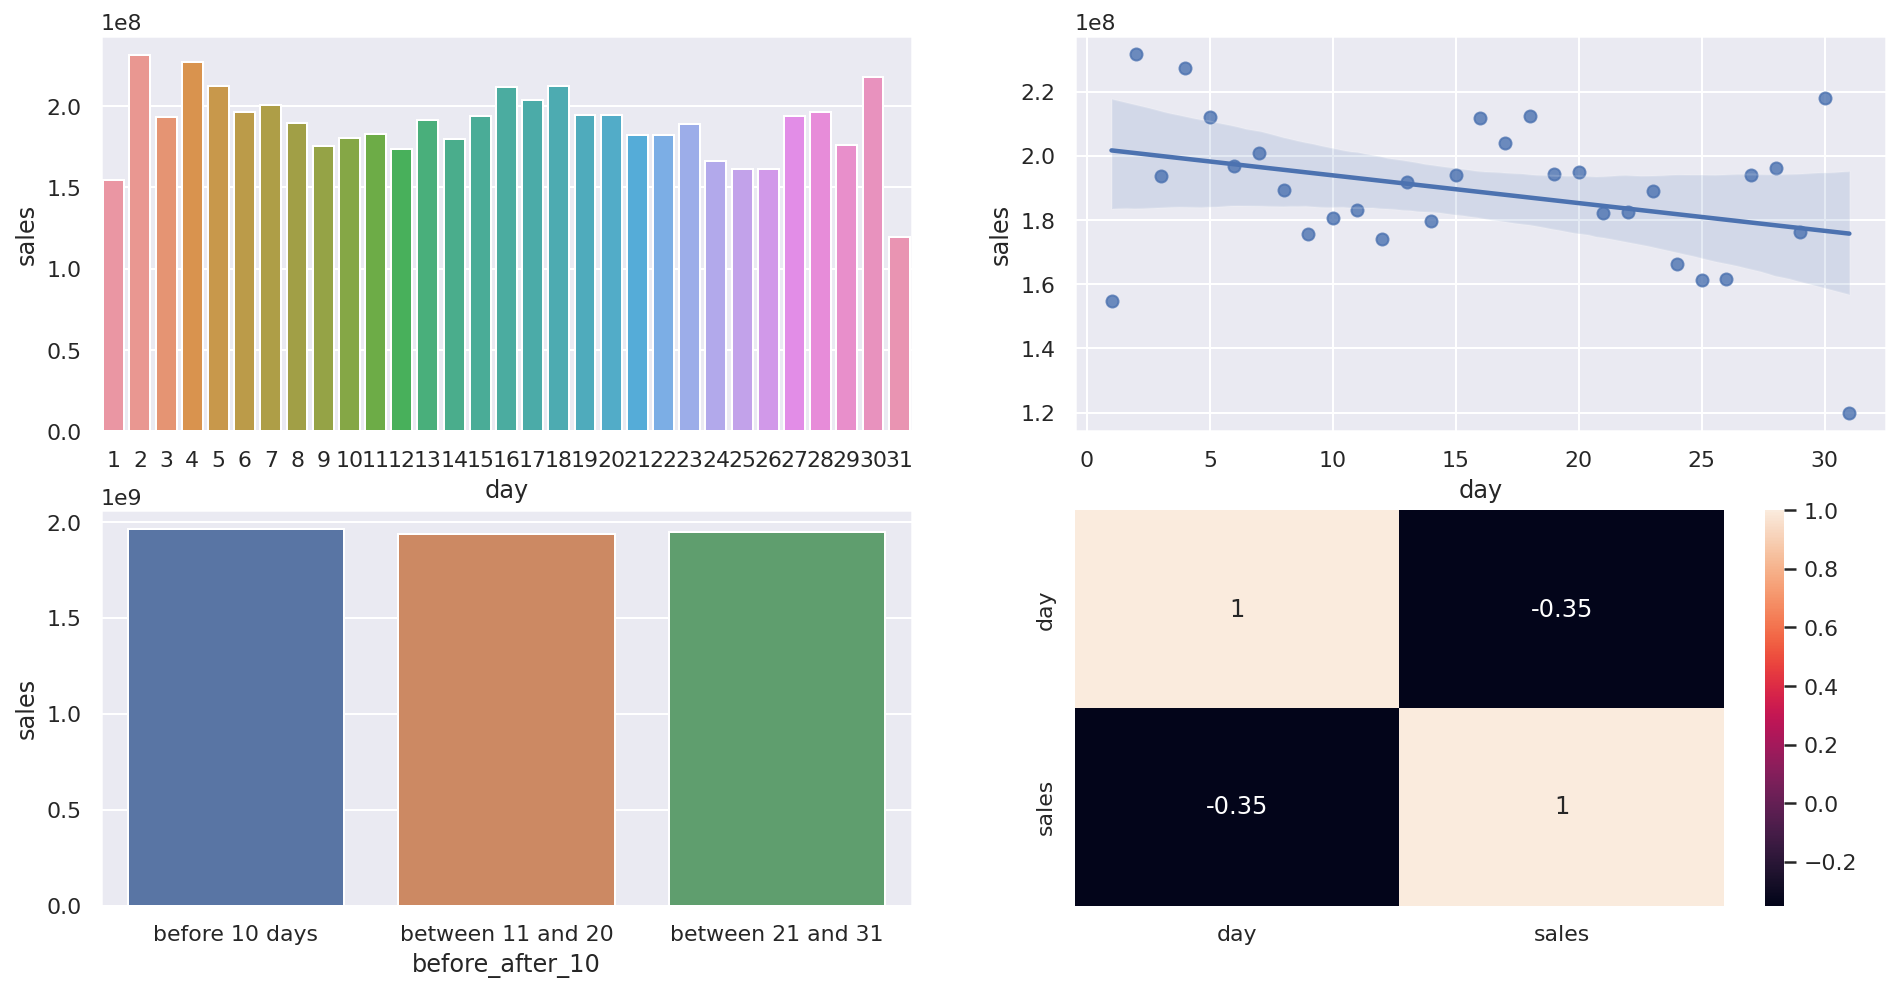

In [82]:
# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# set up subplot
plt.subplot( 2, 2, 1)
# sum of sales by day
aux10 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux10 );

# set up subplot
plt.subplot( 2, 2, 2)
# Trend graph
sns.regplot( x='day', y='sales', data=aux10);

# before and after 10 days
aux10['before_after_10'] = aux10['day'].apply( lambda x: 'before 10 days' if x <= 10 else 'between 11 and 20' if (x > 10 and x <= 20) else 'between 21 and 31')
aux10_1 = aux10.groupby('before_after_10').sum().reset_index()
# barplot - 3rd plot
plt.subplot(2, 2, 3)
sns.barplot(x='before_after_10', y='sales', data=aux10_1);

# heatmap - 4th plot
plt.subplot(2, 2, 4)
aux10_2 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.heatmap(aux10_2.corr(method='pearson'), annot=True);

In [83]:
aux10_1

before_after_10  day       sales
0     before 10 days   55  1963006487
1  between 11 and 20  155  1939634210
2  between 21 and 31  286  1947118484

### **H11.** Stores should sell less on weekend.
**TRUE** Stores sell less on weekend.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Correlação de pearson de -0,76 (forte) relevante para o modelo. Relevância alta.

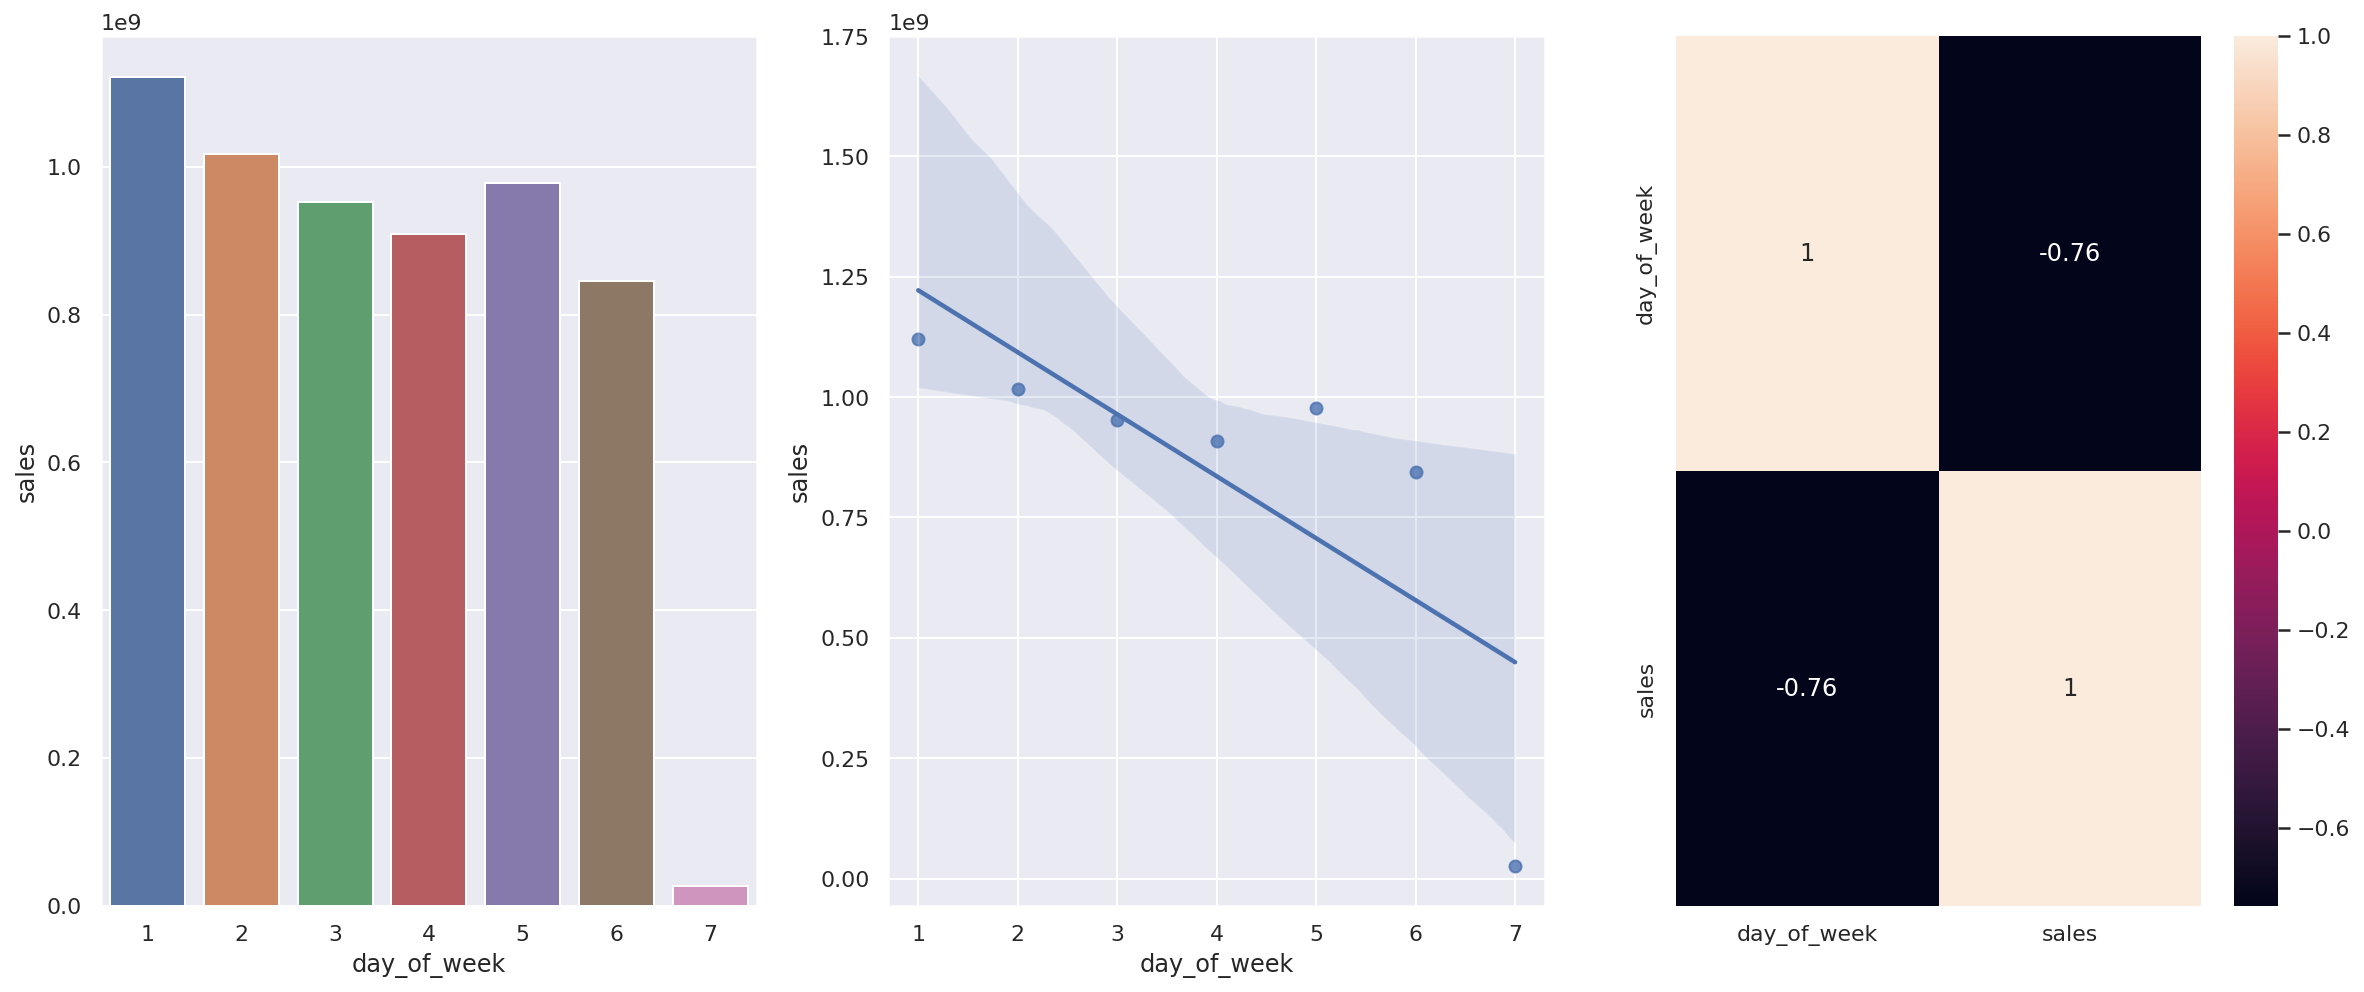

In [84]:
# ISO week day: Monday is 1 and Sunday is 7.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by day_of_week
aux11_1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux11_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='day_of_week', y='sales', data=aux11_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux11_1.corr( method='pearson'), annot=True);

### **H12.** Stores should sell less while school vacation.
**TRUE** Stores sell less during school vacation, except in July and August.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Variável relevante para o modelo pois nos meses 7 (aprox.) e 8 as vendas durante as férias escolares são maiores do que nos dias comuns.

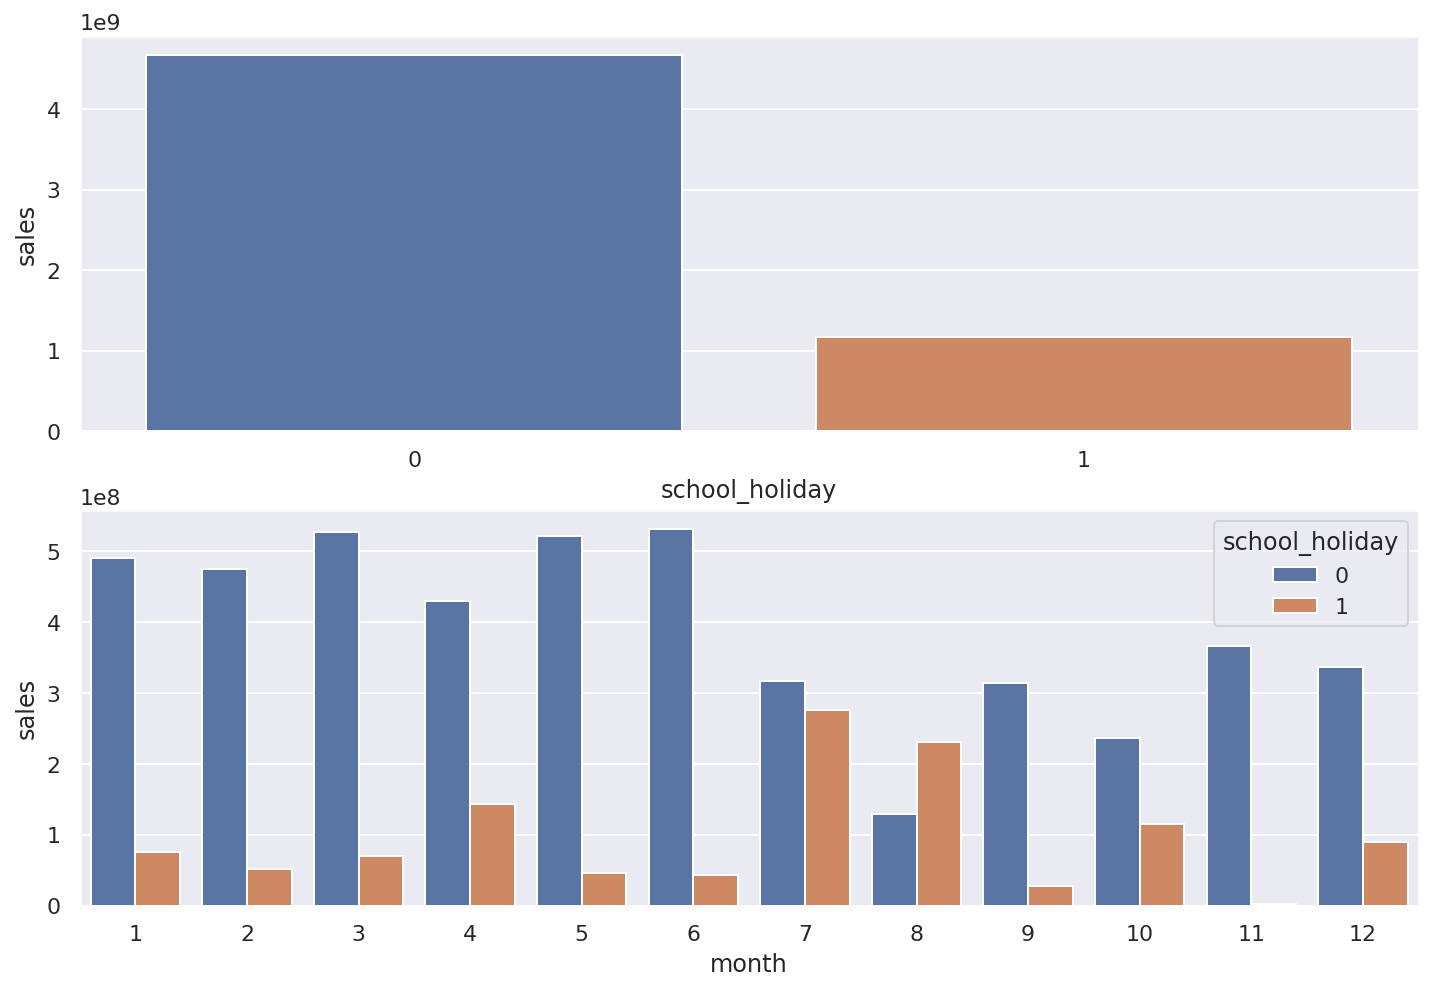

In [85]:
# set up figure size
f, ax = plt.subplots(figsize=(12,8))

# set up subplot
plt.subplot( 2, 1, 1)
# sum of sales by school_holiday
aux12_1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux12_1);

# set up subplot
plt.subplot( 2, 1, 2)
aux12_2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux12_2);

### **H13.** Stores with more customers should sell more.
**TRUE** Stores with more customers sell more.

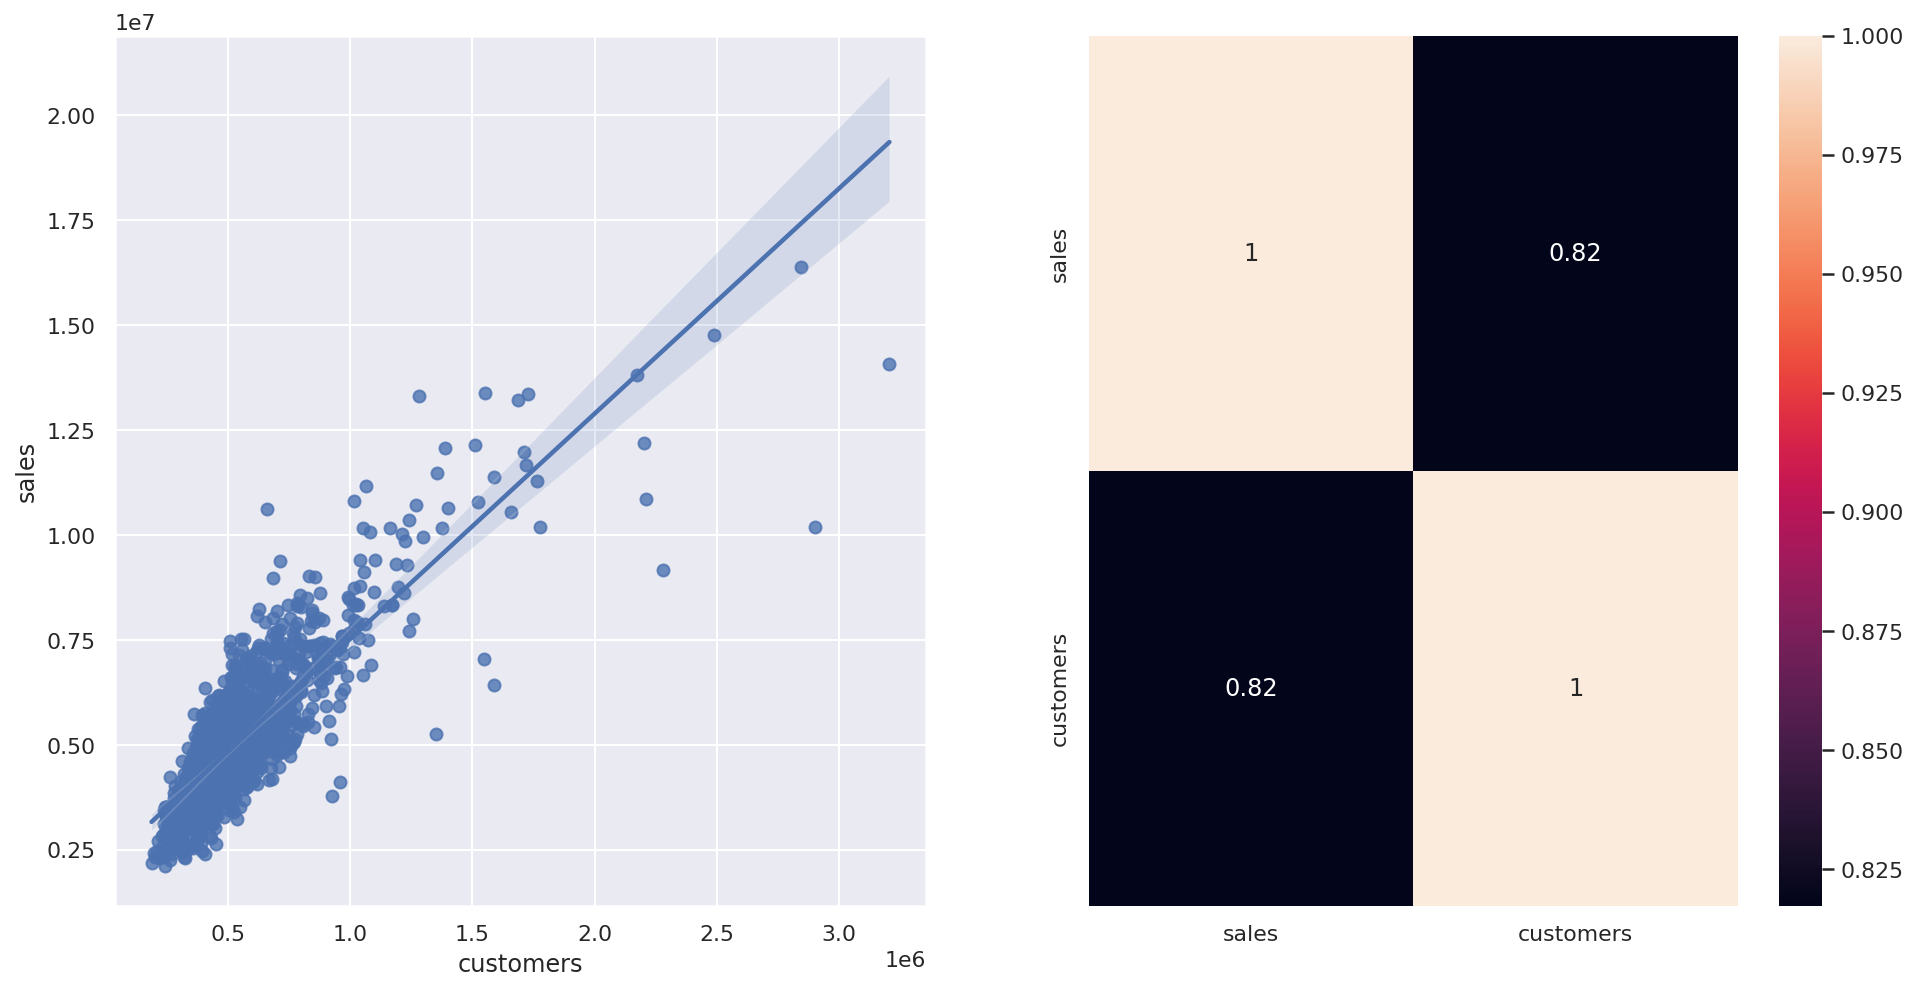

In [86]:
# set up plot
plt.subplots(1, 2, figsize=(16,8) )

# customers and sales regplot
aux13 = df4[['store', 'customers', 'sales']].groupby('store').sum().reset_index()
plt.subplot(1,2,1)
sns.regplot(x='customers', y='sales', data=aux13);

# heatmap
aux14 = df4[['sales', 'customers']]
plt.subplot(1,2,2)
sns.heatmap(aux14.corr(method='pearson'), annot=True);

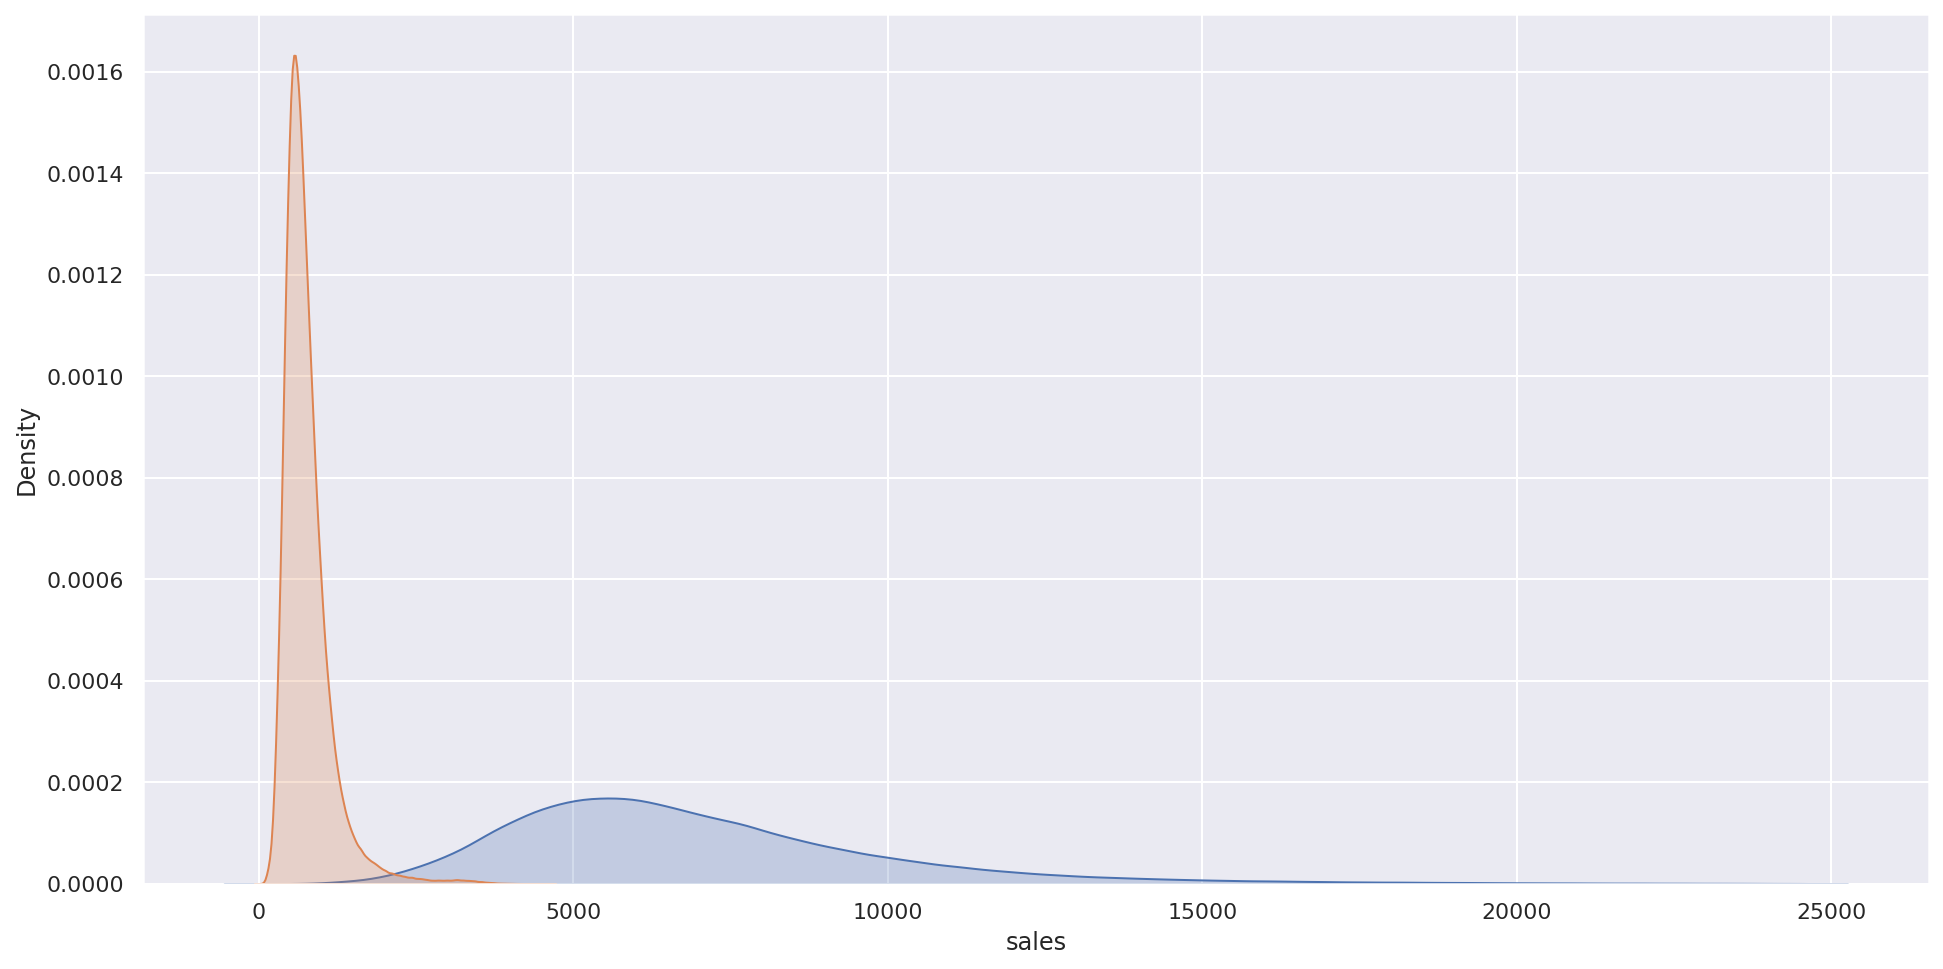

In [87]:
# set up plot
plt.subplots( figsize=(16,8) )

# customers and sales lineplot
sns.kdeplot(df4['sales'], label='sales', shade=True)
sns.kdeplot(df4['customers'], label='customers', shade=True);

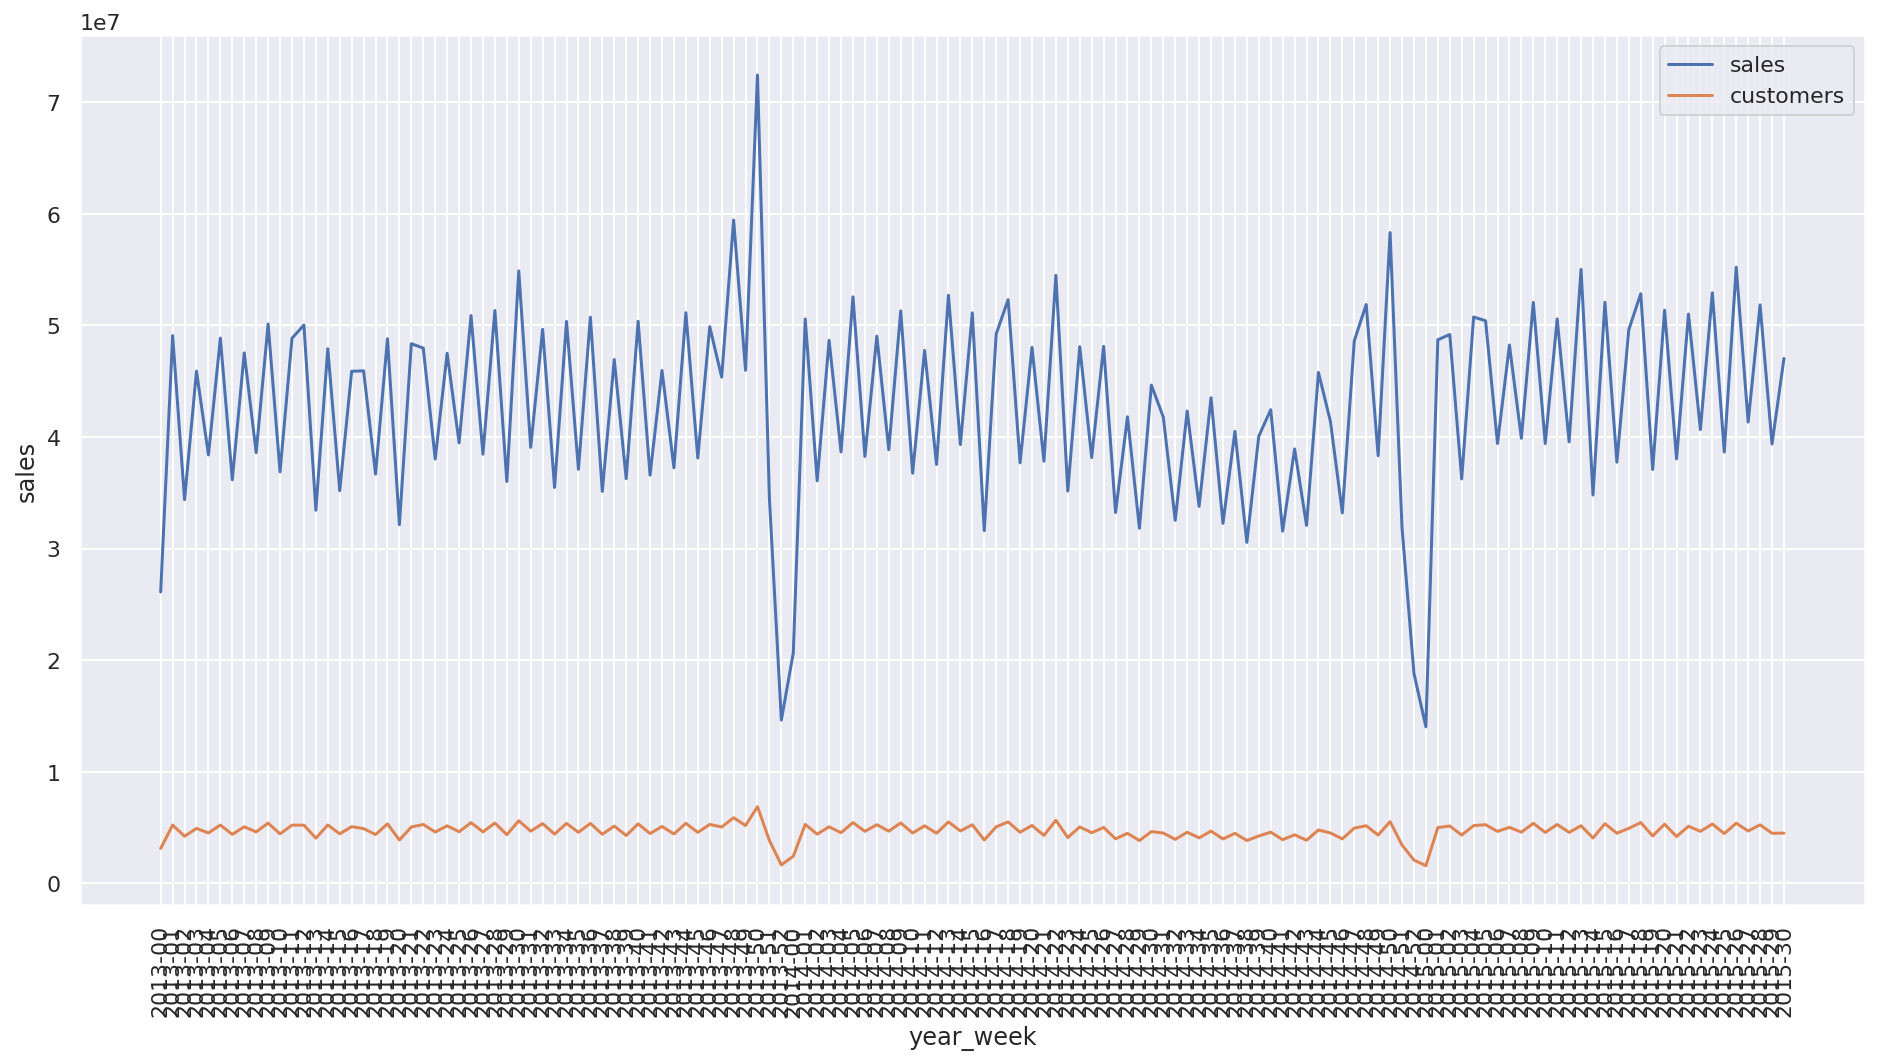

In [88]:
plt.subplots(figsize=(16,8))

# customers, sales, year_week
aux14 = df4[['year_week', 'customers', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot( x='year_week', y='sales', data=aux14, label='sales' );
sns.lineplot( x='year_week', y='customers', data=aux14, label='customers' );
plt.xticks(rotation=90);

### 4.2.1. Hypothesis Summary

In [89]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Stores with bigger Assortment should sell more.',
                                      'Stores with competition closer should sell less.',
                                      'Stores with longer time competition should sell more.',
                                      'Stores with longer Sale (promo) should sell more.',
                                      'Stores with more Sale (promo) days should sell more.',
                                      'Stores with more consecutive Sale (promo) should sell more.',
                                      'Stores open on Christmas time should sell more.',
                                      'Stores should sell more throughout the years.',
                                      'Stores should sell more on second semester.',
                                      'Stores should sell more after the 10th day of the month.',
                                      'Stores should sell less on weekend.',
                                      'Stores should sell less while school vacation.',
                                      'Stores with more customers should sell more.'],
                        'True / False':['False', 'False', 'False', 'False', 'True', 'False', 'False', 'False', 'False',
                                        'False', 'False', 'True', 'True'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'High', 'High', 'High',
                                     'High', 'Low', 'High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
summary

Hypothesis True / False Relevance
1               Stores with bigger Assortment should sell more.        False       Low
2              Stores with competition closer should sell less.        False    Medium
3         Stores with longer time competition should sell more.        False    Medium
4             Stores with longer Sale (promo) should sell more.        False       Low
5          Stores with more Sale (promo) days should sell more.         True    Medium
6   Stores with more consecutive Sale (promo) should sell more.        False       Low
7               Stores open on Christmas time should sell more.        False    Medium
8                 Stores should sell more throughout the years.        False      High
9                   Stores should sell more on second semester.        False      High
10     Stores should sell more after the 10th day of the month.        False      High
11                          Stores should sell less on weekend.        False      High
12               Stores should sell less while school vacation.         True       Low
13                 Stores with more customers should sell more.         True      High

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

In [90]:
# here we need df1 again
df1 = pickle.load( open( intdatapath+'df1.pkl', 'rb' ) )

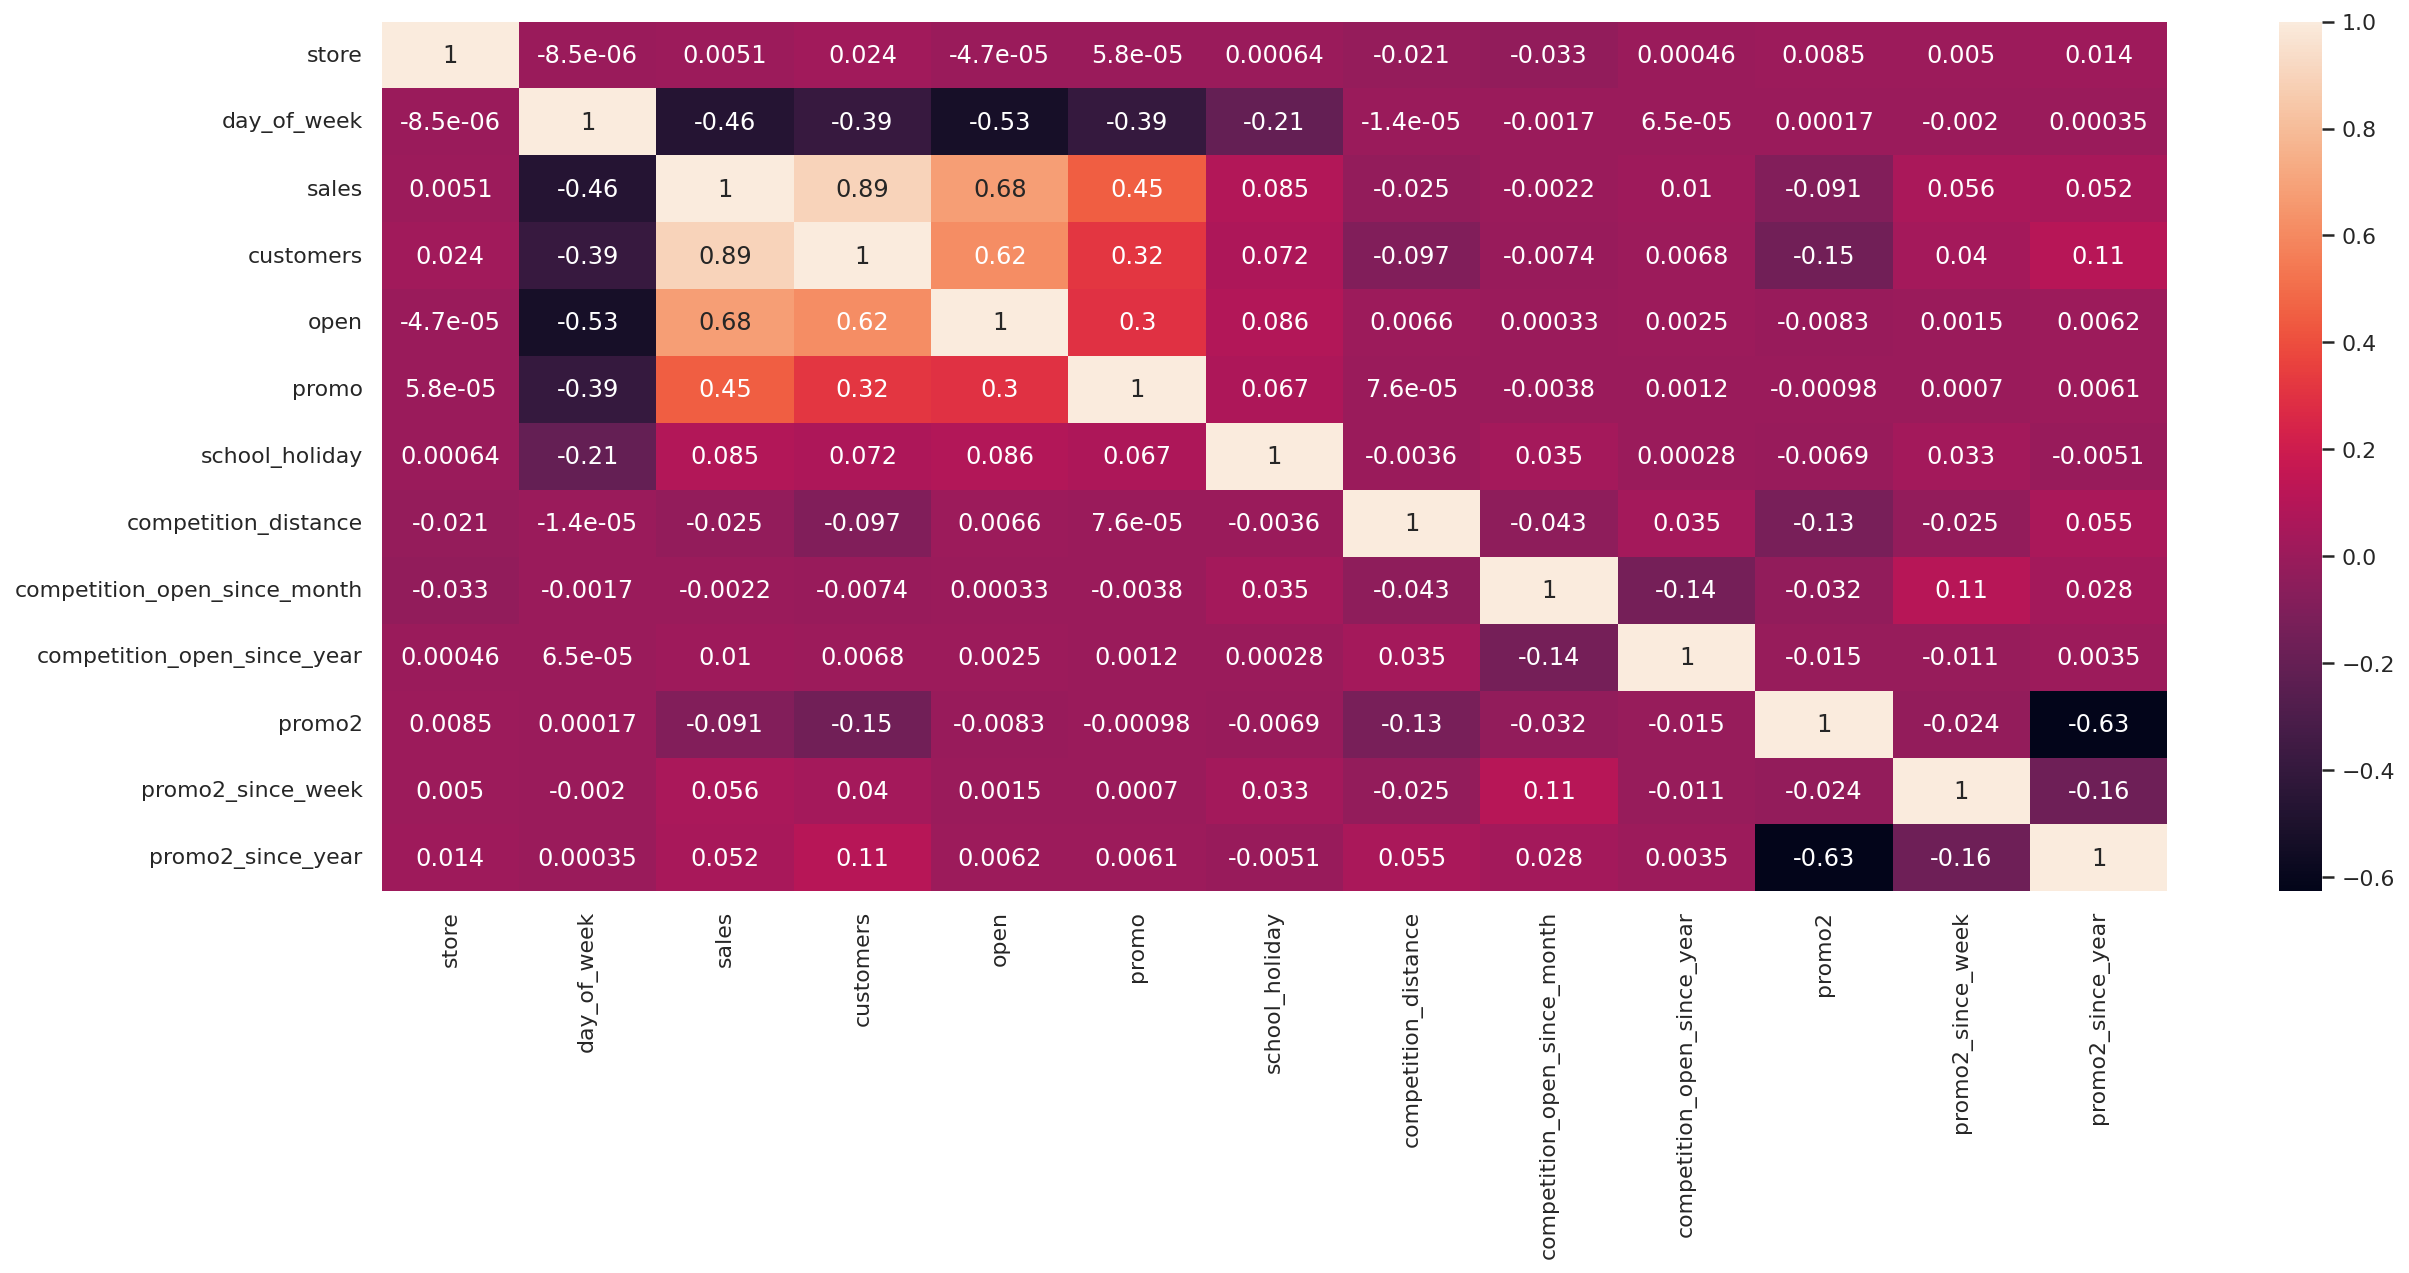

In [91]:
# select numerical columns from the df1
numeric_cols = [cname for cname in df1.columns if df1[cname].dtype in ['int64', 'float64']]
num_attributes = df1[numeric_cols]

# correlation by pearosn method
correlation = num_attributes.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

In [92]:
del df1

### 4.3.2. Categorical Attributes

In [93]:
# Select categorical attributes
a = df4.select_dtypes( include='object' )
a.head()

state_holiday store_type assortment year_week
0   regular_day          c      basic   2015-30
1   regular_day          a      basic   2015-30
2   regular_day          a      basic   2015-30
3   regular_day          c   extended   2015-30
4   regular_day          a      basic   2015-30

In [94]:
# confusion matrix makes all the possible combinations between categorical variables
# and count the number of lines of that combination.
a[(a['state_holiday'] == 'christmas' ) & ( a['store_type'] == 'a' )]

state_holiday store_type assortment year_week
241499     christmas          a   extended   2014-51
241977     christmas          a   extended   2014-51
616339     christmas          a   extended   2013-51
616908     christmas          a   extended   2013-51

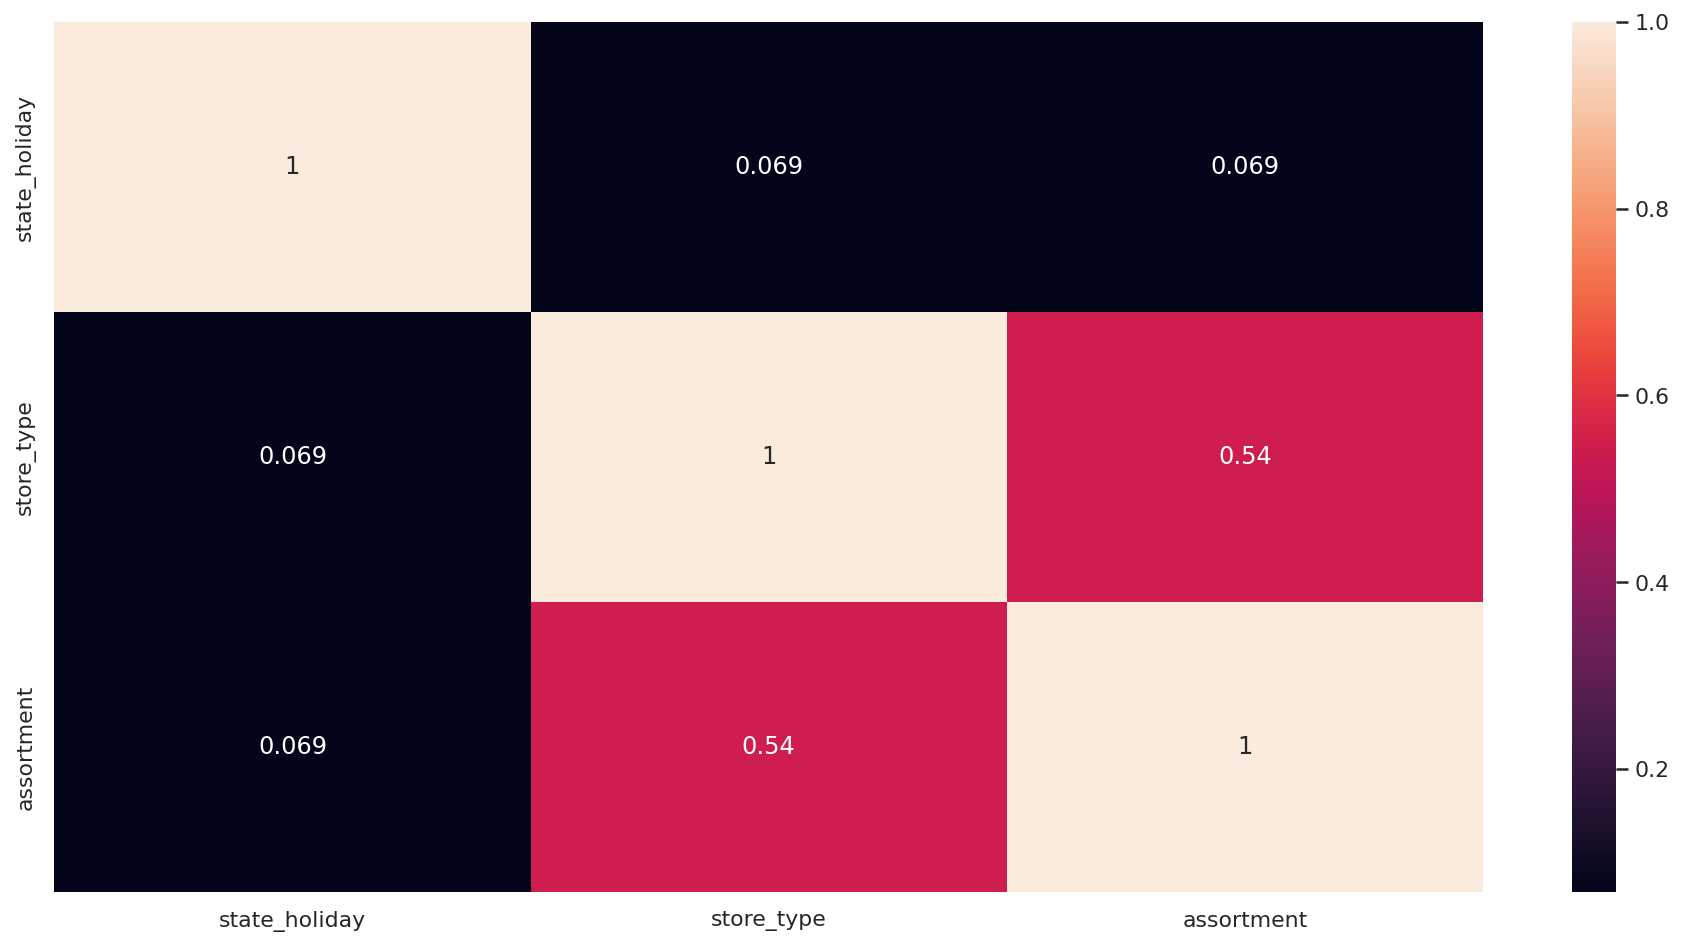

In [95]:
# calculate Cramer V
# Cramer V (chi2) formula is in the 0.1. Helper Functions subsection.
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] })

d = d.set_index( d.columns)

sns.heatmap( d, annot=True);

### saving data

In [96]:
pickle.dump( df4, open( intdatapath+'df4.pkl', 'wb' ) )

# 5.0. DATA PREPARATION

#### Remark: For teaching purposes, we take the risk of performing transformations BEFORE split the dataset for training and testing. We understand that the risk of data leakage is minimal.

In [97]:
# Copy the previous dataframe. Remove auxiliary column 'compare'.
df5 = pickle.load( open( intdatapath+'df4.pkl', 'rb' ) )

In [98]:
df5.head().T

0                    1                    2                    3                    4
store                                           1                    2                    3                    4                    5
day_of_week                                     5                    5                    5                    5                    5
date                          2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                        5263                 6064                 8314                13995                 4822
customers                                     555                  625                  821                 1498                  559
promo                                           1                    1                    1                    1                    1
state_holiday                         regular_day          regular_day          regular_day          regular_day          regular_day
school_holiday                                  1                    1                    1                    1                    1
store_type                                      c                    a                    a                    c                    a
assortment                                  basic                basic                basic             extended                basic
competition_distance                   1,270.0000             570.0000          14,130.0000             620.0000          29,910.0000
competition_open_since_month                    9                   11                   12                    9                    4
competition_open_since_year                  2008                 2007                 2006                 2009                 2015
promo2                                          0                    1                    1                    0                    0
promo2_since_week                              31                   13                   14                   31                   31
promo2_since_year                            2015                 2010                 2011                 2015                 2015
year                                         2015                 2015                 2015                 2015                 2015
month                                           7                    7                    7                    7                    7
day                                            31                   31                   31                   31                   31
week_of_year                                   31                   31                   31                   31                   31
year_week                                 2015-30              2015-30              2015-30              2015-30              2015-30
competition_since             2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         84                   94                  105                   71                    4
promo_since                   2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                 0                  279                  226                    0                    0

## 5.1. Standardization

Remark: None of the numerical variables have a normal distribution (see subsection 4.1.2.), therefore the Standardization will not be applied.

## 5.2. Rescaling

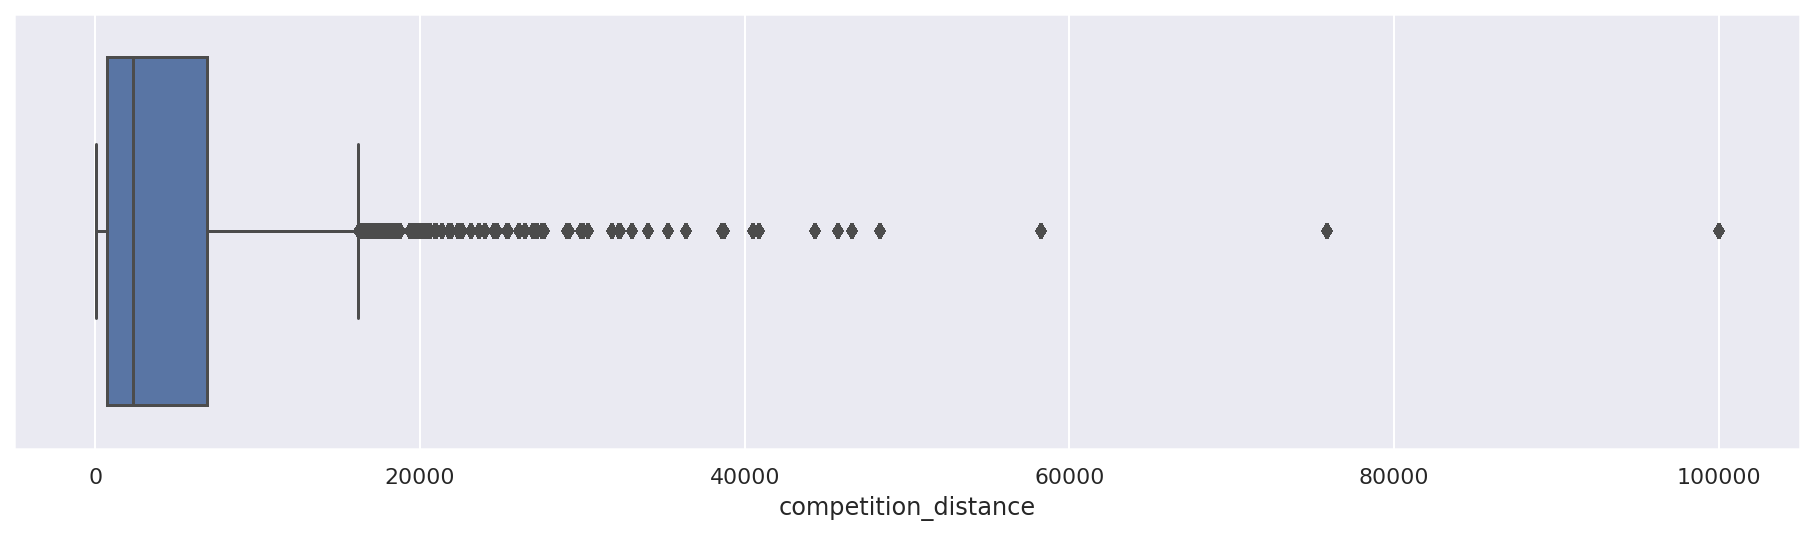

In [100]:
# Check competition_distance outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,4) )

# boxplot of competition_distance to check outliers
sns.boxplot( df5['competition_distance'] );

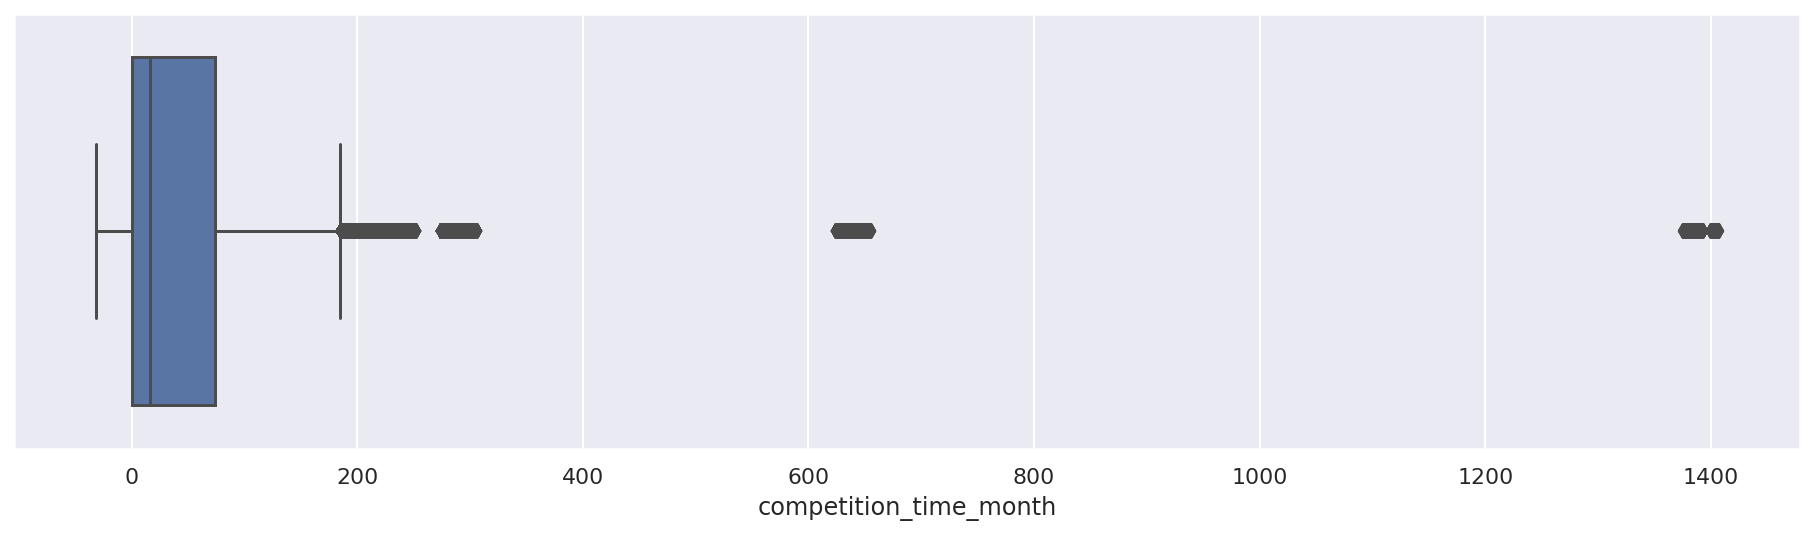

In [101]:
# Check competition_time_month outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,4) )

# boxplot of competition_time_month to check outliers
sns.boxplot( df5['competition_time_month'] );

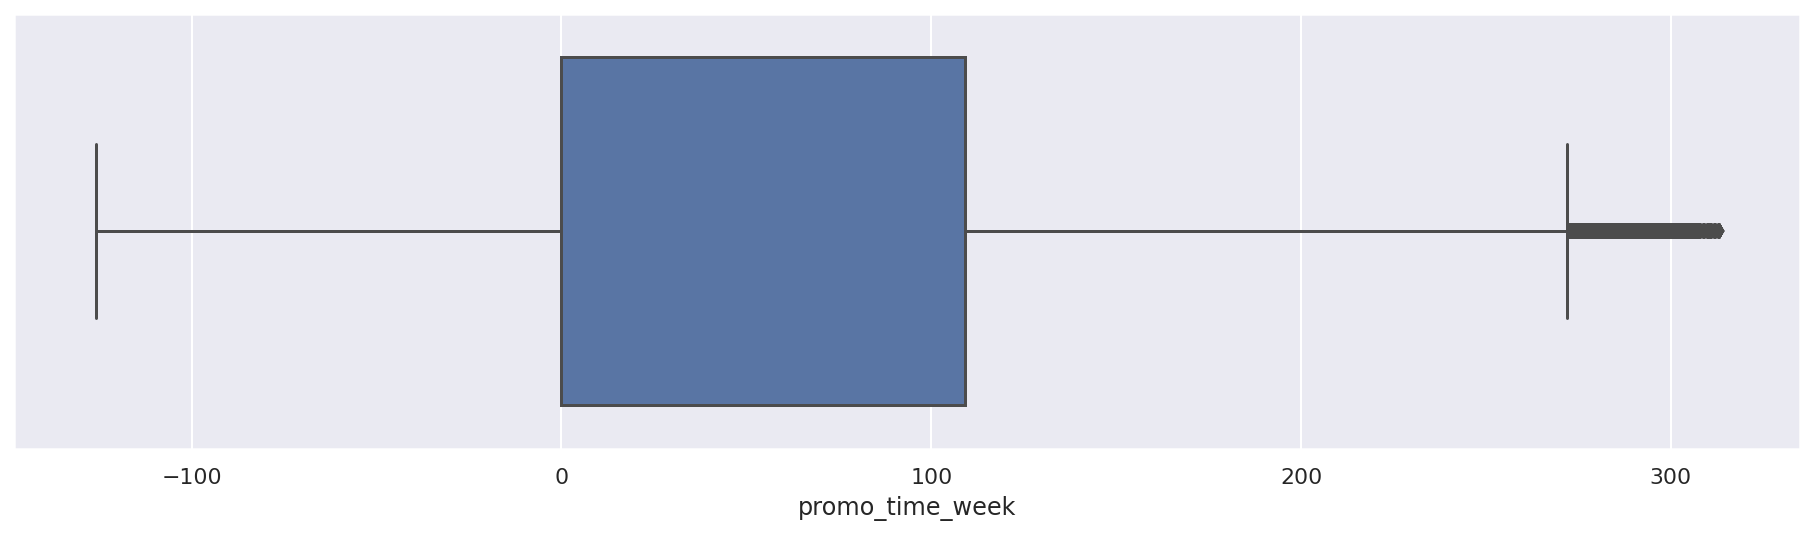

In [102]:
# Check promo_time_week outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,4) )

# boxplot of promo_time_week to check outliers
sns.boxplot( df5['promo_time_week'] );

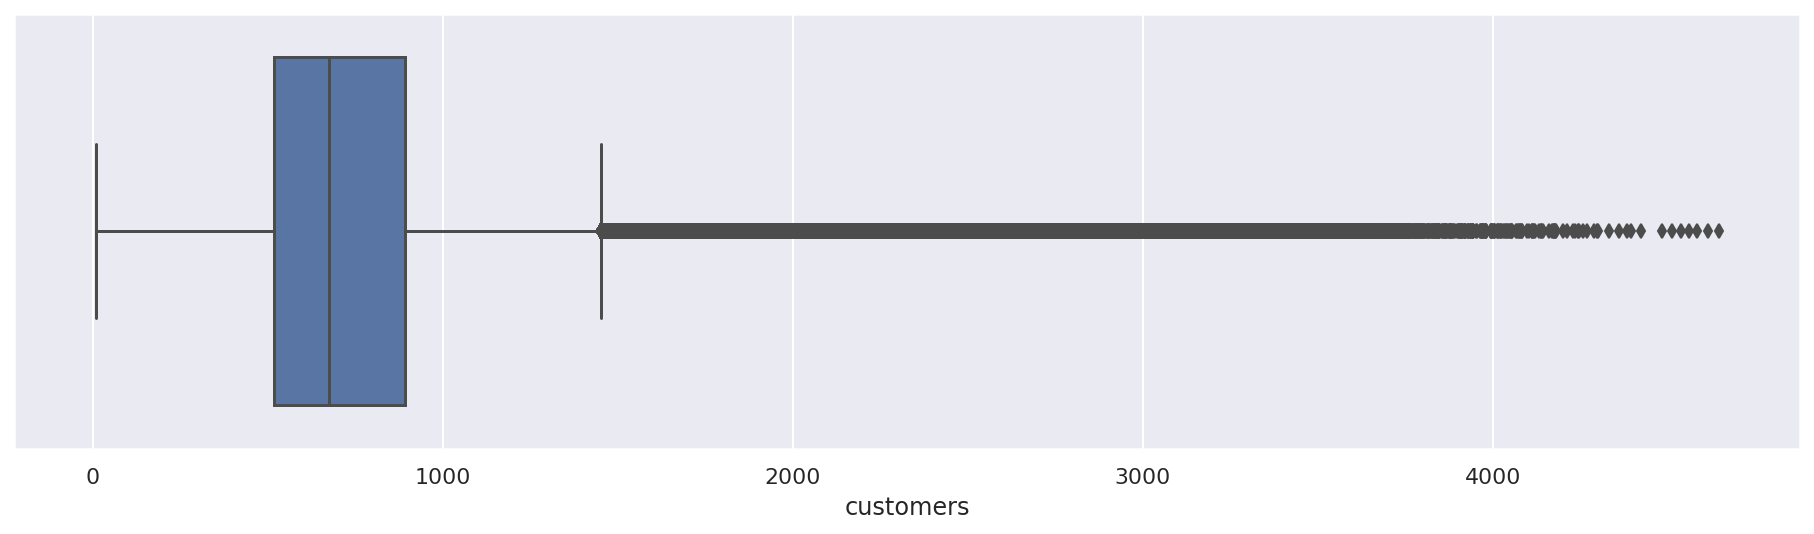

In [103]:
# Check customers outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,4) )

# boxplot of customers to check outliers
sns.boxplot( df5['customers'] );

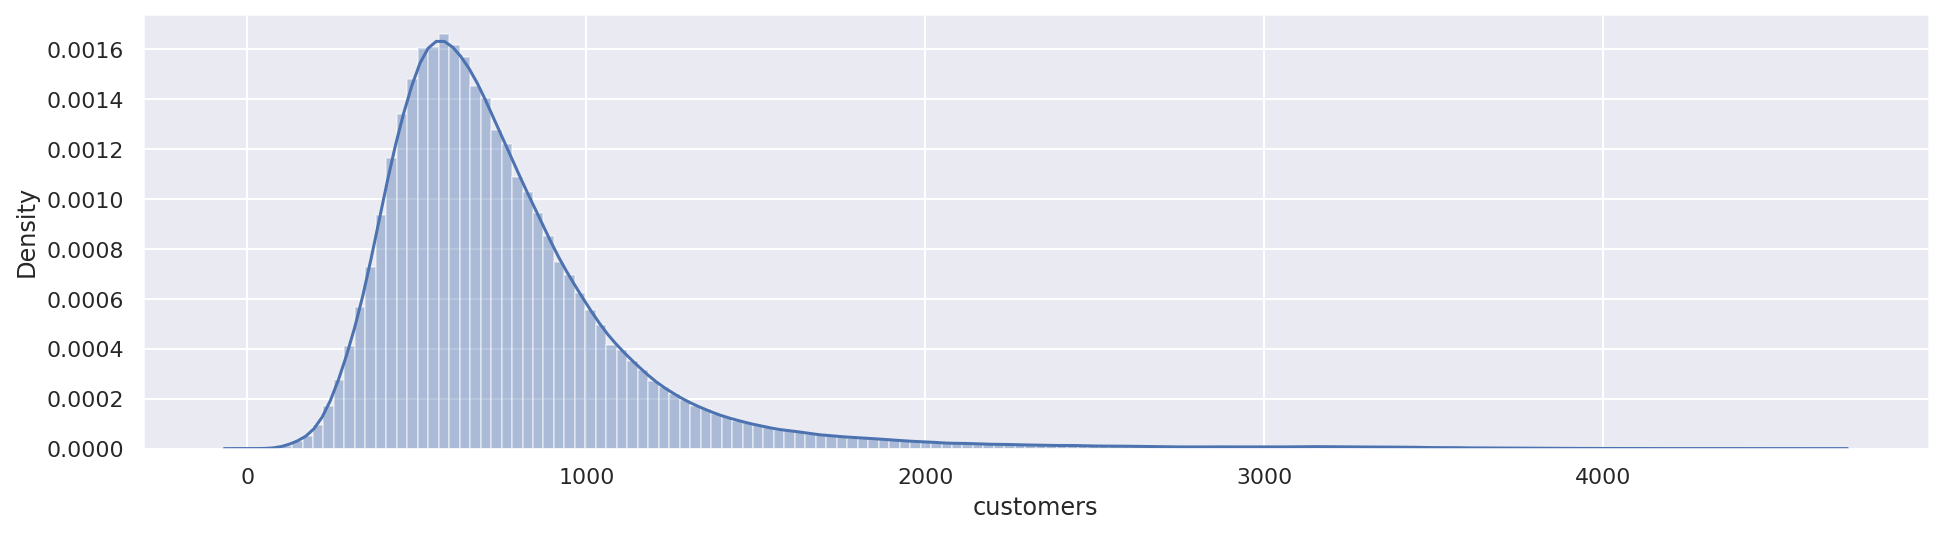

In [104]:
f, ax = plt.subplots( figsize=(16,4) )
sns.distplot(df5['customers'], bins=150 );

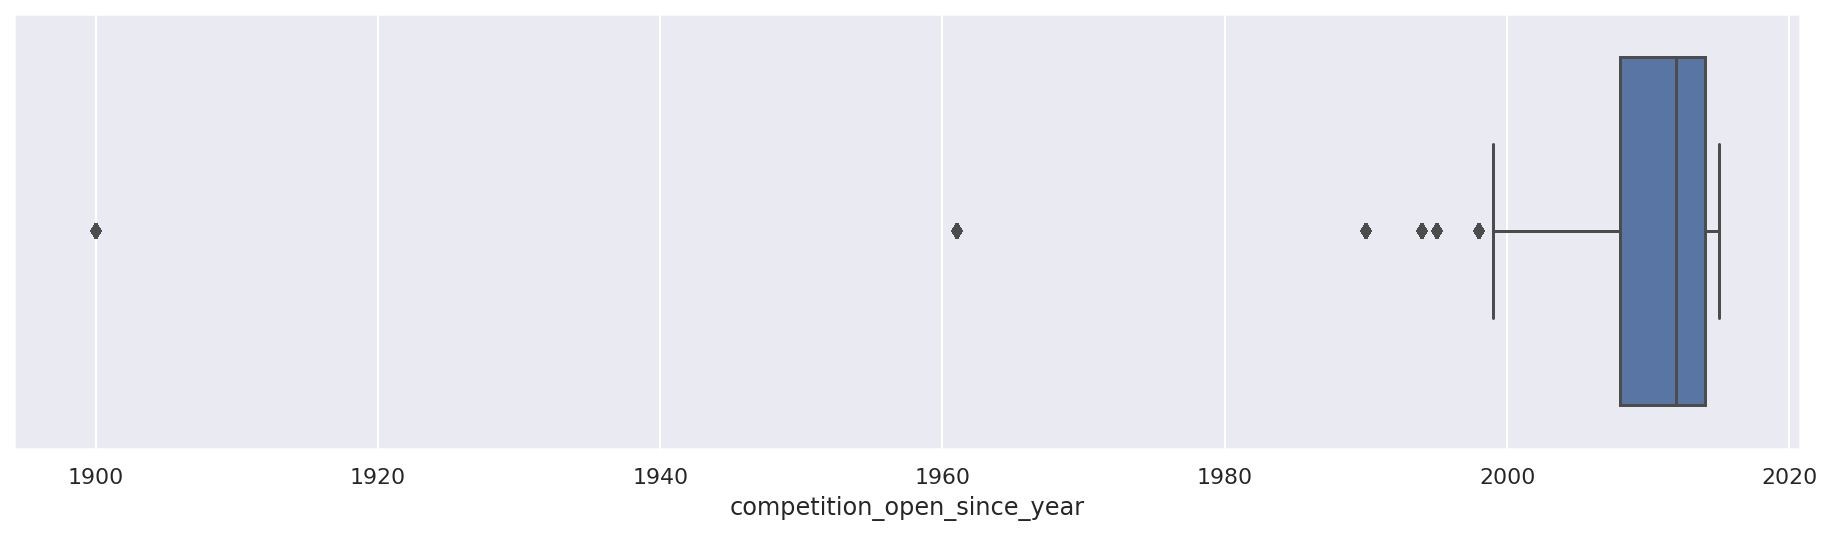

In [105]:
# competition open since year boxplot
f, ax = plt.subplots( figsize=(16,4) )
sns.boxplot(df5['competition_open_since_year']);

In [106]:
# numerical variables: competition_distance, competition_time_month, promo_time_week, year
# competition_open_since_year, promo2_since_year, customers

# 1. Robust Scaler - for variables with high outliers influence:
# competition_distance, competition_time_month, competition_open_since_year and customers
rs = RobustScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# save competition_distance scaler, so it can be applied in new data (deployment phase)
pickle.dump( rs, open( modelpath+'competition_distance_scaler.pkl', 'wb' ) )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# save competition_time_month scaler, so it can be applied in new data (deployment phase)
pickle.dump( rs, open( modelpath+'competition_time_month_scaler.pkl', 'wb' ) )

# competition_open_since_year
df5['competition_open_since_year'] = rs.fit_transform( df5[['competition_open_since_year']].values )  
# save competition_open_since_year scaler, so it can be applied in new data (deployment phase)
pickle.dump( rs, open( modelpath+'competition_open_since_year_scaler.pkl', 'wb' ) )

# customers
df5['customers'] = rs.fit_transform( df5[['customers']].values )  
# save customers scaler, so it can be applied in new data (deployment phase)
pickle.dump( rs, open( modelpath+'customers_scaler.pkl', 'wb' ) )

In [107]:
# 2. Min-Max Scaler - for variables with low outliers influence:
# competition_time_month, promo_time_week, year, promo2_since_year
mms = MinMaxScaler()

# competition_time_month
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )
# save competition_time_month scaler, so it can be applied in new data (deployment phase)
pickle.dump( mms, open( modelpath+'competition_time_month.pkl', 'wb' ) )

# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# save promo_time_week scaler, so it can be applied in new data (deployment phase)
pickle.dump( mms, open( modelpath+'promo_time_week_scaler.pkl', 'wb' ) )

# year - apply MinMaxScaler
df5['year'] = mms.fit_transform( df5[['year']].values )
# save year scaler, so it can be applied in new data (deployment phase)
pickle.dump( mms, open( modelpath+'year_scaler.pkl', 'wb' ) )

# promo2_since_year
df5['promo2_since_year'] = mms.fit_transform( df5[['promo2_since_year']].values )
# save promo2_since_year scaler, so it can be applied in new data (deployment phase)
pickle.dump( mms, open( modelpath+'promo2_since_year_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [108]:
# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# save store_type encoding, so it can be applied in new data (deployment phase)
pickle.dump(le, open( modelpath+'store_type_scaler.pkl', 'wb' ) )

# assortment - apply ordinal encoding
# dictionary does not need to be pickled because dictionary can be created in deploy.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Nature Transformation

In [109]:
# time variables - day_of_week, day, month, week_of_year, competition_open_since_month, promo2_since_week.

# Tranformation application: Cyclic Nature Transformation with sin and cos
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

### 5.3.3. Response Variable (Target) Transformation

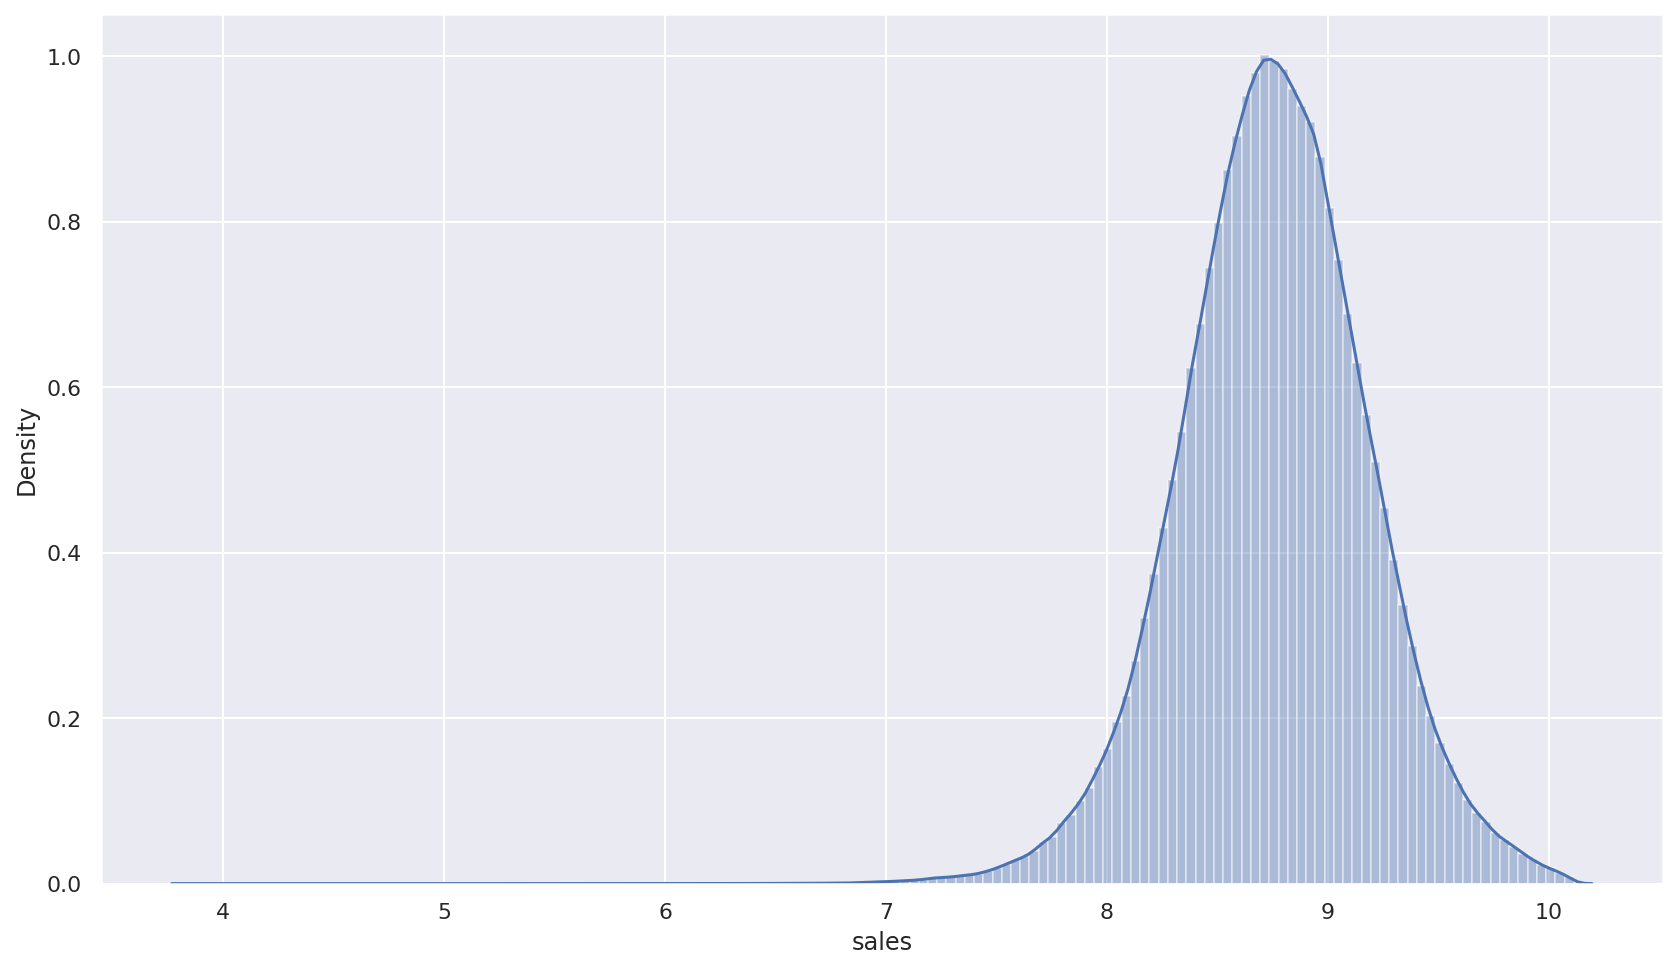

In [110]:
# Transform sales into log in order to obtain a normal distribution

f, ax = plt.subplots( figsize=(14,8) )
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales'], bins=150 );

In [111]:
df5.head().T

0                    1                    2                    3                    4
store                                               1                    2                    3                    4                    5
day_of_week                                         5                    5                    5                    5                    5
date                              2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00  2015-07-31 00:00:00
sales                                          8.5686               8.7103               9.0258               9.5465               8.4812
customers                                     -0.3217              -0.1340               0.3914               2.2064              -0.3110
promo                                               1                    1                    1                    1                    1
school_holiday                                      1                    1                    1                    1                    1
store_type                                          2                    0                    0                    2                    0
assortment                                          1                    1                    1                    3                    1
competition_distance                          -0.1710              -0.2839               1.9032              -0.2758               4.4484
competition_open_since_month                        9                   11                   12                    9                    4
competition_open_since_year                   -0.6667              -0.8333              -1.0000              -0.5000               0.5000
promo2                                              0                    1                    1                    0                    0
promo2_since_week                                  31                   13                   14                   31                   31
promo2_since_year                              1.0000               0.1667               0.3333               1.0000               1.0000
year                                           1.0000               1.0000               1.0000               1.0000               1.0000
month                                               7                    7                    7                    7                    7
day                                                31                   31                   31                   31                   31
week_of_year                                       31                   31                   31                   31                   31
year_week                                     2015-30              2015-30              2015-30              2015-30              2015-30
competition_since                 2008-09-01 00:00:00  2007-11-01 00:00:00  2006-12-01 00:00:00  2009-09-01 00:00:00  2015-04-01 00:00:00
competition_time_month                         0.0806               0.0876               0.0952               0.0716               0.0250
promo_since                       2015-07-27 00:00:00  2010-03-22 00:00:00  2011-03-28 00:00:00  2015-07-27 00:00:00  2015-07-27 00:00:00
promo_time_week                                0.2870               0.9226               0.8018               0.2870               0.2870
state_holiday_christmas                             0                    0                    0                    0                    0
state_holiday_easter_holiday                        0                    0                    0                    0                    0
state_holiday_public_holiday                        0                    0                    0                    0                    0
state_holiday_regular_day                           1                    1                    1                    1                    1
day_of_week_sin                               -0.9

### saving data

In [112]:
pickle.dump( df5, open( intdatapath+'df5.pkl', 'wb' ) )

# 6.0. FEATURE SELECTION

In [113]:
df6 = pickle.load( open( intdatapath+'df5.pkl', 'rb' ) )

## 6.1. Split Dataframe into Training and Test Dataset

In [114]:
# Remove columns that already have a derivative one

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]

df6 = df6.drop( cols_drop, axis=1 )

In [116]:
pickle.dump(df6, open(intdatapath+'df6.pkl', 'wb'))

In [117]:
# Select the last 6 weeks for the Test Dataset
# Check the day that represents the beginning of the last 6 weeks
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [118]:
l0, c = df6.shape
print('df6 have {} Lines and {} Columns\n'.format( l0 , c ) )

# training dataset: entries before the last 6 weeks
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

l1, c = X_train.shape
print('X_train have {} Lines and {} Columns\n'.format( l1 , c ) )

# test dataset: entries from the last 6 weeks
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

l2, c = X_test.shape
print('X_test have {} Lines and {} Columns\n'.format( l2 , c ) )

# print min and max date values
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( " ")
print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

print("\nSo, if df6 have {} lines, the sum of X_train and X_test is {} lines to ! ok ?".format(l0, l1+l2))

df6 have 843493 Lines and 33 Columns

X_train have 802134 Lines and 33 Columns

X_test have 41359 Lines and 33 Columns

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
 
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00

So, if df6 have 843493 lines, the sum of X_train and X_test is 843493 lines to ! ok ?


#### Saving Data

In [119]:
pickle.dump(X_train, open(intdatapath+'X_train.pkl', 'wb'))
pickle.dump(X_test,  open(intdatapath+'X_test.pkl',  'wb'))

pickle.dump(y_train, open(intdatapath+'y_train.pkl', 'wb'))
pickle.dump(y_test,  open(intdatapath+'y_test.pkl',  'wb'))

## 6.2. Boruta as Feature Selector

In [14]:
# # Boruta disabled in module 07 in order to not run again, since it takes at least 2h 30min.

# # Boruta does not accept pandas df format, therefore the dataset must be converted to numpy values
# # training and test dataset for Boruta
# x_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# # ravel() puts the values into a vector
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

In [15]:
# # defined Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [16]:
# # Boruta disabled in module 07 in order to not run again, since it takes at least 2h 30min.

# cols_selected = boruta.support_.tolist()

# # best features by boruta
# x_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# # features not selected by boruta
# cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))

In [17]:
# cols_selected_boruta

['store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_cos',
 'month_cos',
 'week_of_year_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

In [18]:
# cols_not_selected_boruta

['day_sin',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [120]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [121]:
# Select boruta columns with date and sales. It will be applied on cross-validation step.
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [122]:
pickle.dump(df6,     open(intdatapath+'df6.pkl', 'wb'))

# 7.0. MACHINE LEARNING MODELLING

In [35]:
X_train = pickle.load(open(intdatapath+'X_train.pkl', 'rb'))
X_test  = pickle.load(open(intdatapath+'X_test.pkl',  'rb'))

y_train = pickle.load(open(intdatapath+'y_train.pkl', 'rb'))
y_test  = pickle.load(open(intdatapath+'y_test.pkl',  'rb'))

In [36]:
# Insert columns selected by Boruta on x_train and x_test
# date and sales not included! They will be included later.
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [37]:
# aux1 variable for calculation
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# sales mean values by stores - prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales' : 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1( yhat_baseline))
baseline_result

Model Name        MAE  MAPE%       RMSE
0  Average Model 1,347.4082 0.4490 1,806.7244

## 7.2. Linear Regression Model

In [38]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )


# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1( yhat_lr ) )
lr_result

Model Name        MAE  MAPE%       RMSE
0  Linear Regression 1,323.1140 0.1816 3,260.4072

The Linear Regression RMSE value is higher than the average model one, that is:
- The average model is better than the linear regression model;
- The data has a complex behaviour (non-linear).

### 7.2.1. Linear Regression Model - Cross Validation

In [41]:
# cross validation function
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

0.716109037399292


Model Name              MAE CV        MAPE CV            RMSE CV
0  Linear Regression  1417.87 +/- 208.22  0.18 +/- 0.01  3243.35 +/- 399.8

## 7.3. Linear Regression Regularized Model - Lasso

In [42]:
# Lasso model
# alpha parameter: fator multiplicativo de cada um dos pesos para que eles fiquem dentro de um range.
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )


# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

Model Name        MAE  MAPE%       RMSE
0  Linear Regression 1,378.1670 0.1866 3,036.8724

Linear Regression regularized model (Lasso) RMSE value was higher than standard linear regression.
Conclusion: the phenomenon that we measure it is not linear. It is also no simple, therefore a complex model. 

### 7.3.1. Lasso - Cross Validation

In [43]:
# cross validation function
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

0.40961503982543945


Model Name              MAE CV        MAPE CV            RMSE CV
0      Lasso  1461.31 +/- 228.92  0.19 +/- 0.01  3044.9 +/- 398.94

## 7.4. Random Forest Regressor

In [44]:
# Random Forest Regressor disabled in Step 10 due to long-time execution (aprox. 15 minutes)

# Random Forest Regressor model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )


# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

Model Name      MAE  MAPE%     RMSE
0  Random Forest Regressor 375.6549 0.0531 551.0922

### 7.4.1. Random Forest Regressor - Cross Validation

In [45]:
# Cross Validation disabled in module 08 in order to not run again, since it takes at least 30min.
# cross validation function
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=False )
rf_result_cv

221.34698224067688


Model Name           MAE CV        MAPE CV            RMSE CV
0  Random Forest Regressor  403.18 +/- 97.5  0.05 +/- 0.01  581.88 +/- 144.08

## 7.5. XGBoost Regressor

In [46]:
# model
# eta: quantas 'passadas' o modelo usa para fazer o aprendizado
# max_depth: máxima profundidade que a árvore pode chegar
# subsample: quantas amostras / porcentagem de todas as variáveis para selecionar as mais relevantes
# colsample_bytee: xgboost é composto por várias árvores; sample por cada uma das árvores
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
#                               colsample_bytee=0.9,
                              subsample=0.7 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

Model Name        MAE  MAPE%       RMSE
0  XGBoost Regressor 6,665.6061 0.9519 7,273.0965

### 7.5.1. XGBoost Regressor - Cross Validation

In [47]:
# Cross Validation disabled in module 08 in order to not run again, since it takes at least 16min.
# cross validation function
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False )
xgb_result_cv

47.94348621368408


Model Name              MAE CV       MAPE CV            RMSE CV
0  XGBoost Regressor  7017.19 +/- 564.91  0.95 +/- 0.0  7639.3 +/- 641.78

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [30]:
# concatenate models results
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

Model Name    MAE   MAPE   RMSE
0  Random Forest Regressor 0.0542 0.0062 0.0710
0        Linear Regression 0.1752 0.0200 0.2417
0            Average Model 0.2006 0.0469 0.2567
0        Linear Regression 0.2340 0.0268 0.2978
0        XGBoost Regressor 4.6889 0.5344 4.6988

### 7.6.2. Real Performance - Cross Validation

In [31]:
# concatenate models results
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

Model Name         MAE CV       MAPE CV        RMSE CV
0        Linear Regression  0.18 +/- 0.01  0.02 +/- 0.0  0.25 +/- 0.01
0                    Lasso  0.24 +/- 0.02  0.03 +/- 0.0   0.3 +/- 0.02
0  Random Forest Regressor  0.06 +/- 0.01  0.01 +/- 0.0  0.07 +/- 0.01
0        XGBoost Regressor  4.72 +/- 0.06  0.54 +/- 0.0  4.73 +/- 0.06

#### Metrics went crazy !!!

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [80]:
# Random Search disabled in order to not run again, since it takes a considerable time to get done.

param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytee': [0.3, 0.7, 0.9], # disabled because deprecated in XGB
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 5

In [82]:
# %%time
# # Random Search disabled in order to not run again, since it takes a considerable time to get done.
# # Data Frame for final results
# final_result = pd.DataFrame()

# # select ramdomly the values for the random search
# for i in range( MAX_EVAL ):
#     hp = { k: random.choice( v, 1 )[0] for k, v in param.items() } # return values from param dictionary
#     print( hp )

#     # selected model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
# #                                   colsample_bytee=hp['colsample_bytee'],
#                                   min_child_weight=hp['min_child_weight'] )

#     # performance measurement
#     result = cross_validation( x_training, MAX_EVAL, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'min_child_weight': 15}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
CPU times: user 2d 2min 53s, sys: 2min, total: 2d 4min 53s
Wall time: 6h 14min 47s


Model Name        MAE CV       MAPE CV       RMSE CV
0  XGBoost Regressor  0.05 +/- 0.0  0.01 +/- 0.0  0.07 +/- 0.0
0  XGBoost Regressor  0.05 +/- 0.0  0.01 +/- 0.0  0.06 +/- 0.0
0  XGBoost Regressor  0.05 +/- 0.0  0.01 +/- 0.0  0.07 +/- 0.0
0  XGBoost Regressor  0.05 +/- 0.0  0.01 +/- 0.0  0.06 +/- 0.0
0  XGBoost Regressor  0.09 +/- 0.0  0.01 +/- 0.0  0.11 +/- 0.0

## 8.2. Final Model

In [83]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# Dict with values from the random search result.
param_tuned = {
    'n_estimators': 3500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.1,
    #'colsample_bytee': 0.7,
    'min_child_weight': 3
        }

In [84]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] )

In [86]:
%%time
model_xgb_tuned.fit( X_train, y_train )

CPU times: user 3h 27min 5s, sys: 11.8 s, total: 3h 27min 16s
Wall time: 27min 10s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=9,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=3500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
%%time
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

CPU times: user 6.42 s, sys: 7.9 ms, total: 6.43 s
Wall time: 961 ms


In [88]:
%%time
# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 4.57 ms


Model Name    MAE   MAPE   RMSE
0  XGBoost Regressor 0.0460 0.0053 0.0602

In [89]:
# Mean percentage error
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0005239213403202814

## 8.3 Saving Final Model

In [90]:
# save the trained, tuned XGBoost model
pickle.dump(model_xgb_tuned, open( modelpath+'model_xgb_rossmann_v02.pkl', 'wb' ) )

In [28]:
# load the trained, tuned XGBoost model
model_xgb_tuned = pickle.load( open( modelpath+'model_xgb_rossmann_v02.pkl', 'rb' ) )

In [29]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

NameError: name 'x_test' is not defined

## 8.4. XGBoost Regressor (tuned) - Cross-Validation

In [96]:
# XGBoost tuned cross-validation
xgb_tuned_cv = cross_validation( x_training, 5, 'XGBoost Regressor (tuned)', model_xgb_tuned, verbose=False )
xgb_tuned_cv

1693.5355761051178


Model Name        MAE CV       MAPE CV       RMSE CV
0  XGBoost Regressor (tuned)  0.05 +/- 0.0  0.01 +/- 0.0  0.06 +/- 0.0

# 9.0. ERROR TRANSLATION AND INTERPRETATION

In [97]:
# select full test data (with date and sales)
df9 = X_test[ cols_selected_boruta_full ]

# rescale sales and model prediction
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [98]:
# sum of predictions, sum of sales
df91 = df9[['sales','store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# reorder columns
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [99]:
# sort stores with higher MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

store    sales  predictions  worst_scenario  best_scenario    MAE   MAPE
908    909 198.4943     196.0904        195.9004       196.2804 0.1900 0.0201
875    876 200.2920     197.4038        197.2267       197.5810 0.1771 0.0189
291    292 152.0380     150.8893        150.7490       151.0296 0.1403 0.0161
136    137 331.1171     335.2521        335.1382       335.3661 0.1140 0.0129
695    696 336.6216     332.9760        332.8714       333.0806 0.1046 0.0115

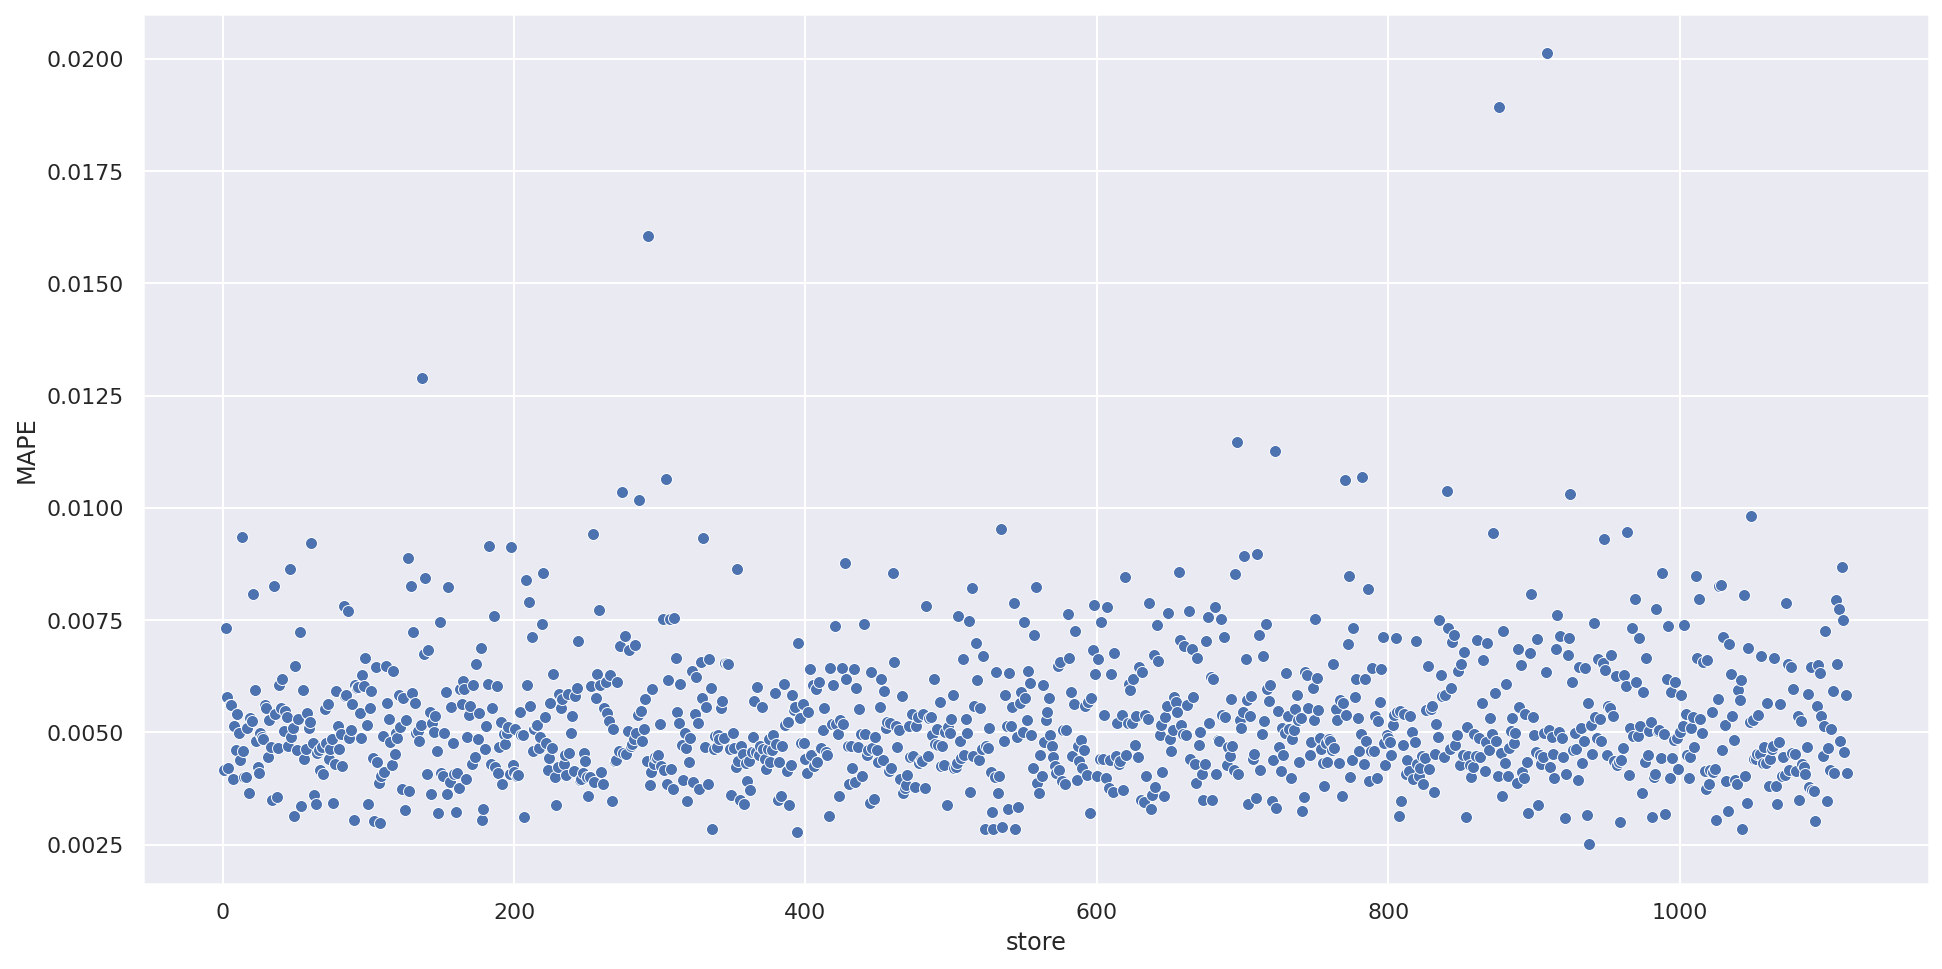

In [101]:
# scatter plot
# set up figure size
f, ax = plt.subplots( figsize=(16,8))
sns.scatterplot( x='store', y='MAPE', data=df92);

In [102]:
df92.sample(10).T

537      372        1061     995      697      384      494      880        1036     834 
store          538.0000 373.0000 1,062.0000 996.0000 698.0000 385.0000 495.0000 881.0000 1,037.0000 835.0000
sales          304.4412 312.1949   321.9338 325.6377 359.5674 327.4029 317.8466 305.0552   322.3306 316.5454
predictions    304.1608 311.7839   322.1360 324.5653 357.7203 328.4833 318.2404 303.9029   322.4970 314.6454
worst_scenario 304.1187 311.7486   322.0977 324.5229 357.6689 328.4300 318.2039 303.8522   322.4548 314.5809
best_scenario  304.2028 311.8192   322.1744 324.6077 357.7718 328.5367 318.2770 303.9536   322.5391 314.7098
MAE              0.0420   0.0353     0.0383   0.0424   0.0514   0.0533   0.0366   0.0507     0.0422   0.0644
MAPE             0.0051   0.0042     0.0044   0.0048   0.0053   0.0061   0.0043   0.0061     0.0048   0.0075

## 9.2. Total Performance

In [103]:
# sum of values from all stores
df93 = df92[['sales','predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0:'total_sales'})
df93['total_sales'] = df93['total_sales'].map( 'R$ {:,.2f}'.format)
df93

Scenarios    total_sales
0           sales  R$ 362,573.17
1     predictions  R$ 362,360.31
2  worst_scenario  R$ 362,308.86
3   best_scenario  R$ 362,411.73

## 9.3. Machine Learning Performance

In [104]:
# error
df9['error'] = df9['sales'] - df9['predictions']

#error rate
df9['error_rate'] = df9['predictions'] / df9['sales']

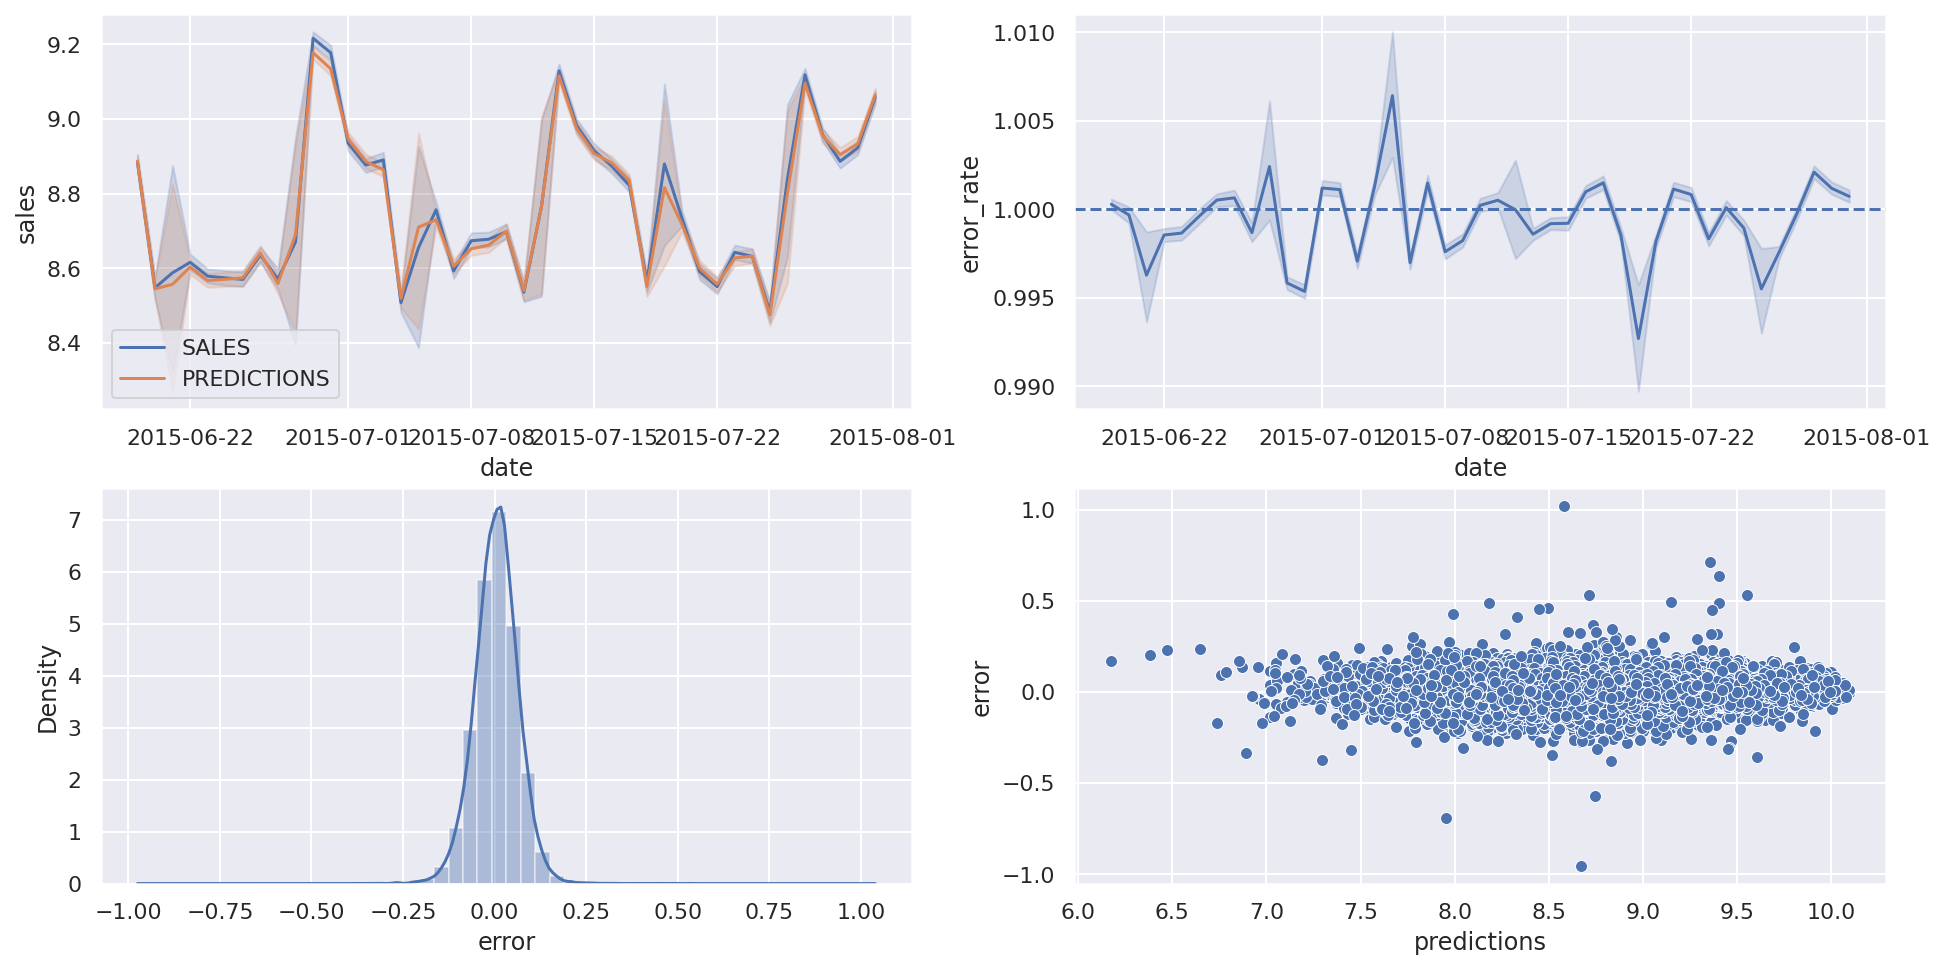

In [121]:
# set up figure size
f, ax = plt.subplots( figsize=(16,8))

# lineplot date x sales x predictions
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# lineplot date x error_rate
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
# add line in the lineplot
plt.axhline( 1, linestyle='--')

# plot error distribution
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# scatter plot predictions x error
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] );

In [24]:
# # sales x predictions
# # set up figure size
# plt.subplots( figsize=(16,8))

# # lineplot date x sales x predictions
# sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
# sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

In [25]:
# # error rate
# plt.subplots(figsize=(16,8))
# # lineplot date x error_rate
# sns.lineplot( x='date', y='error_rate', data=df9 )
# # add line in the lineplot
# plt.axhline( 1, linestyle='--');

In [26]:
# # error distribution
# sns.distplot( df9['error'] );

In [27]:
# # error x predictions
# plt.subplots(figsize=(16,8))
# sns.scatterplot( df9['predictions'], df9['error'] );

## 9.4. Best and Worst MAPE

In [110]:
# sort stores with higher MAPE
df92.sort_values( 'MAPE', ascending=False ).head(10)

store    sales  predictions  worst_scenario  best_scenario    MAE   MAPE
908    909 198.4943     196.0904        195.9004       196.2804 0.1900 0.0201
875    876 200.2920     197.4038        197.2267       197.5810 0.1771 0.0189
291    292 152.0380     150.8893        150.7490       151.0296 0.1403 0.0161
136    137 331.1171     335.2521        335.1382       335.3661 0.1140 0.0129
695    696 336.6216     332.9760        332.8714       333.0806 0.1046 0.0115

In [111]:
# sort stores with lower MAPE
df92.sort_values( 'MAPE', ascending=True ).head(10)

store    sales  predictions  worst_scenario  best_scenario    MAE   MAPE
937     938 338.4620     338.4449        338.4218       338.4680 0.0231 0.0025
393     394 335.1393     335.5412        335.5158       335.5666 0.0254 0.0028
543     544 339.5810     339.6020        339.5750       339.6290 0.0270 0.0028
1042   1043 332.2533     332.1094        332.0837       332.1350 0.0256 0.0028
335     336 351.0661     350.9923        350.9653       351.0194 0.0271 0.0028

In [119]:
# sum of all sales by store and by date
aux2 = df9[['date', 'store', 'sales', 'predictions']].groupby( ['date', 'store'] ).sum().reset_index()
aux2.sample(7).T

1913                 39103                1528                 40646                14012                28958                18018
date         2015-06-20 00:00:00  2015-07-29 00:00:00  2015-06-20 00:00:00  2015-07-31 00:00:00  2015-07-03 00:00:00  2015-07-18 00:00:00  2015-07-08 00:00:00
store                        801                 1082                  416                  400                  596                 1013                  115
sales                     8.0771               8.8786               9.2423               9.3133               8.6316               7.6368               8.8259
predictions               8.0938               8.8818               9.2519               9.3385               8.5915               7.5573               8.8542

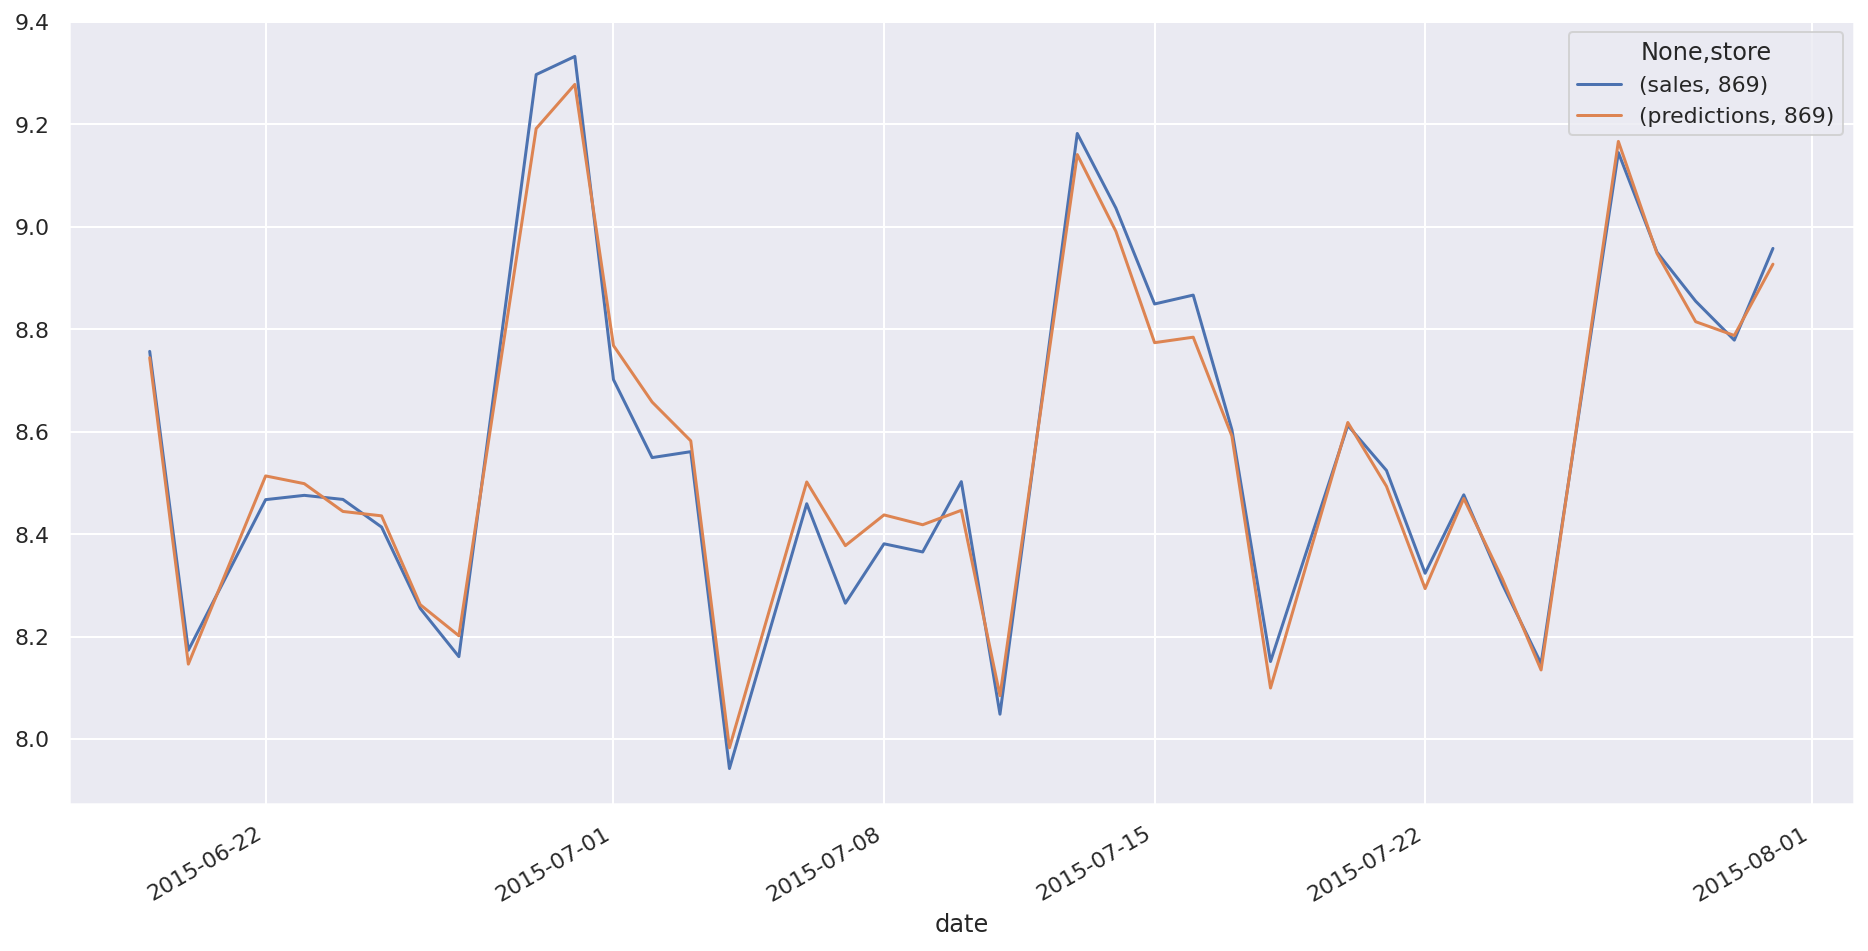

In [115]:
# lineplot store 869 - best prediction
aux4 = aux2[aux2['store'] == 869]
aux4.pivot( index='date', columns='store', values=['sales', 'predictions']).plot(figsize=(16,8));

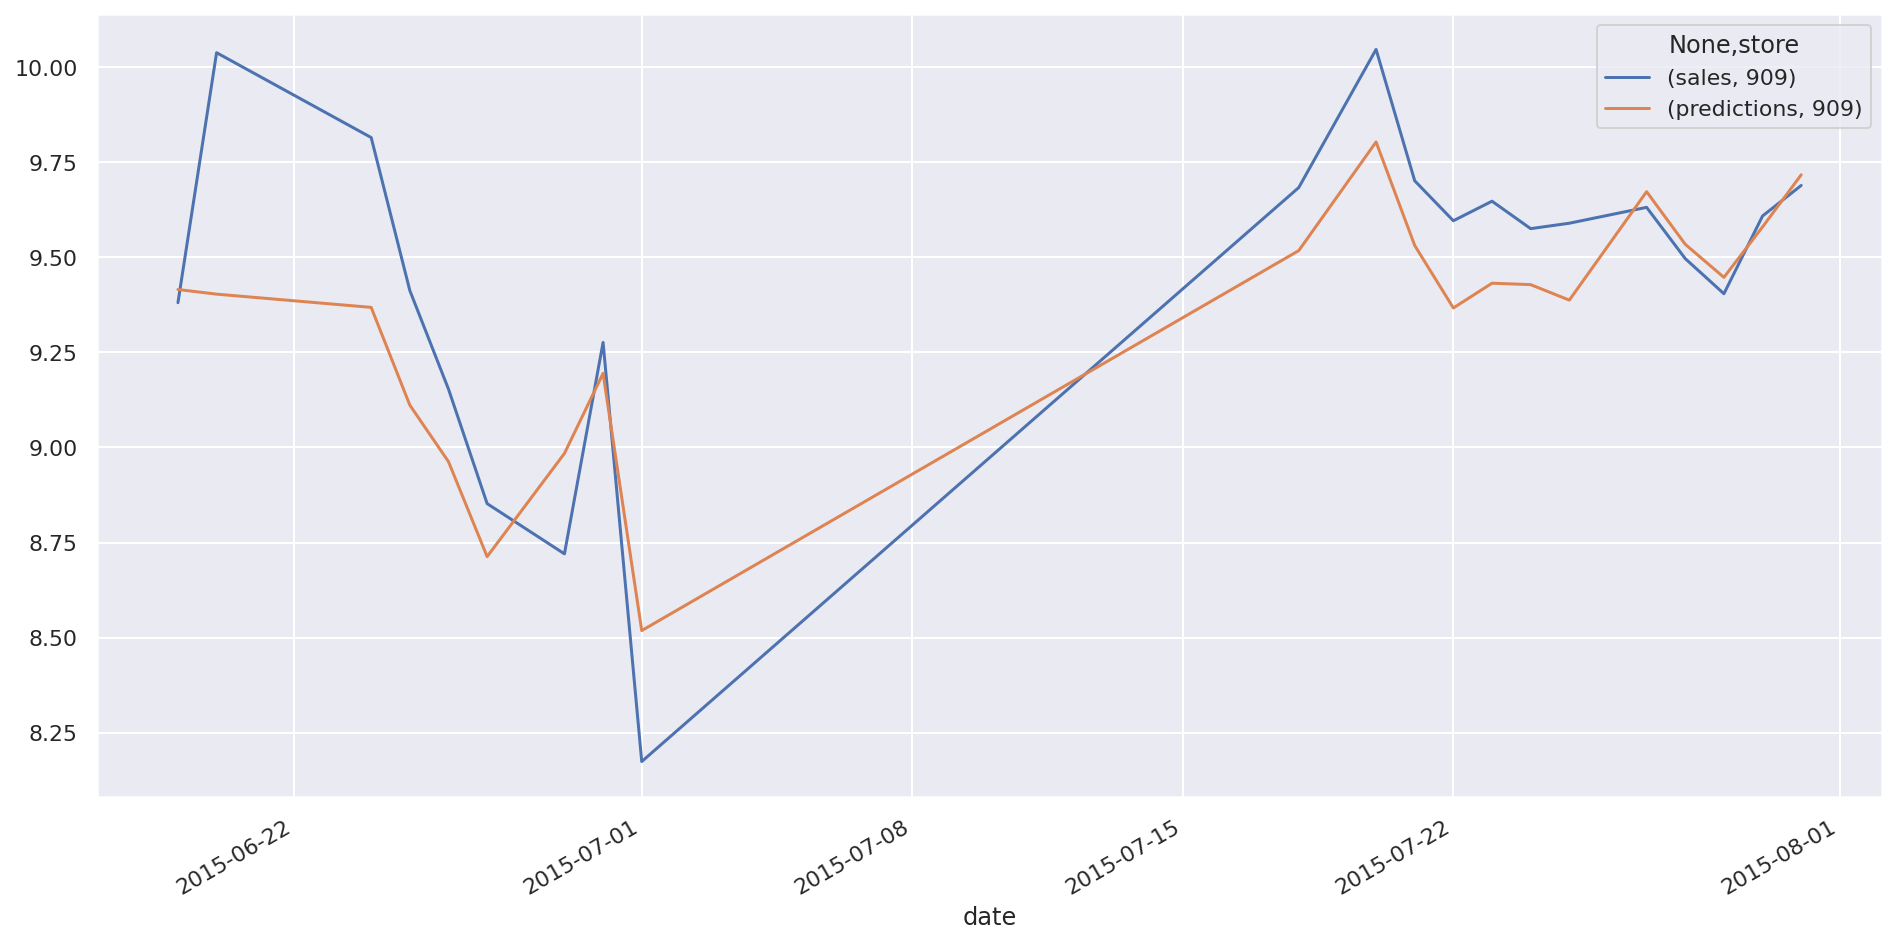

In [120]:
# lineplot store 909 - worst prediction
aux5 = aux2[aux2['store'] == 909]
aux5.pivot( index='date', columns='store', values=['sales', 'predictions']).plot(figsize=(16,8));

# ---

# 10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
from datetime import datetime
from datetime import timedelta

class Rossmann_v02( object ):
    def __init__( self ):
        self.competition_distance_scaler        = pickle.load( open( modelpath+'competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler      = pickle.load( open( modelpath+'competition_time_month_scaler.pkl', 'rb' ) )
        self.competition_open_since_year_scaler = pickle.load( open( modelpath+'competition_open_since_year_scaler.pkl', 'rb' ) )
        self.customers_scaler                   = pickle.load( open( modelpath+'customers_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler             = pickle.load( open( modelpath+'promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                        = pickle.load( open( modelpath+'year_scaler.pkl', 'rb' ) )
        self.promo2_since_year_scaler           = pickle.load( open( modelpath+'promo2_since_year_scaler.pkl', 'rb' ) )
        self.store_type_scaler                  = pickle.load( open( modelpath+'store_type_scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
                   'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance
        # market analysis assumption: position without values means a far competition distance, higher than the
        # maximum value from the raw data.
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        # Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
        # over time the sales performance.
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        # Same assumption as competition_open_since_month
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        # Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        # Same assumption as promo2_since_week
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
        # Fill NA values with zero.
        df1['promo_interval'].fillna(0, inplace=True)

        ## 1.6. Change Types

        # change competition_open_since_month type to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

        # change competition_open_since_year type to int
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        # change promo2_since_week type to int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

        # change promo2_since_year type to int
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        # change customers type to int
        df1['customers'] = df1['customers'].astype('int64')
        
        return df1

    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        # Bring together competition_open_since_month and competition_open_since_year
        # Assumption: day = 1 in order to consider the full month.
        df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

        # Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        # 1. Create a string 'year-week'
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        # 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
        # 3. create promo_time_week column with the difference between date and promo_since in weeks.
        # df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. STEP 03 - VARIABLES FILTERING

        ## 3.1. Line Filtering
        # closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
        # sales = 0 will also be removed.
        df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection

        # Customers is a variable that is not available at the time of prediction, hence it is a business restriction.
        # To use Customers variable, a new project is needed only for customers forecast in the next 6 weeks, and then use it as input in this sales forecast project.
        # Therefore, the column customers must be removed.
        # open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
        # promo_interval generated new columns in the feature engineering step and is no longer needed.
        # month_map is an auxiliary column and hence will be removed.
        cols_drop = ['open', 'promo_interval']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_month
        # Apply RobustScaler due to the presence of outliers.
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
        # competition_open_since_year
        df5['competition_open_since_year'] = self.competition_open_since_year_scaler.fit_transform( df5[['competition_open_since_year']].values ) 
    
        # customers
        df5['customers'] = self.customers_scaler.fit_transform( df5[['customers']].values )
    
        # promo_time_week
        # The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year - apply MinMaxScaler
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        # promo2_since_year
        df5['promo2_since_year'] = self.promo2_since_year_scaler.fit_transform( df5[['promo2_since_year']].values )


        ### 5.3.1. Encoding

        # state_holiday - apply one-hot encoding with get_dummies from pandas
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - apply label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - apply ordinal encoding
        # dictionary does not need to be pickled because dictionary can be created in deploy.
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation

        # Tranformation application: Cyclic Nature Transformation with sin and cos
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
        # competition_open_since_month
        df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # promo2_since_week
        df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
        
        
        cols_selected = ['store','customers', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_year', 'promo2', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos',
                         'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'competition_open_since_month_sin', 'competition_open_since_month_cos',
                         'promo2_since_week_sin', 'promo2_since_week_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
# import pickle
import pickle
# import pandas
import pandas as pd
# import flask
from flask import Flask, request, Response
#import Rossmann class
from rossmann.Rossmann_v02 import Rossmann_v02

# load model
model = pickle.load( open( modelpath+'model_xgb_rossmann_v02.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

# create endpoint (URL)
# Post method = send data in order to receive data.
@app.route( '/rossmann/predict', methods=['POST'] )
# function to get the received data
def rossmann_predict():
    test_json = request.get_json()
    
    #check received data (json)
    if test_json: # there is data
        if isinstance( test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # keys = chaves do json. Serão as colunas do df.
        
        # Instantiate Rossmann class
        pipeline = Rossmann_v02()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else: # there is no data
        return Response( '{}', status=200, mimetype='application/json' )

# check main function in the script
if __name__ == '__main__':
    app.run( '127.0.0.1' ) # local host

## 10.3. API Tester

In [ ]:
import requests

In [ ]:
# load test dataset
df10 = pd.read_csv(datapath+'test_customers.csv')

In [ ]:
df10.dtypes

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [75] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [ ]:
df_test.dtypes

In [ ]:
df_test.columns

In [ ]:
df_test.head()

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict' # url local
url = 'https://rossmann-model-v02.herokuapp.com/rossmann/predict' # endpoint heroku rossmann-model-v02
header = {'Content-type': 'application/json'}
data = data

# requests = send requsition to endpoint with data.
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format(r.status_code ) )

In [ ]:
# convert back to data frame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

In [ ]:
# sum prediction
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

In [ ]:
data

## 10.4. Rossmann_v02.py Tester

In [ ]:
df1 = df_test.copy()

### 10.4.1. Data Cleaning df1

In [ ]:
## 1.1. Rename Columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
           'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3. Data Types
df1['date'] = pd.to_datetime( df1['date'] )

## 1.5. Fillout NA
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

## 1.6. Change Types

# change competition_open_since_month type to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# change competition_open_since_year type to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# change promo2_since_week type to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# change promo2_since_year type to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
# change customers type to int
df1['customers'] = df1['customers'].astype('int64')


In [ ]:
df1.head()

In [ ]:
df1.dtypes

### 10.4.2. Feature Engineering df2

In [ ]:
df2 = df1.copy()

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. STEP 03 - VARIABLES FILTERING

## 3.1. Line Filtering
df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection
cols_drop = ['open', 'promo_interval']
df2 = df2.drop( cols_drop, axis=1 )

In [ ]:
df2.dtypes

In [ ]:
df2.head()

### 10.4.3. Data Preparation df5

In [ ]:
df5 = df2.copy()

In [ ]:
competition_distance_scaler        = pickle.load( open( modelpath+'competition_distance_scaler.pkl', 'rb' ) )
competition_time_month_scaler      = pickle.load( open( modelpath+'competition_time_month_scaler.pkl', 'rb' ) )
competition_open_since_year_scaler = pickle.load( open( modelpath+'competition_open_since_year_scaler.pkl', 'rb' ) )
customers_scaler                   = pickle.load( open( modelpath+'customers_scaler.pkl', 'rb' ) )
promo_time_week_scaler             = pickle.load( open( modelpath+'promo_time_week_scaler.pkl', 'rb' ) )
year_scaler                        = pickle.load( open( modelpath+'year_scaler.pkl', 'rb' ) )
promo2_since_year_scaler           = pickle.load( open( modelpath+'promo2_since_year_scaler.pkl', 'rb' ) )
store_type_scaler                  = pickle.load( open( modelpath+'store_type_scaler.pkl', 'rb' ) )

In [ ]:
## 5.2. Rescaling
# competition distance
df5['competition_distance'] = competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

# competition_time_month
# Apply RobustScaler due to the presence of outliers.
df5['competition_time_month'] = competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
 # competition_open_since_year
df5['competition_open_since_year'] = competition_open_since_year_scaler.fit_transform( df5[['competition_open_since_year']].values ) 
    
# customers
df5['customers'] = customers_scaler.fit_transform( df5[['customers']].values )
    
# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
# year - apply MinMaxScaler
df5['year'] = year_scaler.fit_transform( df5[['year']].values )
        
# promo2_since_year
df5['promo2_since_year'] = promo2_since_year_scaler.fit_transform( df5[['promo2_since_year']].values )

### 5.3.1. Encoding

# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
df5['store_type'] = store_type_scaler.fit_transform( df5['store_type'] )

# assortment - apply ordinal encoding
# dictionary does not need to be pickled because dictionary can be created in deploy.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.3. Nature Transformation

# Tranformation application: Cyclic Nature Transformation with sin and cos
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
cols_selected = ['store','customers', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_year', 'promo2', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos',
                         'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'competition_open_since_month_sin', 'competition_open_since_month_cos',
                         'promo2_since_week_sin', 'promo2_since_week_cos']

df5 = df5[cols_selected]

In [ ]:
df5.dtypes

In [ ]:
df5.head()

### 10.4.4. Prediction

In [ ]:
df_test_pred = df_test.copy()

In [ ]:
# load model
model = pickle.load( open( modelpath+'model_xgb_rossmann_v02.pkl', 'rb') )

pred = model.predict( df5 )
        
# join pred into the original data
df_test_pred['prediction'] = np.expm1( pred )

In [ ]:
df_test_pred.head()

In [ ]:
# sum prediction
d2 = df_test_pred[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'Store'], d2.loc[i, 'prediction'] ) )